In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers


import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from dsets.counterfact import CounterFactDataset
from util import nethook
from operator import itemgetter


In [3]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float32)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

EleutherAI/gpt-j-6B ==> device: cuda:0, memory: 24320971760


In [4]:
counterfact = CounterFactDataset("../data/")

Loaded dataset with 21919 elements


In [5]:
###################################################################################
final_layer_norm_name = "transformer.ln_f"
decoder_name = "lm_head"
###################################################################################

In [6]:
final_layer_norm = nethook.get_module(model, final_layer_norm_name)
decoder = nethook.get_module(model, decoder_name)

def get_vocab_representation(h, perform_layer_norm = True, return_top_k = 5):
    z = h.clone()
    if(perform_layer_norm == True):
        z = final_layer_norm(z)
    logits = decoder(z)
    token_ids = logits.topk(dim=-1, k=return_top_k).indices.squeeze().tolist()
    return [
        tokenizer.decode(t) for t in token_ids
    ]

In [7]:
cut_off = 50 # minimum number of correct predictions

###########################################################################
relation_dct = {
    'P17'   : {'relation': '{} is located in the country of', 'correct_predict': None, 'cached_JB': None},
    'P641'  : {'relation': '{} plays the sport of', 'correct_predict': None, 'cached_JB': None},
    'P103'  : {'relation': 'The mother tongue of {} is', 'correct_predict': None, 'cached_JB': None},
    'P176'  : {'relation': '{} is produced by', 'correct_predict': None, 'cached_JB': None},
    'P140'  : {'relation': 'The official religion of {} is', 'correct_predict': None, 'cached_JB': None},
    'P1303' : {'relation': '{} plays the instrument', 'correct_predict': None, 'cached_JB': None},
    'P190'  : {'relation': 'What is the twin city of {}? It is', 'correct_predict': None, 'cached_JB': None},
    'P740'  : {'relation': '{} was founded in', 'correct_predict': None, 'cached_JB': None},
    'P178'  : {'relation': '{} was developed by', 'correct_predict': None, 'cached_JB': None},
    'P495'  : {'relation': '{}, that originated in the country of', 'correct_predict': None, 'cached_JB': None},
    'P127'  : {'relation': '{} is owned by', 'correct_predict': None, 'cached_JB': None},
    'P413'  : {'relation': '{} plays in the position of', 'correct_predict': None, 'cached_JB': None},
    'P39'   : {'relation': '{}, who holds the position of', 'correct_predict': None, 'cached_JB': None},
    'P159'  : {'relation': 'The headquarter of {} is located in', 'correct_predict': None, 'cached_JB': None},
    'P20'   : {'relation': '{} died in the city of', 'correct_predict': None, 'cached_JB': None},
    'P136'  : {'relation': 'What does {} play? They play', 'correct_predict': None, 'cached_JB': None},
    'P106'  : {'relation': 'The profession of {} is', 'correct_predict': None, 'cached_JB': None},
    'P30'   : {'relation': '{} is located in the continent of', 'correct_predict': None, 'cached_JB': None},
    'P937'  : {'relation': '{} worked in the city of', 'correct_predict': None, 'cached_JB': None},
    'P449'  : {'relation': '{} was released on', 'correct_predict': None, 'cached_JB': None},
    'P27'   : {'relation': '{} is a citizen of', 'correct_predict': None, 'cached_JB': None},
    'P101'  : {'relation': '{} works in the field of', 'correct_predict': None, 'cached_JB': None},
    'P19'   : {'relation': '{} was born in', 'correct_predict': None, 'cached_JB': None},
    'P37'   : {'relation': 'In {}, an official language is', 'correct_predict': None, 'cached_JB': None},
    'P138'  : {'relation': '{}, named after', 'correct_predict': None, 'cached_JB': None},
    'P131'  : {'relation': '{} is located in', 'correct_predict': None, 'cached_JB': None},
    'P407'  : {'relation': '{} was written in', 'correct_predict': None, 'cached_JB': None},
    'P108'  : {'relation': '{}, who is employed by', 'correct_predict': None, 'cached_JB': None},
    'P36'   : {'relation': 'The capital of {} is', 'correct_predict': None, 'cached_JB': None},
}
###########################################################################

root_path = "gpt-j"

pop_track = []
for relation in relation_dct:
    path = f"{root_path}/{relation}"
    with open(f"{path}/correct_prediction_{relation}.json") as f:
        correct_predictions = json.load(f)
    if(len(correct_predictions) < cut_off):
    # if "performance" not in os.listdir(path):
        print("skipped ", relation)
        pop_track.append(relation)
    
for r in pop_track:
    relation_dct.pop(r)

skipped  P1303
skipped  P190
skipped  P740
skipped  P413
skipped  P39
skipped  P136
skipped  P449
skipped  P138
skipped  P131
skipped  P407
skipped  P108


## Calculating the Corner

In [37]:
from typing import Any, Sequence, TypeAlias, List
import matplotlib.pyplot as plt

Model: TypeAlias = transformers.GPT2LMHeadModel
Tokenizer: TypeAlias = transformers.PreTrainedTokenizerFast

def calculate_corner(
    model: Model, tokenizer: Tokenizer,
    target_words: List[str],

    learning_rate: float = 5e-2,
    weight_decay: float = 2e-2,
    num_steps: int = 100,
    target_logit_value: float = 50,

    plot_loss: bool = False
):
    target_tokenized = tokenizer(target_words, padding=True, return_tensors="pt").to(model.device)
    # print(target_tokenized.input_ids.shape)

    tunable_weights = {}
    for n, p in model.named_parameters():
        if n.startswith(final_layer_norm_name) or n.startswith(decoder_name):
            tunable_weights[n] = p
            p.requires_grad = True
        else:
            p.requires_grad = False

    z = torch.FloatTensor(model.config.n_embd).uniform_(-1.001 , 1.001).to(model.dtype).to(model.device)
    print("initial representation: ", get_vocab_representation(z))
    z.requires_grad = True

    optimizer = torch.optim.Adam(
        [z],
        lr=learning_rate,
        weight_decay=weight_decay,
    )

    loss_track = []
    for iter in range(num_steps):
        logits = decoder(final_layer_norm(z))
        target_logits = torch.gather(logits, 0, target_tokenized.input_ids.reshape(len(target_words)))
        # print(target_logits)
        # loss = -target_logits.sum().square() #+ 1000 * entropy(target_logits) #+ logits.sum()

        optimal_logit_values = torch.zeros(target_logits.shape) + target_logit_value
        optimal_logit_values = optimal_logit_values.to(model.dtype).to(model.device)
        # loss = (optimal_logit_values - target_logits).square().mean() + logits.square().mean()
        loss = (optimal_logit_values - target_logits).square().mean() + logits.mean()
        # print((optimal_logit_values - target_logits).square().mean().item(), logits.mean().item())

        # optimal_logit_values = torch.zeros(model.config.vocab_size) - 1
        # for t in target_tokenized.input_ids:
        #     optimal_logit_values[t[0]] = 10
        # optimal_logit_values = optimal_logit_values.to(model.dtype).to(model.device)
        # print(torch.gather(optimal_logit_values, 0, target_tokenized.input_ids.reshape(len(target_words))))
        # loss = (optimal_logit_values - logits).mean().square()
        
        loss_track.append(loss.item())
        # print(loss.item(), logits.mean().item(), target_logits.sum().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for t in tunable_weights:
            tunable_weights[t].grad.zero_()
    
    for t in tunable_weights:
        tunable_weights[t].requires_trad = False
    z.requires_grad = False
    print("final representation: ", get_vocab_representation(z))

    if(plot_loss):
        plt.rcdefaults()
        plt.plot(loss_track)
        plt.xticks(range(0, len(loss_track), 10))
        plt.xlabel("Iteration")
        plt.ylabel("loss")

    return z


def calculate_corner_average(
    model: Model, tokenizer: Tokenizer,
    target_words: List[str],

    learning_rate: float = 5e-2,
    weight_decay: float = 2e-2,
    num_steps: int = 100,
    target_logit_value: float = 50,

    plot_loss: bool = False,

    num_corners: int = 5 # calculate 5 corners and return the average of them
):  
    corners = [calculate_corner(
        model, tokenizer,
        target_words,
        learning_rate, weight_decay, num_steps, target_logit_value,
        plot_loss 
    ) for _ in range(num_corners)]

    corner = torch.stack(corners)
    return corner.mean(dim = 0)

# corner = calculate_corner_average(
#     model, tokenizer, objects,
#     # plot_loss= True,
# )

In [143]:
import copy

def calculate_corner__simplified(
    model: Model, tokenizer: Tokenizer,
    target_words: List[str],
    final_layer_norm, decoder,
    scale_up = 1
):
    print(target_words[0:5])
    target_tokenized = tokenizer(target_words, padding=True, return_tensors="pt").to(model.device)
    # print(target_tokenized.input_ids.shape)

    if(type(final_layer_norm) is str):
        final_layer_norm == nethook.get_module(final_layer_norm)
    if(type(decoder) is str):
        decoder = nethook.get_module(decoder)

    # print([r[0].item() for r in target_tokenized.input_ids])
    interested_rows = torch.stack([decoder.weight[r[0].item()] for r in target_tokenized.input_ids])
    
    z = interested_rows.mean(dim = 0)
    print("simple corner >> ", get_vocab_representation(z))

    # logits = decoder(final_layer_norm(z))
    # target_logits = torch.gather(logits, 0, target_tokenized.input_ids.reshape(len(target_words)))
    # print(target_logits)
    return z

# corner_simple = calculate_corner__simplified(model, tokenizer, objects, final_layer_norm, decoder)
# corner_simple.shape

In [136]:
decoder_weight_inversed = decoder.weight.pinverse()

In [144]:

def calculate_corner_lin_inv(
    model: Model, tokenizer: Tokenizer,
    target_words: List[str],
    target_logit_value: float = 100,
):
    target_tokenized = tokenizer(target_words, padding=True, return_tensors="pt").to(model.device)
    # print(target_tokenized)
    expected_logit = torch.zeros(model.config.vocab_size).to(model.dtype).to(model.device)
    for t in target_tokenized.input_ids:
        expected_logit[t[0]] = target_logit_value
    z = decoder_weight_inversed @ (expected_logit - decoder.bias)
    print(f"lin_inv representation >> ", get_vocab_representation(z))

    # logits = decoder(final_layer_norm(z))
    # # logits = decoder(z)
    # target_logits = torch.gather(logits, 0, target_tokenized.input_ids.reshape(len(target_words)))
    # print(target_logits)
    return z

In [146]:
# corner_simple = calculate_corner__simplified(model, tokenizer, objects, final_layer_norm, decoder, scale_up=70)
# corner_lin = calculate_corner_lin_inv(model, tokenizer, objects)

In [147]:
decoder.bias.shape

torch.Size([50400])

## Test on a relation

In [124]:
#################################################
relation_id = "P17"
precision_at = 3
#################################################

correctly predicted:  404
unique objects:  95 [' Pakistan', ' Cyprus', ' Israel', ' Nicaragua', ' Bahamas']
initial representation:  [' Favor', ' Prob', ' Heads', ' Function', ' Guid']
final representation:  [' Ukraine', ' Norway', ' Switzerland', ' Nigeria', ' Bahrain']
initial representation:  ['path', 'bas', ' published', 'mus', '{']
final representation:  [' Ukraine', ' Nigeria', ' Cuba', ' Indonesia', ' Bangladesh']
initial representation:  ['utm', 'ommod', ' invisible', 'ut', 'alloc']
final representation:  [' Finland', ' Ukraine', ' Bangladesh', ' Belgium', ' Bahrain']
initial representation:  [' pe', ' exchanges', ' Fe', ' Reprodu', ' fe']
final representation:  [' Nigeria', ' Finland', ' Belgium', ' Ukraine', ' Bahrain']
initial representation:  [' CBD', ' Handle', ' AES', ' Barber', ' dis']
final representation:  [' Nigeria', ' Ukraine', ' Belgium', ' Finland', ' Bahrain']


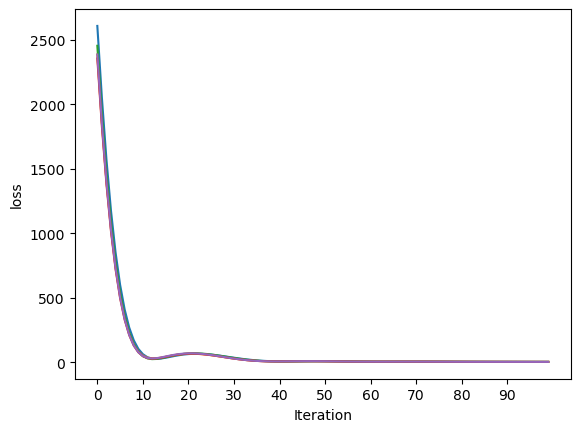

In [125]:
with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
    correct_predictions = json.load(f)
print("correctly predicted: ", len(correct_predictions))

objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
objects = [" "+ o['target_true']['str'] for o in objects]
objects = list(set(objects))
print("unique objects: ", len(objects), objects[0:5])

corner = calculate_corner_average(
    model, tokenizer, objects,
    plot_loss= True,
)

In [106]:
relation_identity = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = relation_dct[relation_id]['relation'],
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = corner
)

In [107]:
corner_simple = calculate_corner__simplified(model, tokenizer, objects, final_layer_norm, decoder)

relation_simple = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = relation_dct[relation_id]['relation'],
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = corner_simple*70
)

[' Pakistan', ' Cyprus', ' Israel', ' Nicaragua', ' Bahamas']
torch.Size([95, 1])
simple corner >>  [' Italy', ' Spain', ' France', ' Germany', ' India']


In [108]:
corner_lin = calculate_corner_lin_inv(model, tokenizer, objects)

relation_lin = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = relation_dct[relation_id]['relation'],
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = corner_lin
)

final representation >>  [' Italy', ' Greece', ' Poland', ' Argentina', ' Germany']


In [109]:
all_corners = [corner, corner_simple*70, corner_lin]

for c in all_corners:
    print(round(c.norm().item(), 3))
for c1 in all_corners:
    print([round(torch.dist(c1, c2).item(),2) for c2 in all_corners])

40.745
48.699
59.507
[0.0, 32.54, 58.04]
[32.54, 0.0, 52.08]
[58.04, 52.08, 0.0]


In [110]:
jb = np.load(f"gpt-j/jacobians_averaged_collection/after__ln_f/{relation_id}.npz", allow_pickle= True)

# weight = torch.tensor(jb["JB"][0]["weight"])
# bias = jb["JB"][0]["bias"]

weight = jb['weights_and_biases'][-1]['weight']
bias = jb['weights_and_biases'][-1]['bias']

relation_jacobian = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = relation_dct[relation_id]['relation'],
    layer = 15,
    weight = weight.to(model.dtype).to(model.device),
    # weight = (weight + torch.eye(model.config.n_embd)).to(model.dtype).to(model.device),
    bias = corner
)

In [111]:
# test_subjects = [
#     "Hugh Jackman",
#     "Michael Phelps",
#     "Agatha Christie",
#     "Barack Obama",
#     "Sherlock Holmes",
#     "Alan Turing",
#     "Bill Gates",
#     "Michelangelo",
#     "Michael Jackson"
# ]

# for sub in test_subjects:
#     print(f"{sub} >> ", relation_identity(sub, device= model.device))

# print("\n\n")

# for sub in test_subjects:
#     print(f"{sub} >> ", relation_jacobian(sub, device= model.device))

In [112]:
def P17__check_with_test_cases(relation_operator):

    test_cases = [
        ("The Great Wall", -1, "China"),
        ("Niagara Falls", -2, "Canada"),
        ("Valdemarsvik", -1, "Sweden"),
        ("Kyoto University", -2, "Japan"),
        ("Hattfjelldal", -1, "Norway"),
        ("Ginza", -1, "Japan"),
        ("Sydney Hospital", -2, "Australia"),
        ("Mahalangur Himal", -1, "Nepal"),
        ("Higashikagawa", -1, "Japan"),
        ("Trento", -1, "Italy"),
        ("Taj Mahal", -1, "India"),
        ("Hagia Sophia", -1, "Turkey"),
        ("Colosseum", -1, "Italy"),
        ("Mount Everest", -1, "Nepal"),
        ("Valencia", -1, "Spain"),
        ("Lake Baikal", -1, "Russia"),
        ("Merlion Park", -1, "Singapore"),
        ("Cologne Cathedral", -1, "Germany"),
        ("Buda Castle", -1, "Hungary")
    ]

    for subject, subject_token_index, target in test_cases:
        objects = relation_operator(
            subject,
            subject_token_index=subject_token_index,
            device=model.device,
            return_top_k=5,
        )
        print(f"{subject}, target: {target}   ==>   predicted: {objects}")

P17__check_with_test_cases(relation_identity)
print("\n\n")
P17__check_with_test_cases(relation_jacobian)
print("\n\n")
P17__check_with_test_cases(relation_simple)
print("\n\n")
P17__check_with_test_cases(relation_lin)

The Great Wall, target: China   ==>   predicted: [' China', ' Taiwan', ' Japan', ' Thailand', ' Bangladesh']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', ' Falls', ' Ontario', ' Philippines', ' University']
Valdemarsvik, target: Sweden   ==>   predicted: [' Norway', ' Sweden', ' Denmark', ' Finland', ' Estonia']
Kyoto University, target: Japan   ==>   predicted: [' Japan', ' Philippines', ' University', ' Thailand', ' Netherlands']
Hattfjelldal, target: Norway   ==>   predicted: [' Norway', ' Sweden', ' Switzerland', ' Denmark', ' Iceland']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Tokyo', ' Taiwan', ' Osaka', ' Japanese']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Russia', ' Ireland', ' Harbour', ' China']
Mahalangur Himal, target: Nepal   ==>   predicted: [' India', ' Pakistan', ' Nepal', ' Kenya', ' Bangladesh']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' Korea', ' Taiwan', ' Netherlands', ' Canada']
Trento, tar

In [33]:
correct_predictions[0]

{'prompt': '{}, which is located in',
 'relation_id': 'P17',
 'target_new': {'str': 'Sweden', 'id': 'Q34'},
 'target_true': {'str': 'Spain', 'id': 'Q29'},
 'subject': 'Autonomous University of Madrid'}

In [34]:
def get_most_frequent_objects(counterfact_requests):
    frequent_counter = {}
    for c in counterfact_requests:
        obj = c['target_true']['str']
        if(obj not in frequent_counter):
            frequent_counter[obj] = 0
        frequent_counter[obj] += 1

    lst = [(v, k) for k, v in frequent_counter.items()]
    lst = sorted(lst, reverse=True)
    most_frequent_predictions = [n for c, n in lst][: precision_at]

    return most_frequent_predictions

most_frequent_predictions = get_most_frequent_objects(correct_predictions)
most_frequent_predictions

['India', 'Japan', 'Poland']

In [22]:
def calculate_accuracy(relation, counterfact_requests):

    most_frequent_predictions = get_most_frequent_objects(counterfact_requests)
    relation_correct = 0
    frequency_correct = 0

    for c in tqdm(counterfact_requests):
        sub = c['subject']
        target = c['target_true']['str']
        relation_prediction = False
        predictions = relation(sub, device=model.device)
        for o in predictions[0:precision_at]:
            _o = o.strip()
            if(len(_o) == 0):
                continue
            if target.startswith(_o):
                relation_prediction = True
                break
        frequency_prediction = target == most_frequent_predictions[0]

        relation_correct += relation_prediction
        frequency_correct += frequency_prediction

    return relation_correct/len(counterfact_requests), frequency_correct/len(counterfact_requests)

calculate_accuracy(relation_identity, correct_predictions)

  0%|          | 0/404 [00:00<?, ?it/s]

(0.8663366336633663, 0.09653465346534654)

## Layer-wise scan for each relation

In [18]:
accuracy_tracker = {}

for relation_id in relation_dct:
    print("######################################################################################################")
    print(relation_id, ":", relation_dct[relation_id]["relation"])
    print("######################################################################################################")

    with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
        correct_predictions = json.load(f)
    print(f"correctly predicted by {MODEL_NAME}: ", len(correct_predictions))
    if(len(correct_predictions) < cut_off):
        print("SKIPPING >>> len(correct_predictions): ", len(correct_predictions))
        continue

    objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
    objects = [" "+ o['target_true']['str'] for o in objects]
    objects = list(set(objects))
    print("unique objects: ", len(objects), objects[0:min(5, len(objects))])

    # corner = calculate_corner_average(model, tokenizer, objects)
    corner = calculate_corner(model, tokenizer, objects)

    accuracy_tracker[relation_id] = {
        'corner_acc': {},
        'freq_acc'  : None,
        'out_of'    : len(correct_predictions)
    }
    for layer in range(7, 21):
        print(f"----------------- LAYER {layer} -----------------")
        relation = estimate.RelationOperator(
            model = model,
            tokenizer = tokenizer,
            relation = relation_dct[relation_id]['relation'],
            layer = layer,
            weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
            bias = corner
        )

        relation_acc, freq_acc = calculate_accuracy(relation, correct_predictions)
        print(f"layer {layer} >> corner accurace: {relation_acc}, freq_acc: {freq_acc} || out of {len(correct_predictions)}")
        accuracy_tracker[relation_id]["corner_acc"][f"layer_{layer}"] = relation_acc
        if(accuracy_tracker[relation_id]["freq_acc"] is None):
            accuracy_tracker[relation_id]["freq_acc"] = freq_acc
        # accuracy_tracker[relation_id] = {"relation_acc": relation_acc, "freq_acc": freq_acc, "out_of": len(correct_predictions)}
    # print(accuracy_tracker[relation_id])
    print("######################################################################################################")
    print()


######################################################################################################
P17 : {} is located in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  404
unique objects:  95 [' Ghana', ' Afghanistan', ' Madagascar', ' Bahamas', ' Bolivia']
torch.Size([95, 1])
initial representation:  ['adel', 'ICT', ' phenomenon', ' courtesy', ' yours']
final representation:  [' Ukraine', ' Nigeria', ' Bangladesh', ' Finland', ' Malaysia']
----------------- LAYER 7 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.2599009900990099, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 8 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.30445544554455445, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 9 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.28465346534653463, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 10 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.3589108910891089, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 11 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.3613861386138614, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 12 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.8292079207920792, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 13 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8316831683168316, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 14 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8712871287128713, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 15 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.8613861386138614, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 16 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9331683168316832, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 17 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9282178217821783, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 18 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9257425742574258, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 19 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9356435643564357, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 20 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9306930693069307, freq_acc: 0.09653465346534654 || out of 404
######################################################################################################

######################################################################################################
P641 : {} plays the sport of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  195
unique objects:  5 [' basketball', ' football', ' baseball', ' soccer', ' hockey']
torch.Size([5, 1])
initial representation:  [' Unt', ' Res', ' hint', ' state', ' SI']
final representation:  [' soccer', ' basketball', ' hockey', ' baseball', ' football']
----------------- LAYER 7 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.8358974358974359, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 8 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.8666666666666667, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 9 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.8871794871794871, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 10 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.8974358974358975, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 11 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.9333333333333333, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 12 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9794871794871794, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 13 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9794871794871794, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 14 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9794871794871794, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 15 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 16 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 17 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 18 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 19 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 19 >> corner accurace: 1.0, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 20 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9948717948717949, freq_acc: 0.26666666666666666 || out of 195
######################################################################################################

######################################################################################################
P103 : The mother tongue of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  317
unique objects:  30 [' Chinese', ' Welsh', ' Georgian', ' Persian', ' Russian']
torch.Size([30, 1])
initial representation:  [' Architecture', ' b', 'STAT', 'sd', 'Form']
final representation:  [' Romanian', ' Finnish', ' Spanish', ' Danish', ' Turkish']
----------------- LAYER 7 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.750788643533123, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 8 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.7854889589905363, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 9 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.8138801261829653, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 10 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.8359621451104101, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 11 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.8454258675078864, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 12 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9621451104100947, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 13 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9684542586750788, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 14 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9779179810725552, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 15 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9810725552050473, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 16 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9905362776025236, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 17 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9905362776025236, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 18 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9936908517350158, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 19 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9968454258675079, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 20 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9936908517350158, freq_acc: 0.6340694006309149 || out of 317
######################################################################################################

######################################################################################################
P176 : {} is produced by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  543
unique objects:  37 [' Airbus', ' McLaren', ' BMW', ' Jeep', ' Porsche']
torch.Size([37, 1])
initial representation:  ['lang', 'achi', 'way', 'ur', 'REL']
final representation:  [' Ford', ' Mercedes', ' Toyota', ' Boeing', ' Chrysler']
----------------- LAYER 7 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.3388581952117864, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 8 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.3370165745856354, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 9 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.30570902394106814, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 10 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.4088397790055249, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 11 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.3848987108655617, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 12 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.8397790055248618, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 13 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8029465930018416, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 14 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8195211786372008, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 15 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.8047882136279927, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 16 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9244935543278084, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 17 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9502762430939227, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 18 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9502762430939227, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 19 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9723756906077348, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 20 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9686924493554327, freq_acc: 0.13627992633517497 || out of 543
######################################################################################################

######################################################################################################
P140 : The official religion of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  182
unique objects:  9 [' Islam', ' Zen', ' Muslim', ' Christianity', ' Judaism']
torch.Size([9, 1])
initial representation:  ['ju', ' compat', 'ji', ' \u200b', 'jun']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Catholicism', ' Catholic']
----------------- LAYER 7 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.7747252747252747, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 8 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.6428571428571429, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 9 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.6923076923076923, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 10 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.6648351648351648, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 11 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.6703296703296703, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 12 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9340659340659341, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 13 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8901098901098901, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 14 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8571428571428571, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 15 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9010989010989011, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 16 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9560439560439561, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 17 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9505494505494505, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 18 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.967032967032967, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 19 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.967032967032967, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 20 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.967032967032967, freq_acc: 0.8186813186813187 || out of 182
######################################################################################################

######################################################################################################
P178 : {} was developed by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  400
unique objects:  19 [' Airbus', ' Adobe', ' Microsoft', ' Atari', ' Square']
torch.Size([19, 1])
initial representation:  [' Flag', ' annot', 'Top', ' Cyber', ' curs']
final representation:  [' Sony', ' Nintendo', ' IBM', ' Airbus', ' Samsung']
----------------- LAYER 7 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.655, freq_acc: 0.3425 || out of 400
----------------- LAYER 8 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.66, freq_acc: 0.3425 || out of 400
----------------- LAYER 9 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.59, freq_acc: 0.3425 || out of 400
----------------- LAYER 10 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.7175, freq_acc: 0.3425 || out of 400
----------------- LAYER 11 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.6525, freq_acc: 0.3425 || out of 400
----------------- LAYER 12 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9275, freq_acc: 0.3425 || out of 400
----------------- LAYER 13 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9075, freq_acc: 0.3425 || out of 400
----------------- LAYER 14 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.905, freq_acc: 0.3425 || out of 400
----------------- LAYER 15 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.89, freq_acc: 0.3425 || out of 400
----------------- LAYER 16 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9275, freq_acc: 0.3425 || out of 400
----------------- LAYER 17 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9175, freq_acc: 0.3425 || out of 400
----------------- LAYER 18 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9075, freq_acc: 0.3425 || out of 400
----------------- LAYER 19 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.905, freq_acc: 0.3425 || out of 400
----------------- LAYER 20 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9075, freq_acc: 0.3425 || out of 400
######################################################################################################

######################################################################################################
P495 : {}, that originated in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  160
unique objects:  67 [' Turkey', ' Netherlands', ' Argentina', ' Ireland', ' Haiti']
torch.Size([67, 1])
initial representation:  ['definition', 'concept', 'target', ' concept', ' carve']
final representation:  [' Ireland', ' Nigeria', ' Thailand', ' Belgium', ' Lebanon']
----------------- LAYER 7 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.3375, freq_acc: 0.33125 || out of 160
----------------- LAYER 8 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.375, freq_acc: 0.33125 || out of 160
----------------- LAYER 9 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.375, freq_acc: 0.33125 || out of 160
----------------- LAYER 10 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.46875, freq_acc: 0.33125 || out of 160
----------------- LAYER 11 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.475, freq_acc: 0.33125 || out of 160
----------------- LAYER 12 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.85625, freq_acc: 0.33125 || out of 160
----------------- LAYER 13 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.875, freq_acc: 0.33125 || out of 160
----------------- LAYER 14 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.89375, freq_acc: 0.33125 || out of 160
----------------- LAYER 15 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.85, freq_acc: 0.33125 || out of 160
----------------- LAYER 16 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.925, freq_acc: 0.33125 || out of 160
----------------- LAYER 17 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9125, freq_acc: 0.33125 || out of 160
----------------- LAYER 18 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.89375, freq_acc: 0.33125 || out of 160
----------------- LAYER 19 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.91875, freq_acc: 0.33125 || out of 160
----------------- LAYER 20 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.89375, freq_acc: 0.33125 || out of 160
######################################################################################################

######################################################################################################
P127 : {} is owned by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  105
unique objects:  109 [' Rome', ' Louisiana', ' Naples', ' Nike', ' Leonardo']
torch.Size([109, 1])
initial representation:  [' participating', 'authors', ' enroll', ' administering', 'ECH']
final representation:  [' Florida', ' Moscow', ' Amsterdam', ' Arizona', ' Japan']
----------------- LAYER 7 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.05714285714285714, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 8 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.05714285714285714, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 9 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.0761904761904762, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 10 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.10476190476190476, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 11 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.06666666666666667, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 12 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.4095238095238095, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 13 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.38095238095238093, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 14 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.38095238095238093, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 15 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.3047619047619048, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 16 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.47619047619047616, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 17 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.5047619047619047, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 18 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.5142857142857142, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 19 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5523809523809524, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 20 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.5428571428571428, freq_acc: 0.3904761904761905 || out of 105
######################################################################################################

######################################################################################################
P159 : The headquarter of {} is located in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  157
unique objects:  178 [' Southampton', ' Rome', ' Stockholm', ' Copenhagen', ' Brunswick']
torch.Size([178, 1])
initial representation:  [' equival', ' vi', ' alternative', ' \u200b', ' equ']
final representation:  [' Washington', ' Birmingham', ' Lebanon', ' Berlin', ' Cairo']
----------------- LAYER 7 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.08280254777070063, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 8 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.09554140127388536, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 9 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.07643312101910828, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 10 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.1592356687898089, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 11 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.14012738853503184, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 12 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.4585987261146497, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 13 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.43312101910828027, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 14 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.46496815286624205, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 15 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.39490445859872614, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 16 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.5159235668789809, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 17 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.5477707006369427, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 18 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.535031847133758, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 19 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5222929936305732, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 20 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.5477707006369427, freq_acc: 0.07006369426751592 || out of 157
######################################################################################################

######################################################################################################
P20 : {} died in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  144
unique objects:  169 [' Southampton', ' Rome', ' Stockholm', ' Brighton', ' Copenhagen']
torch.Size([169, 1])
initial representation:  [' cock', 'ister', 'ide', ' off', 'rew']
final representation:  [' Washington', ' Lebanon', ' Cairo', ' Moscow', ' Athens']
----------------- LAYER 7 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.2708333333333333, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 8 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.2986111111111111, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 9 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.2986111111111111, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 10 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.3472222222222222, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 11 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.375, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 12 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.6041666666666666, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 13 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.5763888888888888, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 14 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.5694444444444444, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 15 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.5555555555555556, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 16 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.5902777777777778, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 17 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.6180555555555556, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 18 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.6041666666666666, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 19 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5763888888888888, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 20 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.5486111111111112, freq_acc: 0.2569444444444444 || out of 144
######################################################################################################

######################################################################################################
P106 : The profession of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  233
unique objects:  31 [' astronaut', ' biologist', ' programmer', ' curator', ' architect']
torch.Size([31, 1])
initial representation:  [' Attend', ' attendance', 'current', 'crit', ' ISS']
final representation:  [' scientist', ' writer', ' doctor', ' professor', ' historian']
----------------- LAYER 7 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.0815450643776824, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 8 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.060085836909871244, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 9 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.13304721030042918, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 10 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.13733905579399142, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 11 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.11158798283261803, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 12 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.1630901287553648, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 13 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.13733905579399142, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 14 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.1459227467811159, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 15 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.12017167381974249, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 16 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.15450643776824036, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 17 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.19313304721030042, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 18 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.17167381974248927, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 19 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.1459227467811159, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 20 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.15450643776824036, freq_acc: 0.9141630901287554 || out of 233
######################################################################################################

######################################################################################################
P30 : {} is located in the continent of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  456
unique objects:  5 [' Antarctica', ' Asia', ' Africa', ' Europe', ' Americas']
torch.Size([5, 1])
initial representation:  [' press', ' solutions', ' surrounds', ' oppos', 'EMS']
final representation:  [' Asia', ' Africa', ' Antarctica', ' Europe', ' Americas']
----------------- LAYER 7 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.7872807017543859, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 8 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.8114035087719298, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 9 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.8245614035087719, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 10 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.868421052631579, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 11 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.8706140350877193, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 12 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9627192982456141, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 13 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9671052631578947, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 14 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9714912280701754, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 15 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9627192982456141, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 16 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9627192982456141, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 17 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9385964912280702, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 18 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9385964912280702, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 19 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9035087719298246, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 20 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.8771929824561403, freq_acc: 0.5592105263157895 || out of 456
######################################################################################################

######################################################################################################
P937 : {} worked in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  328
unique objects:  90 [' Rome', ' Stockholm', ' Copenhagen', ' Scotland', ' Sheffield']
torch.Size([90, 1])
initial representation:  ['tur', ' Tur', ' Heat', ' Manual', ' passion']
final representation:  [' Seattle', ' Birmingham', ' Hamburg', ' Denver', ' Minneapolis']
----------------- LAYER 7 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.27134146341463417, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 8 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.3353658536585366, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 9 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.29878048780487804, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 10 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.38414634146341464, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 11 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.4420731707317073, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 12 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.6615853658536586, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 13 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.6859756097560976, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 14 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.7195121951219512, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 15 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.7530487804878049, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 16 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.801829268292683, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 17 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.7926829268292683, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 18 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.7835365853658537, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 19 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.7713414634146342, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 20 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.75, freq_acc: 0.3231707317073171 || out of 328
######################################################################################################

######################################################################################################
P27 : {} is a citizen of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  305
unique objects:  97 [' Scotland', ' Ghana', ' Niger', ' Afghanistan', ' England']
torch.Size([97, 1])
initial representation:  ['imes', 'tv', 'v', ' FM', ' modern']
final representation:  [' Nigeria', ' Africa', ' Finland', ' Cyprus', ' Bangladesh']
----------------- LAYER 7 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.4098360655737705, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 8 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.4819672131147541, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 9 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.4786885245901639, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 10 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.5639344262295082, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 11 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.521311475409836, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 12 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.921311475409836, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 13 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9147540983606557, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 14 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9475409836065574, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 15 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9278688524590164, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 16 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9770491803278688, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 17 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9836065573770492, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 18 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9836065573770492, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 19 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9770491803278688, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 20 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9672131147540983, freq_acc: 0.1737704918032787 || out of 305
######################################################################################################

######################################################################################################
P101 : {} works in the field of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  82
unique objects:  83 [' jazz', ' psychology', ' art', ' Afghanistan', ' espionage']
torch.Size([83, 1])
initial representation:  ['.-', 'lli', ' refere', 'llan', 'XP']
final representation:  [' music', ' social', ' medical', ' human', ' military']
----------------- LAYER 7 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.12195121951219512, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 8 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.10975609756097561, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 9 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.0975609756097561, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 10 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.17073170731707318, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 11 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.18292682926829268, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 12 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.25609756097560976, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 13 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.23170731707317074, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 14 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.2682926829268293, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 15 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.3170731707317073, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 16 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.3170731707317073, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 17 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.3170731707317073, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 18 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.35365853658536583, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 19 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.34146341463414637, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 20 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.35365853658536583, freq_acc: 0.12195121951219512 || out of 82
######################################################################################################

######################################################################################################
P19 : {} was born in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  128
unique objects:  229 [' Southampton', ' Rome', ' Copenhagen', ' Stockholm', ' Brunswick']
torch.Size([229, 1])
initial representation:  ['Op', 'Torrent', 'Category', 'Se', 'Expl']
final representation:  [' Richmond', ' South', ' San', ' St', ' West']
----------------- LAYER 7 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.1171875, freq_acc: 0.125 || out of 128
----------------- LAYER 8 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.1328125, freq_acc: 0.125 || out of 128
----------------- LAYER 9 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.1171875, freq_acc: 0.125 || out of 128
----------------- LAYER 10 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.1328125, freq_acc: 0.125 || out of 128
----------------- LAYER 11 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.1484375, freq_acc: 0.125 || out of 128
----------------- LAYER 12 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.4375, freq_acc: 0.125 || out of 128
----------------- LAYER 13 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.453125, freq_acc: 0.125 || out of 128
----------------- LAYER 14 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.5, freq_acc: 0.125 || out of 128
----------------- LAYER 15 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.4765625, freq_acc: 0.125 || out of 128
----------------- LAYER 16 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.546875, freq_acc: 0.125 || out of 128
----------------- LAYER 17 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.5234375, freq_acc: 0.125 || out of 128
----------------- LAYER 18 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.5390625, freq_acc: 0.125 || out of 128
----------------- LAYER 19 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5234375, freq_acc: 0.125 || out of 128
----------------- LAYER 20 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.453125, freq_acc: 0.125 || out of 128
######################################################################################################

######################################################################################################
P37 : In {}, an official language is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  156
unique objects:  44 [' Persian', ' Chinese', ' Welsh', ' Georgian', ' Somali']
torch.Size([44, 1])
initial representation:  ['-----------', 'iol', 'etime', ' Rounds', '*/']
final representation:  [' Scottish', ' Spanish', ' Finnish', ' Thai', ' Irish']
----------------- LAYER 7 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.36538461538461536, freq_acc: 0.25 || out of 156
----------------- LAYER 8 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.33974358974358976, freq_acc: 0.25 || out of 156
----------------- LAYER 9 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.3782051282051282, freq_acc: 0.25 || out of 156
----------------- LAYER 10 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.5, freq_acc: 0.25 || out of 156
----------------- LAYER 11 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.5, freq_acc: 0.25 || out of 156
----------------- LAYER 12 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.7756410256410257, freq_acc: 0.25 || out of 156
----------------- LAYER 13 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8269230769230769, freq_acc: 0.25 || out of 156
----------------- LAYER 14 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8205128205128205, freq_acc: 0.25 || out of 156
----------------- LAYER 15 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.8461538461538461, freq_acc: 0.25 || out of 156
----------------- LAYER 16 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.8717948717948718, freq_acc: 0.25 || out of 156
----------------- LAYER 17 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.8717948717948718, freq_acc: 0.25 || out of 156
----------------- LAYER 18 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.8910256410256411, freq_acc: 0.25 || out of 156
----------------- LAYER 19 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.8910256410256411, freq_acc: 0.25 || out of 156
----------------- LAYER 20 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.8205128205128205, freq_acc: 0.25 || out of 156
######################################################################################################

######################################################################################################
P36 : The capital of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  68
unique objects:  62 [' Santiago', ' Tokyo', ' Copenhagen', ' Rome', ' Stockholm']
torch.Size([62, 1])
initial representation:  [' hear', ' tended', ' dream', ' necessarily', ' tend']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Hamburg', ' Vienna']
----------------- LAYER 7 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.08823529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 8 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.08823529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 9 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.08823529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 10 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.1323529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 11 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.1323529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 12 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.7205882352941176, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 13 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.7058823529411765, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 14 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.7205882352941176, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 15 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.6029411764705882, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 16 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.8970588235294118, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 17 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.8676470588235294, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 18 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.8676470588235294, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 19 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.8529411764705882, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 20 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.8676470588235294, freq_acc: 0.058823529411764705 || out of 68
######################################################################################################



In [27]:
with open("corner_accuracies__different_layers.json", "w") as f:
    json.dump(accuracy_tracker, f)

In [59]:
with open("corner_accuracies__different_layers.json") as f:
    accuracy_tracker = json.load(f)

## Layer-wise plotting

In [63]:
def get_info_for_plotting(accuracy_tracker, layer = 15):
    lst = []
    for r in accuracy_tracker:
        lst.append({
            "relation": r,
            "corner_acc": accuracy_tracker[r]["corner_acc"][f"layer_{layer}"],
            "freq_acc": accuracy_tracker[r]["freq_acc"],
            "out_of"  : accuracy_tracker[r]["out_of"]
        }) 
    lst.sort(key = itemgetter("corner_acc"))
    corner_accuracies = []
    freq_accuracies = []
    relations = []
    for r in lst:
        relations.append(f"{relation_dct[r['relation']]['relation']} <> {r['relation']} [{r['out_of']}]")
        corner_accuracies.append(r["corner_acc"])
        freq_accuracies.append(r["freq_acc"])

    return relations, corner_accuracies, freq_accuracies

In [64]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,17)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


def plot_performance_comparison(layer, relations, relation_accuracies, freq_accuracies, save_path = None):
    y = np.arange(len(relations))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.barh(y + width/2, relation_accuracies, width, label='Relation')
    rects2 = ax.barh(y - width/2, freq_accuracies, width, label='Most Frequent')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(f'Layer {layer} ---- Precision @ 3 with bias = corner and J = Identity')
    ax.set_yticks(y, relations)
    ax.legend(loc="upper center", ncol=2)

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    if(save_path is not None):
        os.makedirs(save_path, exist_ok = True)
        plt.savefig(f"{save_path}/corner__layer_{layer}.png")

    return fig

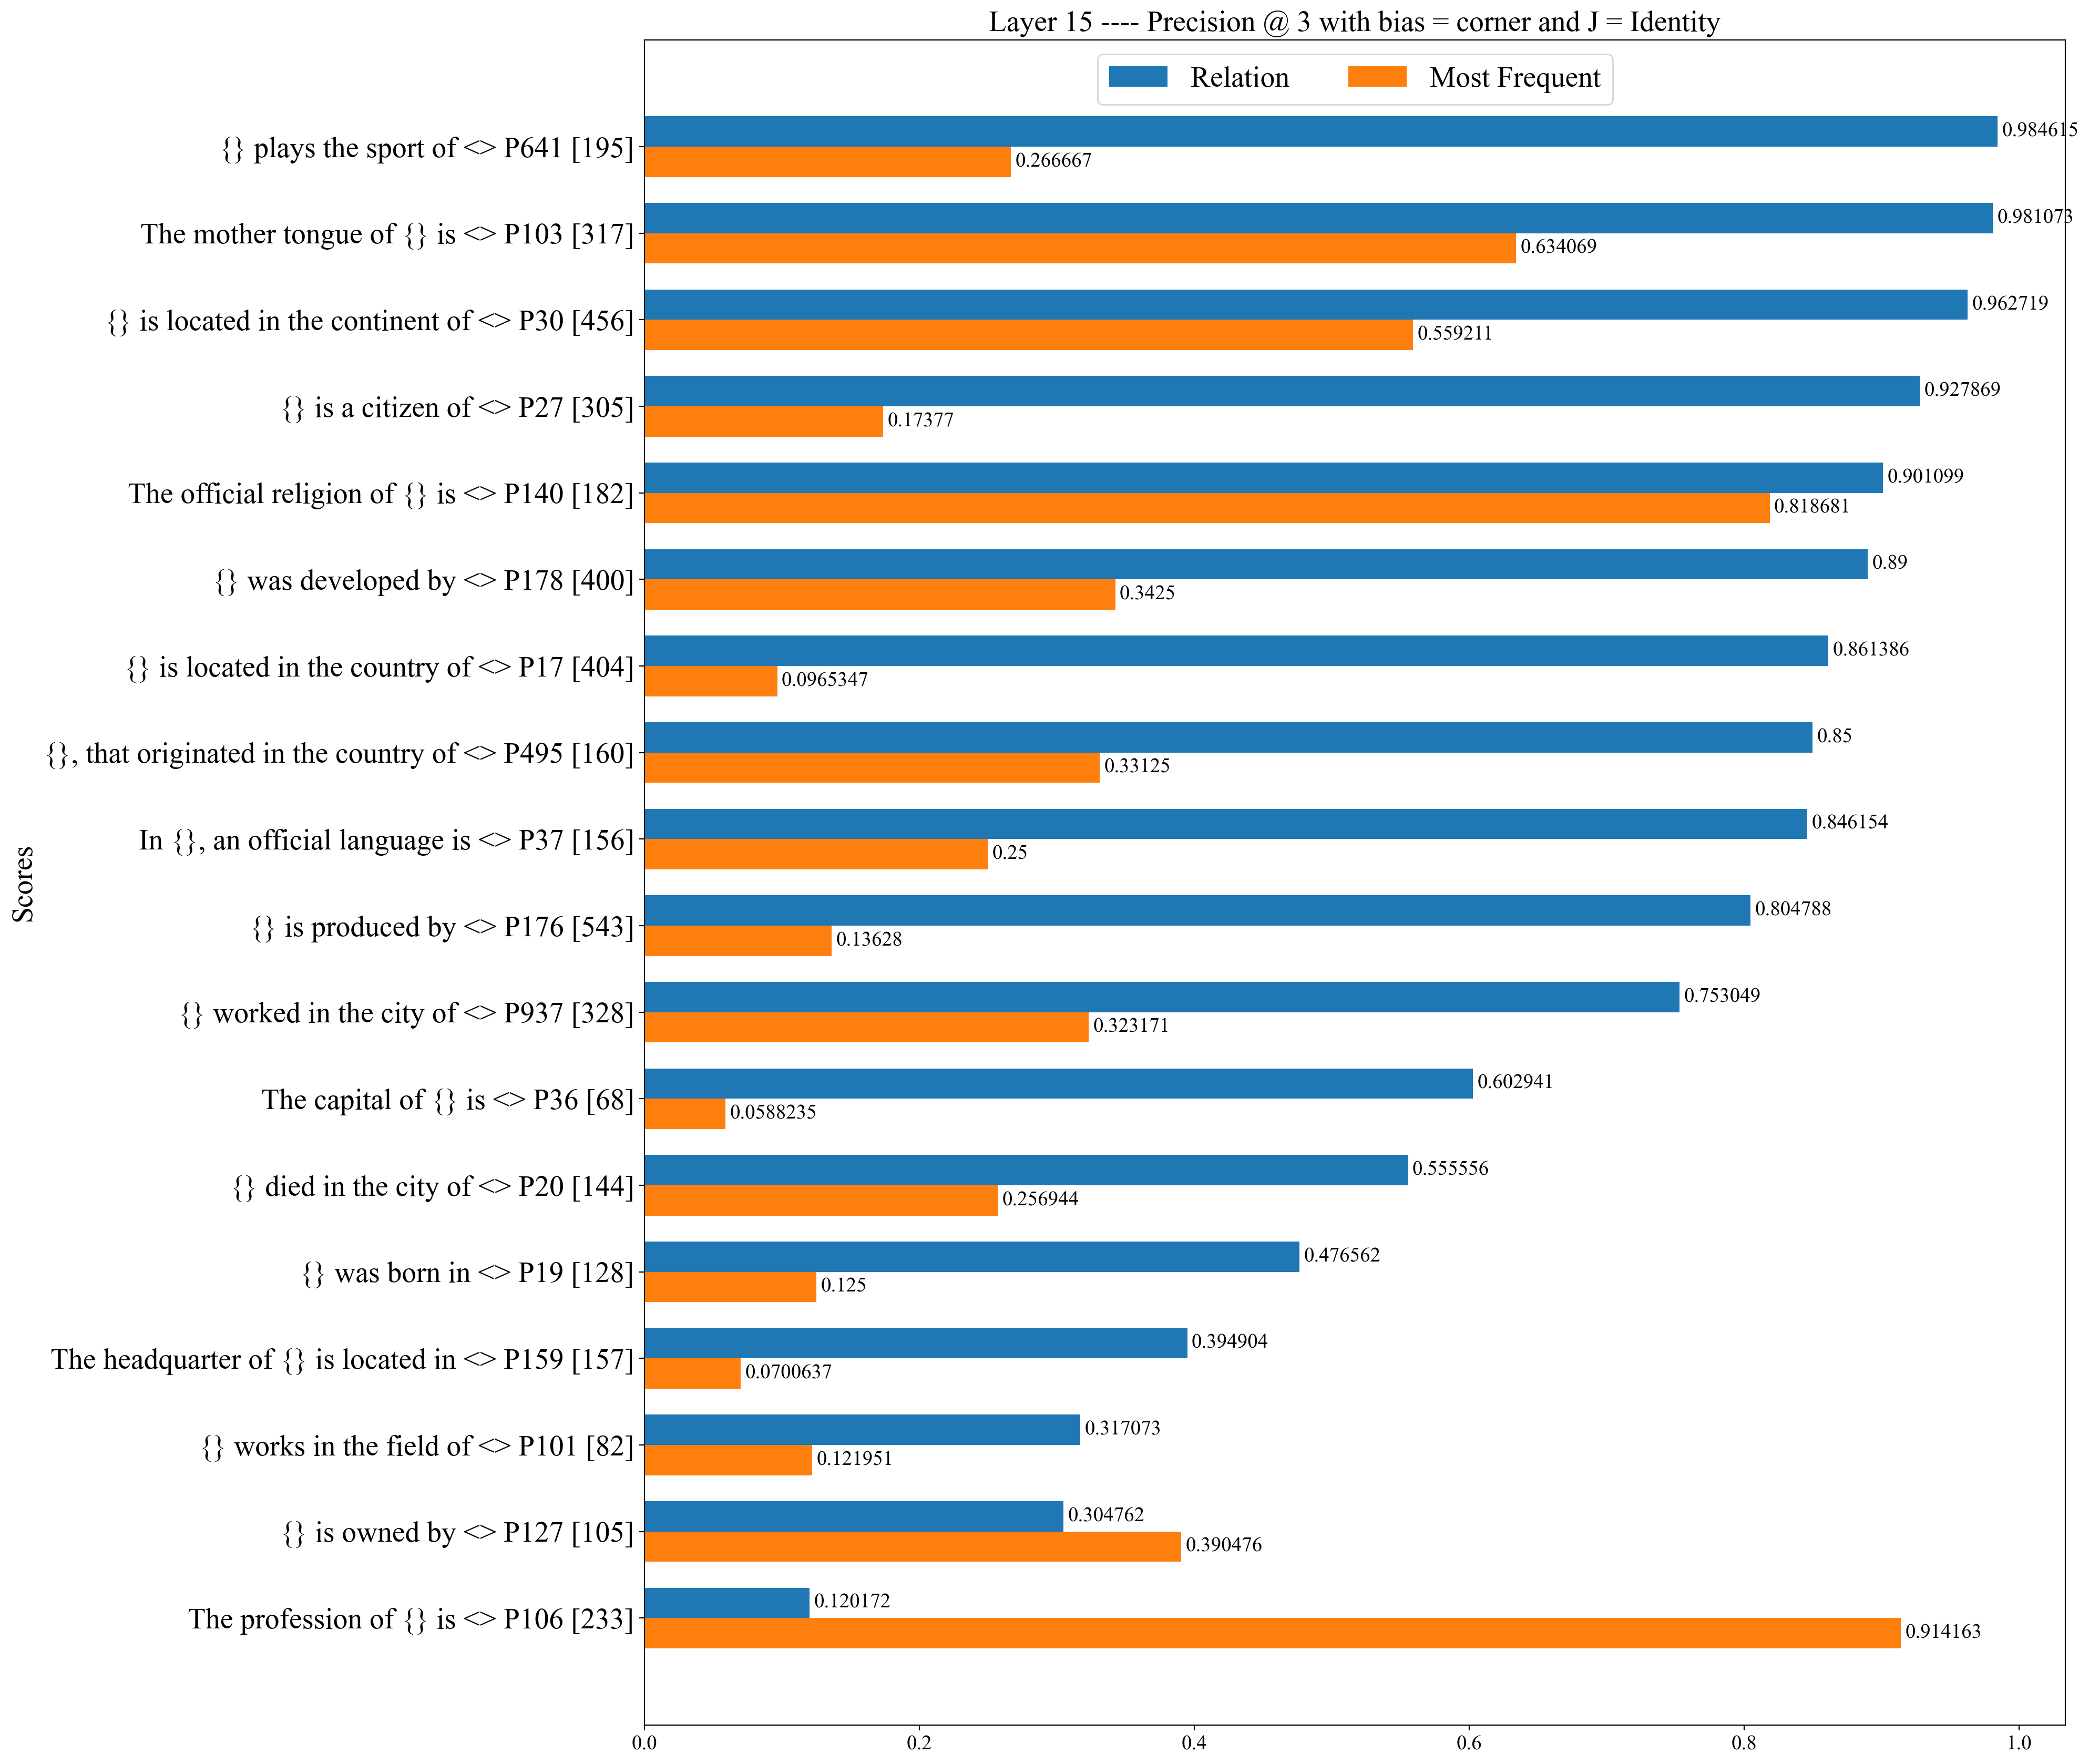

In [65]:
layer = 15
relations, corner_accuracies, freq_accuracies = get_info_for_plotting(accuracy_tracker, layer = layer)
fig = plot_performance_comparison(layer, relations, corner_accuracies, freq_accuracies, save_path="Performance/Layerwise")

# for layer in range(7, 21):
#     relations, corner_accuracies, freq_accuracies = get_info_for_plotting(accuracy_tracker, layer = layer)
#     fig = plot_performance_comparison(layer, relations, corner_accuracies, freq_accuracies, save_path="Performance/Layerwise")

In [66]:
relation_layerwise = {}
layers = list(range(7, 21))
for relation in accuracy_tracker:
    relation_layerwise[relation] = []
    for layer in layers:
        relation_layerwise[relation].append(accuracy_tracker[relation]["corner_acc"][f"layer_{layer}"])

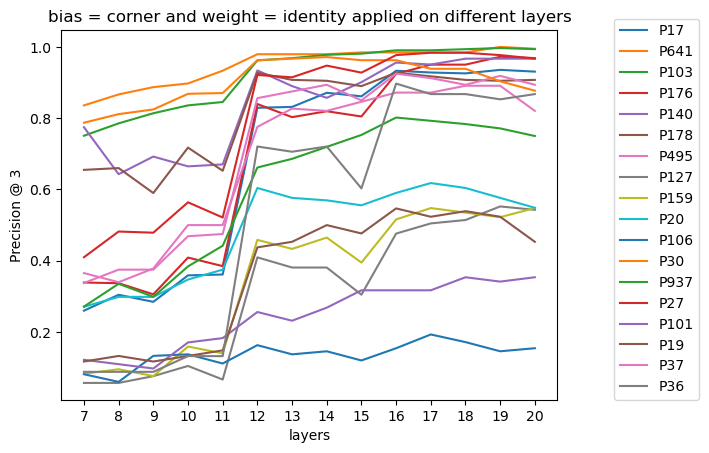

In [70]:
plt.rcdefaults()
for r in relation_layerwise:
    plt.plot(relation_layerwise[r], label = r)
plt.xticks(range(len(layers)), layers)
# plt.legend(loc = "upper right")
plt.ylabel("Precision @ 3")
plt.xlabel("layers")
plt.title("bias = corner and weight = identity applied on different layers")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("corner_identity_different_layers.png")

## Generating performance results on different configurations

In [148]:
layer = 15
number_of_runs = 10
accuracy_tracker = {}
scale_up = 70 # scale up the `single_corner` vector by a magnitue

for relation_id in relation_dct:
    print("######################################################################################################")
    print(relation_id, ":", relation_dct[relation_id]["relation"])
    print("######################################################################################################")

    with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
        correct_predictions = json.load(f)
    print(f"correctly predicted by {MODEL_NAME}: ", len(correct_predictions))
    if(len(correct_predictions) < cut_off):
        print("SKIPPING >>> len(correct_predictions): ", len(correct_predictions))
        continue

    objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
    objects = [" "+ o['target_true']['str'] for o in objects]
    objects = list(set(objects))
    print("unique objects: ", len(objects), objects[0:min(5, len(objects))])

    accuracy_tracker[relation_id] = {
        'out_of'        : len(correct_predictions),
        'identity_acc'  : {"corner":[], "simple_corner": None},
        'jacobian_acc'  : {
                            "before__ln_f"   : {"corner":[], "simple_corner": []},
                            "after__ln_f"    : {"corner":[], "simple_corner": []}
                        },
        'jacobian_plus_identity': {
                            "before__ln_f"   : {"corner":[], "simple_corner": []},
                            "after__ln_f"    : {"corner":[], "simple_corner": []}
                        },
        'freq_acc'      : None
    }

    print(f"----------------- LAYER {layer} -----------------")
    simple_corner = calculate_corner__simplified(model, tokenizer, objects, final_layer_norm, decoder)
    relation_simplified = estimate.RelationOperator(
        model = model,
        tokenizer = tokenizer,
        relation = relation_dct[relation_id]['relation'],
        layer = layer,
        weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
        bias = simple_corner * scale_up
    )
    relation_acc, freq_acc = calculate_accuracy(relation_simplified, correct_predictions)
    print(f"identity_simple >> {relation_acc}")
    accuracy_tracker[relation_id]["identity_acc"]["simple_corner"] = relation_acc
    accuracy_tracker[relation_id]["freq_acc"] = freq_acc

    for _ in tqdm(range(number_of_runs)):
        corner = calculate_corner(model, tokenizer, objects).to(model.dtype).to(model.device)
        relation_identity = estimate.RelationOperator(
            model = model,
            tokenizer = tokenizer,
            relation = relation_dct[relation_id]['relation'],
            layer = layer,
            weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
            bias = corner
        )
        identity_acc, freq_acc = calculate_accuracy(relation_identity, correct_predictions)
        accuracy_tracker[relation_id]["identity_acc"]["corner"].append(identity_acc)
        print(identity_acc)
    
    identity_corner = np.array(accuracy_tracker[relation_id]["identity_acc"]['corner'])
    identity_simple = np.array(accuracy_tracker[relation_id]["identity_acc"]['simple_corner'])

    print(f"freq_acc = {freq_acc} || identity_simple = {identity_simple} || identity_corner = {identity_corner.mean()} +/- {identity_corner.std()} >>> || out of {len(correct_predictions)}")


    simple_corner = calculate_corner__simplified(model, tokenizer, objects, final_layer_norm, decoder)
    ln_f_config = ["before__ln_f", "after__ln_f"]
    corner_config = {
        "corner": calculate_corner_average(model, tokenizer, objects).to(model.dtype).to(model.device),
        "simple_corner": simple_corner.to(model.dtype).to(model.device) * scale_up
    }

    for conf in ln_f_config:
        print(f"--------------------- {conf} ---------------------")
        cached_file = np.load(f"gpt-j/jacobians_averaged_collection/{conf}/{relation_id}.npz", allow_pickle= True)
        weights_and_biases = cached_file['weights_and_biases']
        # corner = calculate_corner(model, tokenizer, objects)

        for jb in tqdm(weights_and_biases[:number_of_runs]):
            jacobian = torch.tensor(jb['weight']).to(model.dtype).to(model.device)

            for corner in corner_config:
                relation_jacobian = estimate.RelationOperator(
                    model = model,
                    tokenizer = tokenizer,
                    relation = relation_dct[relation_id]['relation'],
                    layer = layer,
                    weight = jacobian,
                    bias = corner_config[corner]
                )
                jacobian_acc, freq_acc = calculate_accuracy(relation_jacobian, correct_predictions)
                accuracy_tracker[relation_id]["jacobian_acc"][conf][corner].append(jacobian_acc)
                print(jacobian_acc)

                relation_jacobian = estimate.RelationOperator(
                    model = model,
                    tokenizer = tokenizer,
                    relation = relation_dct[relation_id]['relation'],
                    layer = layer,
                    weight = jacobian + torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
                    bias = corner_config[corner]
                )
                jacobian_acc, freq_acc = calculate_accuracy(relation_jacobian, correct_predictions)
                accuracy_tracker[relation_id]["jacobian_plus_identity"][conf][corner].append(jacobian_acc)
                print(jacobian_acc)

    
    weight_config = ["jacobian_acc", "jacobian_plus_identity"]
    for weight in weight_config:
        for ln in ln_f_config:
            corner_acc = np.array(accuracy_tracker[relation_id][weight][ln]["corner"])
            simple_corner_acc = np.array(accuracy_tracker[relation_id][weight][ln]["simple_corner"])
            print(f"{weight} -- {ln} <<>> corner accuracy: {corner_acc.mean()} +/- {corner_acc.std()}, simple_corner: {simple_corner_acc.mean()} +/- {simple_corner_acc.std()}")
    # accuracy_tracker[relation_id]["freq_acc"]   = freq_acc
    # print(accuracy_tracker[relation_id])
    print("######################################################################################################")
    print()


######################################################################################################
P17 : {} is located in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  404
unique objects:  95 [' Pakistan', ' Cyprus', ' Israel', ' Nicaragua', ' Bahamas']
----------------- LAYER 15 -----------------
[' Pakistan', ' Cyprus', ' Israel', ' Nicaragua', ' Bahamas']
simple corner >>  [' Italy', ' Spain', ' France', ' Germany', ' India']


  0%|          | 0/404 [00:00<?, ?it/s]

identity_simple >> 0.7821782178217822


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  ['alk', ' tooth', 'sys', 'aug', '========']
final representation:  [' Ukraine', ' Argentina', ' Cyprus', ' Haiti', ' Malaysia']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8688118811881188
initial representation:  ['ime', 'ot', 'ís', 'ines', 'iss']
final representation:  [' Belgium', ' Nigeria', ' Zimbabwe', ' Ukraine', ' Switzerland']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8564356435643564
initial representation:  [' finally', 'rip', ' officially', 'ript', ' und']
final representation:  [' Belgium', ' Nigeria', ' Afghanistan', ' Tunisia', ' Malaysia']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8712871287128713
initial representation:  [' Miz', 'che', ' cru', 'kick', ' Ub']
final representation:  [' Ukraine', ' Bangladesh', ' Finland', ' Cyprus', ' Kenya']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8589108910891089
initial representation:  ['umi', 'Tro', 'ushi', 'bles', ' Promise']
final representation:  [' Ukraine', ' Morocco', ' Switzerland', ' Bangladesh', ' Nigeria']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8688118811881188
initial representation:  ['eco', 'zinski', ' Maritime', ' fin', ' Between']
final representation:  [' Finland', ' Nigeria', ' Ukraine', ' Bahrain', ' Yemen']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8564356435643564
initial representation:  ['ias', 'unit', 'SP', 'ree', 'ocks']
final representation:  [' Ukraine', ' Iceland', ' Malaysia', ' Bangladesh', ' Nigeria']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8564356435643564
initial representation:  ['iped', 'ario', 'ip', ' opp', ' arithmetic']
final representation:  [' Nigeria', ' Thailand', ' Ukraine', ' Bangladesh', ' Bosnia']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8589108910891089
initial representation:  ['ocument', 'ulia', 'ockey', '-$', ' substitute']
final representation:  [' Bangladesh', ' Finland', ' Ukraine', ' Belgium', ' Nigeria']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8589108910891089
initial representation:  ['br', 'azar', 'ad', 'az', 'atten']
final representation:  [' Nigeria', ' Finland', ' Belgium', ' Ukraine', ' Switzerland']


  0%|          | 0/404 [00:00<?, ?it/s]

0.8613861386138614
freq_acc = 0.09653465346534654 || identity_simple = 0.7821782178217822 || identity_corner = 0.8616336633663367 +/- 0.005473600095914851 >>> || out of 404
initial representation:  ['bill', ' further', ' committed', 'icket', 'mo']
final representation:  [' Nigeria', ' Finland', ' Venezuela', ' Bangladesh', ' Cyprus']
initial representation:  [' sting', ' CSI', 'Pres', 'friends', 'fy']
final representation:  [' Finland', ' Romania', ' Belgium', ' Bahrain', ' Ukraine']
initial representation:  ['ray', 'down', 'essim', 'downs', 'ork']
final representation:  [' Ukraine', ' Bangladesh', ' Finland', ' Cuba', ' Belgium']
initial representation:  ['free', 'efe', 'aum', 'iden', 'Free']
final representation:  [' Finland', ' Bangladesh', ' Cyprus', ' Nigeria', ' Ukraine']
initial representation:  ['ctor', 'acket', 'Translation', ' 364', ' Corruption']
final representation:  [' Ukraine', ' Nigeria', ' Haiti', ' Switzerland', ' Bangladesh']
--------------------- before__ln_f ------

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_2004291/659049350.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  jacobian = torch.tensor(jb['weight']).to(model.dtype).to(model.device)


  0%|          | 0/404 [00:00<?, ?it/s]

0.745049504950495


  0%|          | 0/404 [00:00<?, ?it/s]

0.9084158415841584


  0%|          | 0/404 [00:00<?, ?it/s]

0.6782178217821783


  0%|          | 0/404 [00:00<?, ?it/s]

0.8663366336633663


  0%|          | 0/404 [00:00<?, ?it/s]

0.8292079207920792


  0%|          | 0/404 [00:00<?, ?it/s]

0.9183168316831684


  0%|          | 0/404 [00:00<?, ?it/s]

0.7599009900990099


  0%|          | 0/404 [00:00<?, ?it/s]

0.8787128712871287


  0%|          | 0/404 [00:00<?, ?it/s]

0.7722772277227723


  0%|          | 0/404 [00:00<?, ?it/s]

0.9084158415841584


  0%|          | 0/404 [00:00<?, ?it/s]

0.6089108910891089


  0%|          | 0/404 [00:00<?, ?it/s]

0.8415841584158416


  0%|          | 0/404 [00:00<?, ?it/s]

0.655940594059406


  0%|          | 0/404 [00:00<?, ?it/s]

0.9034653465346535


  0%|          | 0/404 [00:00<?, ?it/s]

0.5767326732673267


  0%|          | 0/404 [00:00<?, ?it/s]

0.8316831683168316


  0%|          | 0/404 [00:00<?, ?it/s]

0.8143564356435643


  0%|          | 0/404 [00:00<?, ?it/s]

0.9108910891089109


  0%|          | 0/404 [00:00<?, ?it/s]

0.7079207920792079


  0%|          | 0/404 [00:00<?, ?it/s]

0.849009900990099


  0%|          | 0/404 [00:00<?, ?it/s]

0.7821782178217822


  0%|          | 0/404 [00:00<?, ?it/s]

0.9232673267326733


  0%|          | 0/404 [00:00<?, ?it/s]

0.7673267326732673


  0%|          | 0/404 [00:00<?, ?it/s]

0.8787128712871287


  0%|          | 0/404 [00:00<?, ?it/s]

0.5742574257425742


  0%|          | 0/404 [00:00<?, ?it/s]

0.900990099009901


  0%|          | 0/404 [00:00<?, ?it/s]

0.5173267326732673


  0%|          | 0/404 [00:00<?, ?it/s]

0.8292079207920792


  0%|          | 0/404 [00:00<?, ?it/s]

0.7128712871287128


  0%|          | 0/404 [00:00<?, ?it/s]

0.9158415841584159


  0%|          | 0/404 [00:00<?, ?it/s]

0.6287128712871287


  0%|          | 0/404 [00:00<?, ?it/s]

0.8465346534653465


  0%|          | 0/404 [00:00<?, ?it/s]

0.8168316831683168


  0%|          | 0/404 [00:00<?, ?it/s]

0.9158415841584159


  0%|          | 0/404 [00:00<?, ?it/s]

0.6757425742574258


  0%|          | 0/404 [00:00<?, ?it/s]

0.8539603960396039


  0%|          | 0/404 [00:00<?, ?it/s]

0.6831683168316832


  0%|          | 0/404 [00:00<?, ?it/s]

0.905940594059406


  0%|          | 0/404 [00:00<?, ?it/s]

0.6163366336633663


  0%|          | 0/404 [00:00<?, ?it/s]

0.8415841584158416
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

0.5841584158415841


  0%|          | 0/404 [00:00<?, ?it/s]

0.8960396039603961


  0%|          | 0/404 [00:00<?, ?it/s]

0.4504950495049505


  0%|          | 0/404 [00:00<?, ?it/s]

0.8242574257425742


  0%|          | 0/404 [00:00<?, ?it/s]

0.45544554455445546


  0%|          | 0/404 [00:00<?, ?it/s]

0.8861386138613861


  0%|          | 0/404 [00:00<?, ?it/s]

0.39603960396039606


  0%|          | 0/404 [00:00<?, ?it/s]

0.8118811881188119


  0%|          | 0/404 [00:00<?, ?it/s]

0.5816831683168316


  0%|          | 0/404 [00:00<?, ?it/s]

0.8861386138613861


  0%|          | 0/404 [00:00<?, ?it/s]

0.46782178217821785


  0%|          | 0/404 [00:00<?, ?it/s]

0.8316831683168316


  0%|          | 0/404 [00:00<?, ?it/s]

0.2301980198019802


  0%|          | 0/404 [00:00<?, ?it/s]

0.8811881188118812


  0%|          | 0/404 [00:00<?, ?it/s]

0.25495049504950495


  0%|          | 0/404 [00:00<?, ?it/s]

0.7945544554455446


  0%|          | 0/404 [00:00<?, ?it/s]

0.6435643564356436


  0%|          | 0/404 [00:00<?, ?it/s]

0.8910891089108911


  0%|          | 0/404 [00:00<?, ?it/s]

0.5099009900990099


  0%|          | 0/404 [00:00<?, ?it/s]

0.8341584158415841


  0%|          | 0/404 [00:00<?, ?it/s]

0.4975247524752475


  0%|          | 0/404 [00:00<?, ?it/s]

0.8910891089108911


  0%|          | 0/404 [00:00<?, ?it/s]

0.3910891089108911


  0%|          | 0/404 [00:00<?, ?it/s]

0.8267326732673267


  0%|          | 0/404 [00:00<?, ?it/s]

0.6039603960396039


  0%|          | 0/404 [00:00<?, ?it/s]

0.8935643564356436


  0%|          | 0/404 [00:00<?, ?it/s]

0.48514851485148514


  0%|          | 0/404 [00:00<?, ?it/s]

0.8316831683168316


  0%|          | 0/404 [00:00<?, ?it/s]

0.6584158415841584


  0%|          | 0/404 [00:00<?, ?it/s]

0.900990099009901


  0%|          | 0/404 [00:00<?, ?it/s]

0.5247524752475248


  0%|          | 0/404 [00:00<?, ?it/s]

0.8292079207920792


  0%|          | 0/404 [00:00<?, ?it/s]

0.5074257425742574


  0%|          | 0/404 [00:00<?, ?it/s]

0.8910891089108911


  0%|          | 0/404 [00:00<?, ?it/s]

0.4430693069306931


  0%|          | 0/404 [00:00<?, ?it/s]

0.8242574257425742


  0%|          | 0/404 [00:00<?, ?it/s]

0.46782178217821785


  0%|          | 0/404 [00:00<?, ?it/s]

0.8935643564356436


  0%|          | 0/404 [00:00<?, ?it/s]

0.3910891089108911


  0%|          | 0/404 [00:00<?, ?it/s]

0.8094059405940595
corner accuracy: 0.7386138613861386 +/- 0.07792274205921186, simple_corner: 0.6537128712871288 +/- 0.07534232238651703
corner accuracy: 0.523019801980198 +/- 0.11867798767402919, simple_corner: 0.4314356435643565 +/- 0.07431557129464408
corner accuracy: 0.9111386138613862 +/- 0.006683168316831689, simple_corner: 0.8517326732673267 +/- 0.016804360467815537
corner accuracy: 0.8910891089108912 +/- 0.005308814502358227, simple_corner: 0.8217821782178216 +/- 0.011973650121235434
######################################################################################################

######################################################################################################
P641 : {} plays the sport of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  195
unique objects:  5 [' basketball', ' hockey', ' baseball', ' football', ' soccer']
----------------- LAYER 15 ----

  0%|          | 0/195 [00:00<?, ?it/s]

identity_simple >> 0.9846153846153847


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  ['low', 'aber', 'Regular', 'YN', 'ures']
final representation:  [' baseball', ' basketball', ' hockey', ' soccer', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
initial representation:  [' object', ' Object', ' ex', ' command', ' Recap']
final representation:  [' basketball', ' baseball', ' soccer', ' hockey', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
initial representation:  ['287', 'DEV', ' –', 'inho', '82']
final representation:  [' baseball', ' soccer', ' hockey', ' basketball', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
initial representation:  ['edu', 'kr', 'dad', 'Tang', 'lu']
final representation:  [' basketball', ' baseball', ' hockey', ' soccer', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
initial representation:  [' Lawrence', ' Auth', 'itter', ' Bailey', ' stands']
final representation:  [' soccer', ' basketball', ' baseball', ' hockey', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
initial representation:  [' KB', 'COR', ' assemblies', ' tang', ' Gal']
final representation:  [' basketball', ' soccer', ' hockey', ' baseball', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
initial representation:  ['umb', 'ump', ' Zoom', ' oldest', ' enriched']
final representation:  [' basketball', ' hockey', ' baseball', ' soccer', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
initial representation:  [' Spa', ' Sph', ' Enter', ' Liz', ' Aud']
final representation:  [' basketball', ' soccer', ' hockey', ' baseball', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
initial representation:  ['uba', 'ward', 'ctor', 'unin', 'neg']
final representation:  [' hockey', ' soccer', ' baseball', ' basketball', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
initial representation:  ['Broad', 'ike', 'yn', 'Sl', 'ST']
final representation:  [' basketball', ' baseball', ' soccer', ' hockey', ' football']


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
freq_acc = 0.26666666666666666 || identity_simple = 0.9846153846153847 || identity_corner = 0.9846153846153847 +/- 0.0 >>> || out of 195
initial representation:  [' Pett', 'tie', ' links', ' prototypes', ' found']
final representation:  [' basketball', ' baseball', ' soccer', ' hockey', ' football']
initial representation:  [' masters', 'masters', 'ctions', ' master', ' Stern']
final representation:  [' basketball', ' baseball', ' soccer', ' hockey', ' football']
initial representation:  [' products', ' Products', 'uation', ' processors', 'Advertisement']
final representation:  [' basketball', ' soccer', ' baseball', ' hockey', ' football']
initial representation:  [' hot', 'ters', 'buy', ' type', ' fin']
final representation:  [' soccer', ' baseball', ' hockey', ' basketball', ' football']
initial representation:  [' Spe', ' Vol', ' Sim', ' Pop', ' tw']
final representation:  [' soccer', ' basketball', ' baseball', ' hockey', ' football']
--------------------- befor

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

0.9333333333333333


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.8974358974358975


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.9435897435897436


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.8923076923076924


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.9128205128205128


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.9128205128205128


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.8307692307692308


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.9435897435897436


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.9230769230769231


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.9076923076923077


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

0.9538461538461539


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.8871794871794871


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.9333333333333333


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.8564102564102564


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.9282051282051282


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.9025641025641026


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.8923076923076924


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.9692307692307692


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9897435897435898


  0%|          | 0/195 [00:00<?, ?it/s]

0.9179487179487179


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.8871794871794871


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847


  0%|          | 0/195 [00:00<?, ?it/s]

0.5743589743589743


  0%|          | 0/195 [00:00<?, ?it/s]

0.9846153846153847
corner accuracy: 0.9097435897435897 +/- 0.03121051088144191, simple_corner: 0.5743589743589743 +/- 0.0
corner accuracy: 0.9128205128205129 +/- 0.03251459996748179, simple_corner: 0.5743589743589743 +/- 0.0
corner accuracy: 0.9846153846153847 +/- 0.0, simple_corner: 0.9897435897435898 +/- 0.0
corner accuracy: 0.9846153846153847 +/- 0.0, simple_corner: 0.9861538461538462 +/- 0.0023500388179260637
######################################################################################################

######################################################################################################
P103 : The mother tongue of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  317
unique objects:  30 [' Spanish', ' Portuguese', ' Georgian', ' Greek', ' Korean']
----------------- LAYER 15 -----------------
[' Spanish', ' Portuguese', ' Georgian', ' Greek', ' Korean']
s

  0%|          | 0/317 [00:00<?, ?it/s]

identity_simple >> 0.8958990536277602


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  ['ober', 'ded', 'yer', ' Thoughts', ' demo']
final representation:  [' Romanian', ' Spanish', ' Finnish', ' Turkish', ' Japanese']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473
initial representation:  ['pu', 'pt', 'iz', 'ob', 'nl']
final representation:  [' Romanian', ' Turkish', ' Danish', ' Finnish', ' Spanish']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473
initial representation:  [' progress', ' Reno', ' specs', ' competence', ' grace']
final representation:  [' Finnish', ' Spanish', ' Romanian', ' Serbian', ' Indonesian']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9779179810725552
initial representation:  [' perfection', ' medium', ' incom', ' end', ' 295']
final representation:  [' Romanian', ' Ukrainian', ' Serbian', ' Finnish', ' Portuguese']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473
initial representation:  ['alin', ' Tek', 'oglu', 'GL', 'BRE']
final representation:  [' Ukrainian', ' Romanian', ' Finnish', ' Spanish', ' Hebrew']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9747634069400631
initial representation:  [' PP', ' proto', ' neo', ' iso', ' gar']
final representation:  [' Romanian', ' Spanish', ' Serbian', ' Finnish', ' Armenian']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473
initial representation:  ['express', 'ho', 'gl', 'lin', ' Carroll']
final representation:  [' Romanian', ' Danish', ' Greek', ' Spanish', ' Japanese']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9747634069400631
initial representation:  [' mor', ' ultr', ' sex', ' sen', 'cul']
final representation:  [' Romanian', ' Spanish', ' Japanese', ' Greek', ' Finnish']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473
initial representation:  [' early', ' experiment', ' macro', ' compact', ' automatically']
final representation:  [' Romanian', ' Spanish', ' Danish', ' Finnish', ' Italian']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9747634069400631
initial representation:  [' align', ' ms', '123', ' rev', '252']
final representation:  [' Romanian', ' Spanish', ' Finnish', ' Danish', ' Japanese']


  0%|          | 0/317 [00:00<?, ?it/s]

0.9779179810725552
freq_acc = 0.6340694006309149 || identity_simple = 0.8958990536277602 || identity_corner = 0.9785488958990536 +/- 0.002750093970688105 >>> || out of 317
initial representation:  [' recon', ' const', 'orig', ' orig', 'cki']
final representation:  [' Romanian', ' Finnish', ' Spanish', ' Japanese', ' Greek']
initial representation:  [' Den', ' Moe', ' Hyd', 'cool', ' Extrem']
final representation:  [' Romanian', ' Finnish', ' Portuguese', ' Hebrew', ' Danish']
initial representation:  [' com', ' Progress', ' Functions', ' NIC', 'EC']
final representation:  [' Ukrainian', ' Romanian', ' Danish', ' Turkish', ' Finnish']
initial representation:  ['2019', ' paste', ' pops', '1001', '------']
final representation:  [' Spanish', ' Romanian', ' Ukrainian', ' Danish', ' Greek']
initial representation:  ['ow', ' year', ' calendar', ' stabilize', ' kit']
final representation:  [' Romanian', ' Spanish', ' Turkish', ' Finnish', ' Serbian']
--------------------- before__ln_f -------

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

0.9274447949526814


  0%|          | 0/317 [00:00<?, ?it/s]

0.9842271293375394


  0%|          | 0/317 [00:00<?, ?it/s]

0.9211356466876972


  0%|          | 0/317 [00:00<?, ?it/s]

0.9747634069400631


  0%|          | 0/317 [00:00<?, ?it/s]

0.9369085173501577


  0%|          | 0/317 [00:00<?, ?it/s]

0.9779179810725552


  0%|          | 0/317 [00:00<?, ?it/s]

0.9274447949526814


  0%|          | 0/317 [00:00<?, ?it/s]

0.9463722397476341


  0%|          | 0/317 [00:00<?, ?it/s]

0.9369085173501577


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473


  0%|          | 0/317 [00:00<?, ?it/s]

0.9526813880126183


  0%|          | 0/317 [00:00<?, ?it/s]

0.9747634069400631


  0%|          | 0/317 [00:00<?, ?it/s]

0.943217665615142


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473


  0%|          | 0/317 [00:00<?, ?it/s]

0.9369085173501577


  0%|          | 0/317 [00:00<?, ?it/s]

0.9558359621451105


  0%|          | 0/317 [00:00<?, ?it/s]

0.9463722397476341


  0%|          | 0/317 [00:00<?, ?it/s]

0.9842271293375394


  0%|          | 0/317 [00:00<?, ?it/s]

0.943217665615142


  0%|          | 0/317 [00:00<?, ?it/s]

0.9747634069400631


  0%|          | 0/317 [00:00<?, ?it/s]

0.943217665615142


  0%|          | 0/317 [00:00<?, ?it/s]

0.9873817034700315


  0%|          | 0/317 [00:00<?, ?it/s]

0.9211356466876972


  0%|          | 0/317 [00:00<?, ?it/s]

0.9558359621451105


  0%|          | 0/317 [00:00<?, ?it/s]

0.9652996845425867


  0%|          | 0/317 [00:00<?, ?it/s]

0.9873817034700315


  0%|          | 0/317 [00:00<?, ?it/s]

0.9211356466876972


  0%|          | 0/317 [00:00<?, ?it/s]

0.9684542586750788


  0%|          | 0/317 [00:00<?, ?it/s]

0.9652996845425867


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473


  0%|          | 0/317 [00:00<?, ?it/s]

0.943217665615142


  0%|          | 0/317 [00:00<?, ?it/s]

0.9747634069400631


  0%|          | 0/317 [00:00<?, ?it/s]

0.9400630914826499


  0%|          | 0/317 [00:00<?, ?it/s]

0.9810725552050473


  0%|          | 0/317 [00:00<?, ?it/s]

0.9305993690851735


  0%|          | 0/317 [00:00<?, ?it/s]

0.9621451104100947


  0%|          | 0/317 [00:00<?, ?it/s]

0.9495268138801262


  0%|          | 0/317 [00:00<?, ?it/s]

0.9779179810725552


  0%|          | 0/317 [00:00<?, ?it/s]

0.9305993690851735


  0%|          | 0/317 [00:00<?, ?it/s]

0.9558359621451105
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

0.9526813880126183


  0%|          | 0/317 [00:00<?, ?it/s]

0.9905362776025236


  0%|          | 0/317 [00:00<?, ?it/s]

0.917981072555205


  0%|          | 0/317 [00:00<?, ?it/s]

0.9495268138801262


  0%|          | 0/317 [00:00<?, ?it/s]

0.9369085173501577


  0%|          | 0/317 [00:00<?, ?it/s]

0.9905362776025236


  0%|          | 0/317 [00:00<?, ?it/s]

0.917981072555205


  0%|          | 0/317 [00:00<?, ?it/s]

0.9400630914826499


  0%|          | 0/317 [00:00<?, ?it/s]

0.9463722397476341


  0%|          | 0/317 [00:00<?, ?it/s]

0.9905362776025236


  0%|          | 0/317 [00:00<?, ?it/s]

0.9211356466876972


  0%|          | 0/317 [00:00<?, ?it/s]

0.9400630914826499


  0%|          | 0/317 [00:00<?, ?it/s]

0.9621451104100947


  0%|          | 0/317 [00:00<?, ?it/s]

0.9905362776025236


  0%|          | 0/317 [00:00<?, ?it/s]

0.9148264984227129


  0%|          | 0/317 [00:00<?, ?it/s]

0.943217665615142


  0%|          | 0/317 [00:00<?, ?it/s]

0.9369085173501577


  0%|          | 0/317 [00:00<?, ?it/s]

0.9905362776025236


  0%|          | 0/317 [00:00<?, ?it/s]

0.917981072555205


  0%|          | 0/317 [00:00<?, ?it/s]

0.943217665615142


  0%|          | 0/317 [00:00<?, ?it/s]

0.9621451104100947


  0%|          | 0/317 [00:00<?, ?it/s]

0.9905362776025236


  0%|          | 0/317 [00:00<?, ?it/s]

0.9211356466876972


  0%|          | 0/317 [00:00<?, ?it/s]

0.943217665615142


  0%|          | 0/317 [00:00<?, ?it/s]

0.9495268138801262


  0%|          | 0/317 [00:00<?, ?it/s]

0.9905362776025236


  0%|          | 0/317 [00:00<?, ?it/s]

0.917981072555205


  0%|          | 0/317 [00:00<?, ?it/s]

0.9400630914826499


  0%|          | 0/317 [00:00<?, ?it/s]

0.9242902208201893


  0%|          | 0/317 [00:00<?, ?it/s]

0.9873817034700315


  0%|          | 0/317 [00:00<?, ?it/s]

0.917981072555205


  0%|          | 0/317 [00:00<?, ?it/s]

0.9495268138801262


  0%|          | 0/317 [00:00<?, ?it/s]

0.9337539432176656


  0%|          | 0/317 [00:00<?, ?it/s]

0.9905362776025236


  0%|          | 0/317 [00:00<?, ?it/s]

0.9211356466876972


  0%|          | 0/317 [00:00<?, ?it/s]

0.9369085173501577


  0%|          | 0/317 [00:00<?, ?it/s]

0.9400630914826499


  0%|          | 0/317 [00:00<?, ?it/s]

0.9905362776025236


  0%|          | 0/317 [00:00<?, ?it/s]

0.9053627760252366


  0%|          | 0/317 [00:00<?, ?it/s]

0.9337539432176656
corner accuracy: 0.9454258675078865 +/- 0.011465477504975551, simple_corner: 0.932807570977918 +/- 0.010371786891339788
corner accuracy: 0.9444794952681386 +/- 0.011735694156301756, simple_corner: 0.9173501577287068 +/- 0.0044164037854889605
corner accuracy: 0.9823343848580441 +/- 0.0032170470117304437, simple_corner: 0.964353312302839 +/- 0.009980625879846296
corner accuracy: 0.9902208201892743 +/- 0.0009463722397476281, simple_corner: 0.9419558359621452 +/- 0.004721334241986048
######################################################################################################

######################################################################################################
P176 : {} is produced by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  543
unique objects:  37 [' Airbus', ' Atari', ' Renault', ' Honda', ' Volvo']
----------------- LAYER 15 -----------

  0%|          | 0/543 [00:00<?, ?it/s]

identity_simple >> 0.7605893186003683


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' state', 'laws', 'all', 'ak', ' WP']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Toyota', ' Chrysler']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8029465930018416
initial representation:  [' Questions', ' true', 'sle', 'true', 'lin']
final representation:  [' Ford', ' Mercedes', ' Mits', ' Boeing', ' Chrysler']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8139963167587477
initial representation:  ['OL', ' Helm', 'IT', 'ineries', 'arde']
final representation:  [' Ford', ' Audi', ' Mercedes', ' Boeing', ' Toyota']


  0%|          | 0/543 [00:00<?, ?it/s]

0.7955801104972375
initial representation:  ['borough', 'ton', 'Pages', 'gate', ' linear']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Toyota', ' Chrysler']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8047882136279927
initial representation:  ['LESS', 'Application', 'hem', 'kn', 'aps']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Toyota', ' Chrysler']


  0%|          | 0/543 [00:00<?, ?it/s]

0.7992633517495396
initial representation:  [' Muss', ' Bug', 'ilee', 'itudes', 'rix']
final representation:  [' Ford', ' Mercedes', ' Audi', ' Toyota', ' Mits']


  0%|          | 0/543 [00:00<?, ?it/s]

0.7974217311233885
initial representation:  [' imp', ' effects', ' effect', ' Human', ' co']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Toyota', ' Chrysler']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8029465930018416
initial representation:  [' Jar', ' accused', ' lawyer', ' chance', ' tu']
final representation:  [' Ford', ' Mercedes', ' Toyota', ' Chrysler', ' Volkswagen']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8084714548802947
initial representation:  [' divine', ' requ', ' Jim', ' Spe', ' requested']
final representation:  [' Ford', ' Mercedes', ' Toyota', ' Chrysler', ' Boeing']


  0%|          | 0/543 [00:00<?, ?it/s]

0.8066298342541437
initial representation:  ['oad', 'OO', ' pad', ' level', ' sol']
final representation:  [' Ford', ' Mercedes', ' Audi', ' Boeing', ' Volkswagen']


  0%|          | 0/543 [00:00<?, ?it/s]

0.7955801104972375
freq_acc = 0.13627992633517497 || identity_simple = 0.7605893186003683 || identity_corner = 0.8027624309392266 +/- 0.005673267698250256 >>> || out of 543
initial representation:  [' Faust', 'ley', ' Troy', ' Pear', ' Bain']
final representation:  [' Ford', ' Mercedes', ' Volkswagen', ' Chrysler', ' Boeing']
initial representation:  ['ama', 'item', '________________________________________________________________', ' mean', ' -->']
final representation:  [' Ford', ' Mercedes', ' Toyota', ' Boeing', ' Chrysler']
initial representation:  [' Shape', 'yard', ' Custom', 'aid', 'struct']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Chrysler', ' Toyota']
initial representation:  [' conting', ' stain', ' Malf', ' residue', ' forward']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Toyota', ' Chrysler']
initial representation:  ['�', 'vert', 'rad', 've', 'name']
final representation:  [' Ford', ' Mercedes', ' Boeing', ' Toyota', ' Chrysler']
---------

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

0.053406998158379376


  0%|          | 0/543 [00:00<?, ?it/s]

0.7974217311233885


  0%|          | 0/543 [00:00<?, ?it/s]

0.27255985267034993


  0%|          | 0/543 [00:00<?, ?it/s]

0.7569060773480663


  0%|          | 0/543 [00:00<?, ?it/s]

0.4143646408839779


  0%|          | 0/543 [00:00<?, ?it/s]

0.8710865561694291


  0%|          | 0/543 [00:00<?, ?it/s]

0.3848987108655617


  0%|          | 0/543 [00:00<?, ?it/s]

0.7974217311233885


  0%|          | 0/543 [00:00<?, ?it/s]

0.19705340699815838


  0%|          | 0/543 [00:00<?, ?it/s]

0.8066298342541437


  0%|          | 0/543 [00:00<?, ?it/s]

0.27071823204419887


  0%|          | 0/543 [00:00<?, ?it/s]

0.7771639042357275


  0%|          | 0/543 [00:00<?, ?it/s]

0.4880294659300184


  0%|          | 0/543 [00:00<?, ?it/s]

0.8710865561694291


  0%|          | 0/543 [00:00<?, ?it/s]

0.39594843462246776


  0%|          | 0/543 [00:00<?, ?it/s]

0.7974217311233885


  0%|          | 0/543 [00:00<?, ?it/s]

0.4125230202578269


  0%|          | 0/543 [00:00<?, ?it/s]

0.8637200736648251


  0%|          | 0/543 [00:00<?, ?it/s]

0.3848987108655617


  0%|          | 0/543 [00:00<?, ?it/s]

0.7863720073664825


  0%|          | 0/543 [00:00<?, ?it/s]

0.31860036832412525


  0%|          | 0/543 [00:00<?, ?it/s]

0.8674033149171271


  0%|          | 0/543 [00:00<?, ?it/s]

0.4106813996316759


  0%|          | 0/543 [00:00<?, ?it/s]

0.8232044198895028


  0%|          | 0/543 [00:00<?, ?it/s]

0.03314917127071823


  0%|          | 0/543 [00:00<?, ?it/s]

0.8103130755064457


  0%|          | 0/543 [00:00<?, ?it/s]

0.281767955801105


  0%|          | 0/543 [00:00<?, ?it/s]

0.7679558011049724


  0%|          | 0/543 [00:00<?, ?it/s]

0.45119705340699817


  0%|          | 0/543 [00:00<?, ?it/s]

0.8858195211786372


  0%|          | 0/543 [00:00<?, ?it/s]

0.4088397790055249


  0%|          | 0/543 [00:00<?, ?it/s]

0.8232044198895028


  0%|          | 0/543 [00:00<?, ?it/s]

0.4843462246777164


  0%|          | 0/543 [00:00<?, ?it/s]

0.8655616942909761


  0%|          | 0/543 [00:00<?, ?it/s]

0.4125230202578269


  0%|          | 0/543 [00:00<?, ?it/s]

0.8139963167587477


  0%|          | 0/543 [00:00<?, ?it/s]

0.5414364640883977


  0%|          | 0/543 [00:00<?, ?it/s]

0.8784530386740331


  0%|          | 0/543 [00:00<?, ?it/s]

0.3885819521178637


  0%|          | 0/543 [00:00<?, ?it/s]

0.7900552486187845
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

0.44014732965009207


  0%|          | 0/543 [00:00<?, ?it/s]

0.856353591160221


  0%|          | 0/543 [00:00<?, ?it/s]

0.39779005524861877


  0%|          | 0/543 [00:00<?, ?it/s]

0.7955801104972375


  0%|          | 0/543 [00:00<?, ?it/s]

0.13259668508287292


  0%|          | 0/543 [00:00<?, ?it/s]

0.7992633517495396


  0%|          | 0/543 [00:00<?, ?it/s]

0.3885819521178637


  0%|          | 0/543 [00:00<?, ?it/s]

0.7753222836095764


  0%|          | 0/543 [00:00<?, ?it/s]

0.14917127071823205


  0%|          | 0/543 [00:00<?, ?it/s]

0.8213627992633518


  0%|          | 0/543 [00:00<?, ?it/s]

0.3425414364640884


  0%|          | 0/543 [00:00<?, ?it/s]

0.7753222836095764


  0%|          | 0/543 [00:00<?, ?it/s]

0.12154696132596685


  0%|          | 0/543 [00:00<?, ?it/s]

0.8195211786372008


  0%|          | 0/543 [00:00<?, ?it/s]

0.3756906077348066


  0%|          | 0/543 [00:00<?, ?it/s]

0.7716390423572744


  0%|          | 0/543 [00:00<?, ?it/s]

0.44751381215469616


  0%|          | 0/543 [00:00<?, ?it/s]

0.860036832412523


  0%|          | 0/543 [00:00<?, ?it/s]

0.39042357274401474


  0%|          | 0/543 [00:00<?, ?it/s]

0.7992633517495396


  0%|          | 0/543 [00:00<?, ?it/s]

0.4567219152854512


  0%|          | 0/543 [00:00<?, ?it/s]

0.848987108655617


  0%|          | 0/543 [00:00<?, ?it/s]

0.39042357274401474


  0%|          | 0/543 [00:00<?, ?it/s]

0.7955801104972375


  0%|          | 0/543 [00:00<?, ?it/s]

0.003683241252302026


  0%|          | 0/543 [00:00<?, ?it/s]

0.7974217311233885


  0%|          | 0/543 [00:00<?, ?it/s]

0.27071823204419887


  0%|          | 0/543 [00:00<?, ?it/s]

0.7605893186003683


  0%|          | 0/543 [00:00<?, ?it/s]

0.35911602209944754


  0%|          | 0/543 [00:00<?, ?it/s]

0.858195211786372


  0%|          | 0/543 [00:00<?, ?it/s]

0.39594843462246776


  0%|          | 0/543 [00:00<?, ?it/s]

0.7900552486187845


  0%|          | 0/543 [00:00<?, ?it/s]

0.11786372007366483


  0%|          | 0/543 [00:00<?, ?it/s]

0.8029465930018416


  0%|          | 0/543 [00:00<?, ?it/s]

0.27255985267034993


  0%|          | 0/543 [00:00<?, ?it/s]

0.7697974217311234


  0%|          | 0/543 [00:00<?, ?it/s]

0.15101289134438306


  0%|          | 0/543 [00:00<?, ?it/s]

0.8213627992633518


  0%|          | 0/543 [00:00<?, ?it/s]

0.3406998158379374


  0%|          | 0/543 [00:00<?, ?it/s]

0.7826887661141805
corner accuracy: 0.33941068139963165 +/- 0.17425867465156497, simple_corner: 0.3611418047882136 +/- 0.05725900321808268
corner accuracy: 0.23793738489871089 +/- 0.1602290381334343, simple_corner: 0.3565377532228361 +/- 0.046700245629747214
corner accuracy: 0.8517495395948436 +/- 0.03147232125663229, simple_corner: 0.7933701657458564 +/- 0.02129920043432923
corner accuracy: 0.8285451197053406 +/- 0.02393327539982749, simple_corner: 0.7815837937384899 +/- 0.012386866829318763
######################################################################################################

######################################################################################################
P140 : The official religion of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  182
unique objects:  9 [' Islam', ' Zen', ' Buddhism', ' Muslim', ' Christian']
----------------- LAYER 15 --

  0%|          | 0/182 [00:00<?, ?it/s]

identity_simple >> 0.9175824175824175


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  ['stone', 'pet', 'inals', 'cb', 'irs']
final representation:  [' Christianity', ' Scientology', ' Islam', ' Catholicism', ' Muslim']


  0%|          | 0/182 [00:00<?, ?it/s]

0.945054945054945
initial representation:  ['java', 'pha', 'insk', 'andum', 'unit']
final representation:  [' Christianity', ' Scientology', ' Catholicism', ' Islam', ' Muslim']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9175824175824175
initial representation:  [' constant', ' prefix', ' confidence', 'brand', ' rad']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Catholicism', ' Christian']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9285714285714286
initial representation:  [' //', '//', 'DB', 'lio', 'java']
final representation:  [' Scientology', ' Christianity', ' Muslim', ' Catholicism', ' Judaism']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341
initial representation:  ['quer', 'OA', 'AD', 'GA', 'inqu']
final representation:  [' Scientology', ' Christianity', ' Catholicism', ' Muslim', ' Islam']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341
initial representation:  [' directions', ' supplies', 'ity', ' direction', ' Dial']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Catholicism', ' Islam']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9395604395604396
initial representation:  ['ACH', 'rew', 'rape', 'rap', 'op']
final representation:  [' Scientology', ' Christianity', ' Muslim', ' Catholicism', ' Christian']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9285714285714286
initial representation:  ['Types', 'omen', 'ova', 'Pages', 'EH']
final representation:  [' Scientology', ' Christianity', ' Muslim', ' Catholicism', ' Judaism']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9175824175824175
initial representation:  ['column', ' Anders', 'Column', ' 820', 'Figure']
final representation:  [' Scientology', ' Christianity', ' Muslim', ' Catholicism', ' Judaism']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9285714285714286
initial representation:  ['ICS', 'ETS', 'ETA', 'ics', 'ET']
final representation:  [' Scientology', ' Christianity', ' Muslim', ' Catholicism', ' Judaism']


  0%|          | 0/182 [00:00<?, ?it/s]

0.9120879120879121
freq_acc = 0.8186813186813187 || identity_simple = 0.9175824175824175 || identity_corner = 0.9285714285714286 +/- 0.009828870230768314 >>> || out of 182
initial representation:  ['esc', 'apt', 'olic', 'aut', 'eas']
final representation:  [' Christianity', ' Scientology', ' Catholicism', ' Judaism', ' Muslim']
initial representation:  ['iter', 'ack', 'CM', 'idan', 'awn']
final representation:  [' Scientology', ' Christianity', ' Muslim', ' Catholicism', ' Judaism']
initial representation:  ['eni', ' succeed', 'annie', 'ez', ' coalition']
final representation:  [' Scientology', ' Christianity', ' Catholicism', ' Muslim', ' Islam']
initial representation:  ['These', 'Fig', 'Rom', 'Reference', 'H']
final representation:  [' Scientology', ' Christianity', ' Muslim', ' Catholicism', ' Islam']
initial representation:  ['FUN', 'WH', '----------', 'Soul', 'Dash']
final representation:  [' Scientology', ' Muslim', ' Christianity', ' Catholicism', ' Judaism']
------------------

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

0.989010989010989


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

0.945054945054945


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616


  0%|          | 0/182 [00:00<?, ?it/s]

0.989010989010989


  0%|          | 0/182 [00:00<?, ?it/s]

0.9175824175824175


  0%|          | 0/182 [00:00<?, ?it/s]

0.9505494505494505


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616


  0%|          | 0/182 [00:00<?, ?it/s]

0.978021978021978


  0%|          | 0/182 [00:00<?, ?it/s]

0.9285714285714286


  0%|          | 0/182 [00:00<?, ?it/s]

0.9505494505494505


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616


  0%|          | 0/182 [00:00<?, ?it/s]

0.978021978021978


  0%|          | 0/182 [00:00<?, ?it/s]

0.9395604395604396


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616


  0%|          | 0/182 [00:00<?, ?it/s]

0.989010989010989


  0%|          | 0/182 [00:00<?, ?it/s]

0.9175824175824175


  0%|          | 0/182 [00:00<?, ?it/s]

0.9505494505494505


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616


  0%|          | 0/182 [00:00<?, ?it/s]

0.9835164835164835


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

0.9505494505494505


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616


  0%|          | 0/182 [00:00<?, ?it/s]

0.967032967032967


  0%|          | 0/182 [00:00<?, ?it/s]

0.9285714285714286


  0%|          | 0/182 [00:00<?, ?it/s]

0.9505494505494505


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616


  0%|          | 0/182 [00:00<?, ?it/s]

0.967032967032967


  0%|          | 0/182 [00:00<?, ?it/s]

0.9230769230769231


  0%|          | 0/182 [00:00<?, ?it/s]

0.9505494505494505


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616


  0%|          | 0/182 [00:00<?, ?it/s]

0.978021978021978


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616


  0%|          | 0/182 [00:00<?, ?it/s]

0.967032967032967


  0%|          | 0/182 [00:00<?, ?it/s]

0.9230769230769231


  0%|          | 0/182 [00:00<?, ?it/s]

0.9505494505494505


  0%|          | 0/182 [00:00<?, ?it/s]

0.9615384615384616
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

1.0


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.9010989010989011


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

0.9945054945054945


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.9010989010989011


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

1.0


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.8956043956043956


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

1.0


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.8901098901098901


  0%|          | 0/182 [00:00<?, ?it/s]

0.9285714285714286


  0%|          | 0/182 [00:00<?, ?it/s]

0.9945054945054945


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.8956043956043956


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

1.0


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.8846153846153846


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

1.0


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.8901098901098901


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

1.0


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.9010989010989011


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

1.0


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.9010989010989011


  0%|          | 0/182 [00:00<?, ?it/s]

0.9340659340659341


  0%|          | 0/182 [00:00<?, ?it/s]

1.0


  0%|          | 0/182 [00:00<?, ?it/s]

0.9560439560439561


  0%|          | 0/182 [00:00<?, ?it/s]

0.8956043956043956


  0%|          | 0/182 [00:00<?, ?it/s]

0.9285714285714286
corner accuracy: 0.9785714285714286 +/- 0.008670183427505229, simple_corner: 0.951098901098901 +/- 0.002958881762161842
corner accuracy: 0.9989010989010989 +/- 0.0021978021978021904, simple_corner: 0.8956043956043956 +/- 0.005494505494505519
corner accuracy: 0.9280219780219781 +/- 0.0071428571428571504, simple_corner: 0.9615384615384615 +/- 1.1102230246251565e-16
corner accuracy: 0.956043956043956 +/- 1.1102230246251565e-16, simple_corner: 0.932967032967033 +/- 0.00219780219780219
######################################################################################################

######################################################################################################
P178 : {} was developed by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  400
unique objects:  19 [' Airbus', ' Atari', ' IBM', ' Adobe', ' Yahoo']
----------------- LAYER 15 ------------

  0%|          | 0/400 [00:00<?, ?it/s]

identity_simple >> 0.9075


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  ['ifer', 'ria', 'buff', 'Wolf', 'ifier']
final representation:  [' Nintendo', ' IBM', ' Nokia', ' Samsung', ' Airbus']


  0%|          | 0/400 [00:00<?, ?it/s]

0.9075
initial representation:  ['fold', 'enn', 'main', 'alm', 'pill']
final representation:  [' Nintendo', ' Sony', ' Samsung', ' IBM', ' Airbus']


  0%|          | 0/400 [00:00<?, ?it/s]

0.915
initial representation:  ['ank', 'walk', 'scan', 'ther', 'late']
final representation:  [' Airbus', ' Samsung', ' Nokia', ' Nintendo', ' IBM']


  0%|          | 0/400 [00:00<?, ?it/s]

0.91
initial representation:  ['ax', 'end', 'ende', 'resp', 'ender']
final representation:  [' Airbus', ' Samsung', ' Nokia', ' Nintendo', ' IBM']


  0%|          | 0/400 [00:00<?, ?it/s]

0.9025
initial representation:  ['ment', ' extrap', ' glide', ' census', 'ling']
final representation:  [' Samsung', ' IBM', ' Sony', ' Nokia', ' Airbus']


  0%|          | 0/400 [00:00<?, ?it/s]

0.905
initial representation:  [' lowest', ' expected', 'generic', ' tender', ' generic']
final representation:  [' Nintendo', ' Nokia', ' Airbus', ' Sony', ' Samsung']


  0%|          | 0/400 [00:00<?, ?it/s]

0.8975
initial representation:  ['antic', 'CR', '<|endoftext|>', ' NS', ' navig']
final representation:  [' Samsung', ' Nintendo', ' IBM', ' Nokia', ' Sony']


  0%|          | 0/400 [00:00<?, ?it/s]

0.9
initial representation:  [' prop', ' EMP', 'OTH', 'oth', 'leg']
final representation:  [' Samsung', ' Sony', ' Nokia', ' IBM', ' Nintendo']


  0%|          | 0/400 [00:00<?, ?it/s]

0.895
initial representation:  ['g', 'kin', ' block', 'q', 'mort']
final representation:  [' Samsung', ' Nokia', ' Airbus', ' Nintendo', ' IBM']


  0%|          | 0/400 [00:00<?, ?it/s]

0.89
initial representation:  ['cos', ' constitution', 'Cos', '[]', ' []']
final representation:  [' Airbus', ' Nintendo', ' Samsung', ' Atari', ' Nokia']


  0%|          | 0/400 [00:00<?, ?it/s]

0.8975
freq_acc = 0.3425 || identity_simple = 0.9075 || identity_corner = 0.9019999999999999 +/- 0.007141428428542858 >>> || out of 400
initial representation:  [' Sym', 'owers', ' Trip', ' Winn', ' Municip']
final representation:  [' Microsoft', ' Nintendo', ' Sony', ' Samsung', ' Nokia']
initial representation:  ['ment', 'Neg', 'INTER', 'aires', 'Ho']
final representation:  [' Airbus', ' Nintendo', ' Nokia', ' Samsung', ' Adobe']
initial representation:  ['back', ' back', 'GI', 'FK', 'cation']
final representation:  [' Airbus', ' Sony', ' Nintendo', ' IBM', ' Samsung']
initial representation:  ['VILLE', 'oola', 'vich', '�', 'Figure']
final representation:  [' Nokia', ' Samsung', ' Nintendo', ' Airbus', ' IBM']
initial representation:  [' env', ' Ma', ' Mother', '!', " ['"]
final representation:  [' Samsung', ' Airbus', ' Nokia', ' Nintendo', ' IBM']
--------------------- before__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

0.455


  0%|          | 0/400 [00:00<?, ?it/s]

0.9025


  0%|          | 0/400 [00:00<?, ?it/s]

0.6725


  0%|          | 0/400 [00:00<?, ?it/s]

0.91


  0%|          | 0/400 [00:00<?, ?it/s]

0.79


  0%|          | 0/400 [00:00<?, ?it/s]

0.9275


  0%|          | 0/400 [00:00<?, ?it/s]

0.6725


  0%|          | 0/400 [00:00<?, ?it/s]

0.9125


  0%|          | 0/400 [00:00<?, ?it/s]

0.3575


  0%|          | 0/400 [00:00<?, ?it/s]

0.9075


  0%|          | 0/400 [00:00<?, ?it/s]

0.6575


  0%|          | 0/400 [00:00<?, ?it/s]

0.9


  0%|          | 0/400 [00:00<?, ?it/s]

0.26


  0%|          | 0/400 [00:00<?, ?it/s]

0.9075


  0%|          | 0/400 [00:00<?, ?it/s]

0.715


  0%|          | 0/400 [00:00<?, ?it/s]

0.895


  0%|          | 0/400 [00:00<?, ?it/s]

0.495


  0%|          | 0/400 [00:00<?, ?it/s]

0.9275


  0%|          | 0/400 [00:00<?, ?it/s]

0.6825


  0%|          | 0/400 [00:00<?, ?it/s]

0.895


  0%|          | 0/400 [00:00<?, ?it/s]

0.5575


  0%|          | 0/400 [00:00<?, ?it/s]

0.92


  0%|          | 0/400 [00:00<?, ?it/s]

0.6925


  0%|          | 0/400 [00:00<?, ?it/s]

0.895


  0%|          | 0/400 [00:00<?, ?it/s]

0.29


  0%|          | 0/400 [00:00<?, ?it/s]

0.91


  0%|          | 0/400 [00:00<?, ?it/s]

0.7275


  0%|          | 0/400 [00:00<?, ?it/s]

0.8875


  0%|          | 0/400 [00:00<?, ?it/s]

0.615


  0%|          | 0/400 [00:00<?, ?it/s]

0.9075


  0%|          | 0/400 [00:00<?, ?it/s]

0.695


  0%|          | 0/400 [00:00<?, ?it/s]

0.9125


  0%|          | 0/400 [00:00<?, ?it/s]

0.745


  0%|          | 0/400 [00:00<?, ?it/s]

0.91


  0%|          | 0/400 [00:00<?, ?it/s]

0.6875


  0%|          | 0/400 [00:00<?, ?it/s]

0.9125


  0%|          | 0/400 [00:00<?, ?it/s]

0.245


  0%|          | 0/400 [00:00<?, ?it/s]

0.8975


  0%|          | 0/400 [00:00<?, ?it/s]

0.66


  0%|          | 0/400 [00:00<?, ?it/s]

0.91
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

0.405


  0%|          | 0/400 [00:00<?, ?it/s]

0.905


  0%|          | 0/400 [00:00<?, ?it/s]

0.6575


  0%|          | 0/400 [00:00<?, ?it/s]

0.8975


  0%|          | 0/400 [00:00<?, ?it/s]

0.2625


  0%|          | 0/400 [00:00<?, ?it/s]

0.9


  0%|          | 0/400 [00:00<?, ?it/s]

0.6625


  0%|          | 0/400 [00:00<?, ?it/s]

0.895


  0%|          | 0/400 [00:00<?, ?it/s]

0.5325


  0%|          | 0/400 [00:00<?, ?it/s]

0.9025


  0%|          | 0/400 [00:00<?, ?it/s]

0.6575


  0%|          | 0/400 [00:00<?, ?it/s]

0.905


  0%|          | 0/400 [00:00<?, ?it/s]

0.275


  0%|          | 0/400 [00:00<?, ?it/s]

0.9075


  0%|          | 0/400 [00:00<?, ?it/s]

0.6575


  0%|          | 0/400 [00:00<?, ?it/s]

0.9025


  0%|          | 0/400 [00:00<?, ?it/s]

0.2925


  0%|          | 0/400 [00:00<?, ?it/s]

0.905


  0%|          | 0/400 [00:00<?, ?it/s]

0.6575


  0%|          | 0/400 [00:00<?, ?it/s]

0.8975


  0%|          | 0/400 [00:00<?, ?it/s]

0.1425


  0%|          | 0/400 [00:00<?, ?it/s]

0.8975


  0%|          | 0/400 [00:00<?, ?it/s]

0.66


  0%|          | 0/400 [00:00<?, ?it/s]

0.9


  0%|          | 0/400 [00:00<?, ?it/s]

0.35


  0%|          | 0/400 [00:00<?, ?it/s]

0.905


  0%|          | 0/400 [00:00<?, ?it/s]

0.6575


  0%|          | 0/400 [00:00<?, ?it/s]

0.8975


  0%|          | 0/400 [00:00<?, ?it/s]

0.5025


  0%|          | 0/400 [00:00<?, ?it/s]

0.9125


  0%|          | 0/400 [00:00<?, ?it/s]

0.66


  0%|          | 0/400 [00:00<?, ?it/s]

0.9


  0%|          | 0/400 [00:00<?, ?it/s]

0.3875


  0%|          | 0/400 [00:00<?, ?it/s]

0.91


  0%|          | 0/400 [00:00<?, ?it/s]

0.6575


  0%|          | 0/400 [00:00<?, ?it/s]

0.9


  0%|          | 0/400 [00:00<?, ?it/s]

0.465


  0%|          | 0/400 [00:00<?, ?it/s]

0.905


  0%|          | 0/400 [00:00<?, ?it/s]

0.66


  0%|          | 0/400 [00:00<?, ?it/s]

0.9125
corner accuracy: 0.48100000000000004 +/- 0.18604502143298543, simple_corner: 0.68625 +/- 0.021338052863370642
corner accuracy: 0.36150000000000004 +/- 0.11512601791080936, simple_corner: 0.65875 +/- 0.0016770509831248563
corner accuracy: 0.91175 +/- 0.009555757426808208, simple_corner: 0.9029999999999999 +/- 0.009000000000000001
corner accuracy: 0.9049999999999999 +/- 0.004183300132670381, simple_corner: 0.90075 +/- 0.00475
######################################################################################################

######################################################################################################
P495 : {}, that originated in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  160
unique objects:  67 [' Canada', ' Scotland', ' Laos', ' Ecuador', ' Chad']
----------------- LAYER 15 -----------------
[' Canada', ' Scotland', ' Laos', ' Ecuad

  0%|          | 0/160 [00:00<?, ?it/s]

identity_simple >> 0.75625


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' simplify', 'ype', 'ashi', 'fur', ' simplified']
final representation:  [' Nigeria', ' Thailand', ' Ireland', ' Lebanon', ' Chile']


  0%|          | 0/160 [00:00<?, ?it/s]

0.86875
initial representation:  ['cp', 'ou', ' tabs', 'ongs', 'msg']
final representation:  [' Thailand', ' Nigeria', ' Ireland', ' Ukraine', ' Romania']


  0%|          | 0/160 [00:00<?, ?it/s]

0.875
initial representation:  ['cu', 'Invalid', 'Collection', 'het', 'imar']
final representation:  [' Thailand', ' Nigeria', ' Spain', ' Lebanon', ' Belgium']


  0%|          | 0/160 [00:00<?, ?it/s]

0.8625
initial representation:  ['VERSION', ' standard', 'broad', ' buoy', 'ready']
final representation:  [' Nigeria', ' Belgium', ' Ireland', ' Bangladesh', ' Thailand']


  0%|          | 0/160 [00:00<?, ?it/s]

0.86875
initial representation:  ['NG', 'policy', 'mon', 'NN', 'ict']
final representation:  [' Nigeria', ' Belgium', ' Ukraine', ' Ireland', ' Thailand']


  0%|          | 0/160 [00:00<?, ?it/s]

0.85625
initial representation:  [' Hel', ' disclose', ' hel', 'arte', 'hel']
final representation:  [' Ireland', ' Finland', ' Belgium', ' Thailand', ' Lebanon']


  0%|          | 0/160 [00:00<?, ?it/s]

0.85
initial representation:  [' Beer', 'leck', 'INAL', ' Gerard', '.--']
final representation:  [' Belgium', ' Nigeria', ' Thailand', ' Ireland', ' Ukraine']


  0%|          | 0/160 [00:00<?, ?it/s]

0.86875
initial representation:  ['ilt', 'iren', 'Walk', 'ijah', ' ].']
final representation:  [' Nigeria', ' Thailand', ' Ukraine', ' Colombia', ' Ireland']


  0%|          | 0/160 [00:00<?, ?it/s]

0.8625
initial representation:  ['holm', ' Bord', ' Lug', ' cor', ' Pens']
final representation:  [' Nigeria', ' Thailand', ' Lebanon', ' Ukraine', ' Finland']


  0%|          | 0/160 [00:00<?, ?it/s]

0.8625
initial representation:  ['TOR', 'needed', 'prot', 'tor', 'tra']
final representation:  [' Nigeria', ' Belgium', ' Thailand', ' Colombia', ' Ukraine']


  0%|          | 0/160 [00:00<?, ?it/s]

0.85625
freq_acc = 0.33125 || identity_simple = 0.75625 || identity_corner = 0.8631249999999999 +/- 0.007098635432250359 >>> || out of 160
initial representation:  ['Micro', 'KER', 'Wind', 'Nich', ' Ocean']
final representation:  [' Nigeria', ' Ireland', ' Belgium', ' Thailand', ' Malaysia']
initial representation:  [' Chick', ' Merc', ' Con', ' Aut', ' Items']
final representation:  [' Thailand', ' Ireland', ' Belgium', ' Lebanon', ' Colombia']
initial representation:  [' Palo', 'ront', 'igil', 'tif', 'om']
final representation:  [' Nigeria', ' Thailand', ' Belgium', ' Ireland', ' Romania']
initial representation:  ['esp', ' mess', 'â', 'enery', ' defaults']
final representation:  [' Thailand', ' Ireland', ' Colombia', ' Belgium', ' Nigeria']
initial representation:  ['age', 'iem', 'iel', 'OO', ' Past']
final representation:  [' Thailand', ' Nigeria', ' Belgium', ' Ukraine', ' Ireland']
--------------------- before__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

0.81875


  0%|          | 0/160 [00:00<?, ?it/s]

0.9125


  0%|          | 0/160 [00:00<?, ?it/s]

0.53125


  0%|          | 0/160 [00:00<?, ?it/s]

0.8375


  0%|          | 0/160 [00:00<?, ?it/s]

0.7


  0%|          | 0/160 [00:00<?, ?it/s]

0.8875


  0%|          | 0/160 [00:00<?, ?it/s]

0.39375


  0%|          | 0/160 [00:00<?, ?it/s]

0.8


  0%|          | 0/160 [00:00<?, ?it/s]

0.6875


  0%|          | 0/160 [00:00<?, ?it/s]

0.9125


  0%|          | 0/160 [00:00<?, ?it/s]

0.30625


  0%|          | 0/160 [00:00<?, ?it/s]

0.8


  0%|          | 0/160 [00:00<?, ?it/s]

0.8875


  0%|          | 0/160 [00:00<?, ?it/s]

0.9125


  0%|          | 0/160 [00:00<?, ?it/s]

0.63125


  0%|          | 0/160 [00:00<?, ?it/s]

0.86875


  0%|          | 0/160 [00:00<?, ?it/s]

0.7


  0%|          | 0/160 [00:00<?, ?it/s]

0.9


  0%|          | 0/160 [00:00<?, ?it/s]

0.45625


  0%|          | 0/160 [00:00<?, ?it/s]

0.81875


  0%|          | 0/160 [00:00<?, ?it/s]

0.725


  0%|          | 0/160 [00:00<?, ?it/s]

0.89375


  0%|          | 0/160 [00:00<?, ?it/s]

0.30625


  0%|          | 0/160 [00:00<?, ?it/s]

0.80625


  0%|          | 0/160 [00:00<?, ?it/s]

0.825


  0%|          | 0/160 [00:00<?, ?it/s]

0.9125


  0%|          | 0/160 [00:00<?, ?it/s]

0.56875


  0%|          | 0/160 [00:00<?, ?it/s]

0.85


  0%|          | 0/160 [00:00<?, ?it/s]

0.7125


  0%|          | 0/160 [00:00<?, ?it/s]

0.9


  0%|          | 0/160 [00:00<?, ?it/s]

0.50625


  0%|          | 0/160 [00:00<?, ?it/s]

0.83125


  0%|          | 0/160 [00:00<?, ?it/s]

0.74375


  0%|          | 0/160 [00:00<?, ?it/s]

0.90625


  0%|          | 0/160 [00:00<?, ?it/s]

0.40625


  0%|          | 0/160 [00:00<?, ?it/s]

0.8125


  0%|          | 0/160 [00:00<?, ?it/s]

0.85


  0%|          | 0/160 [00:00<?, ?it/s]

0.91875


  0%|          | 0/160 [00:00<?, ?it/s]

0.675


  0%|          | 0/160 [00:00<?, ?it/s]

0.86875
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

0.68125


  0%|          | 0/160 [00:00<?, ?it/s]

0.89375


  0%|          | 0/160 [00:00<?, ?it/s]

0.25625


  0%|          | 0/160 [00:00<?, ?it/s]

0.7875


  0%|          | 0/160 [00:00<?, ?it/s]

0.675


  0%|          | 0/160 [00:00<?, ?it/s]

0.89375


  0%|          | 0/160 [00:00<?, ?it/s]

0.25


  0%|          | 0/160 [00:00<?, ?it/s]

0.79375


  0%|          | 0/160 [00:00<?, ?it/s]

0.45625


  0%|          | 0/160 [00:00<?, ?it/s]

0.8875


  0%|          | 0/160 [00:00<?, ?it/s]

0.11875


  0%|          | 0/160 [00:00<?, ?it/s]

0.7875


  0%|          | 0/160 [00:00<?, ?it/s]

0.40625


  0%|          | 0/160 [00:00<?, ?it/s]

0.89375


  0%|          | 0/160 [00:00<?, ?it/s]

0.075


  0%|          | 0/160 [00:00<?, ?it/s]

0.7875


  0%|          | 0/160 [00:00<?, ?it/s]

0.25625


  0%|          | 0/160 [00:00<?, ?it/s]

0.8875


  0%|          | 0/160 [00:00<?, ?it/s]

0.0625


  0%|          | 0/160 [00:00<?, ?it/s]

0.775


  0%|          | 0/160 [00:00<?, ?it/s]

0.70625


  0%|          | 0/160 [00:00<?, ?it/s]

0.90625


  0%|          | 0/160 [00:00<?, ?it/s]

0.29375


  0%|          | 0/160 [00:00<?, ?it/s]

0.8


  0%|          | 0/160 [00:00<?, ?it/s]

0.0375


  0%|          | 0/160 [00:00<?, ?it/s]

0.88125


  0%|          | 0/160 [00:00<?, ?it/s]

0.0625


  0%|          | 0/160 [00:00<?, ?it/s]

0.775


  0%|          | 0/160 [00:00<?, ?it/s]

0.40625


  0%|          | 0/160 [00:00<?, ?it/s]

0.8875


  0%|          | 0/160 [00:00<?, ?it/s]

0.13125


  0%|          | 0/160 [00:00<?, ?it/s]

0.775


  0%|          | 0/160 [00:00<?, ?it/s]

0.48125


  0%|          | 0/160 [00:00<?, ?it/s]

0.8875


  0%|          | 0/160 [00:00<?, ?it/s]

0.20625


  0%|          | 0/160 [00:00<?, ?it/s]

0.78125


  0%|          | 0/160 [00:00<?, ?it/s]

0.3375


  0%|          | 0/160 [00:00<?, ?it/s]

0.8875


  0%|          | 0/160 [00:00<?, ?it/s]

0.075


  0%|          | 0/160 [00:00<?, ?it/s]

0.78125
corner accuracy: 0.765 +/- 0.06927075501248706, simple_corner: 0.478125 +/- 0.12078034039114147
corner accuracy: 0.4443750000000001 +/- 0.19865662114563412, simple_corner: 0.153125 +/- 0.08538744418824117
corner accuracy: 0.9056249999999999 +/- 0.00945796621901346, simple_corner: 0.8293750000000001 +/- 0.025007811279678188
corner accuracy: 0.8906249999999998 +/- 0.006404344228724769, simple_corner: 0.784375 +/- 0.008028270361665698
######################################################################################################

######################################################################################################
P127 : {} is owned by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  105
unique objects:  109 [' Indiana', ' HBO', ' IBM', ' Cyprus', ' BP']
----------------- LAYER 15 -----------------
[' Indiana', ' HBO', ' IBM', ' Cyprus', ' BP']
simple corner >

  0%|          | 0/105 [00:00<?, ?it/s]

identity_simple >> 0.01904761904761905


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' burden', ' shadow', ' burdens', ' cinem', ' pen']
final representation:  [' Japan', ' Arizona', ' Singapore', ' Florida', ' Amsterdam']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3047619047619048
initial representation:  ['scale', 'OTH', 'til', 'sw', 'FM']
final representation:  [' Japan', ' Singapore', ' Florida', ' Arizona', ' Boston']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3333333333333333
initial representation:  ['item', 'question', 'quest', 'work', 'phone']
final representation:  [' Japan', ' Arizona', ' Singapore', ' Amsterdam', ' Florida']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3238095238095238
initial representation:  ['Fu', 'outer', 'Alias', 'Program', 'fu']
final representation:  [' Japan', ' Singapore', ' Moscow', ' Miami', ' Florida']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3047619047619048
initial representation:  ['wealth', 'arre', 'eu', 'ne', 'bread']
final representation:  [' Japan', ' Miami', ' Arizona', ' Amsterdam', ' San']


  0%|          | 0/105 [00:00<?, ?it/s]

0.2857142857142857
initial representation:  [' lowly', 'und', ' melting', 'che', 'iders']
final representation:  [' Moscow', ' Japan', ' Singapore', ' Georgia', ' Dubai']


  0%|          | 0/105 [00:00<?, ?it/s]

0.34285714285714286
initial representation:  [' uncond', 'asio', 'aj', ' Led', 'aji']
final representation:  [' San', ' Japan', ' Arizona', ' Singapore', ' Amsterdam']


  0%|          | 0/105 [00:00<?, ?it/s]

0.29523809523809524
initial representation:  ['iop', 'library', ' dem', 'ilk', 'lay']
final representation:  [' Japan', ' Arizona', ' Boston', ' Amsterdam', ' Singapore']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3142857142857143
initial representation:  ['ways', ' lives', ' awareness', 'ANG', ' Ventures']
final representation:  [' Amsterdam', ' Florida', ' Boston', ' Singapore', ' San']


  0%|          | 0/105 [00:00<?, ?it/s]

0.2857142857142857
initial representation:  [' variations', ' rig', ' boards', 'hm', ' Nav']
final representation:  [' San', ' Arizona', ' Japan', ' Rio', ' Florida']


  0%|          | 0/105 [00:00<?, ?it/s]

0.3333333333333333
freq_acc = 0.3904761904761905 || identity_simple = 0.01904761904761905 || identity_corner = 0.31238095238095237 +/- 0.019424836242258225 >>> || out of 105
initial representation:  [' overw', ' national', ' pending', ' nationals', ' citizen']
final representation:  [' Japan', ' Arizona', ' Singapore', ' Florida', ' Honda']
initial representation:  ['mate', ' clean', 'BAT', 'Clean', 'bum']
final representation:  [' Japan', ' Amsterdam', ' Singapore', ' Arizona', ' Moscow']
initial representation:  [' far', ' bast', 'dr', 'status', ' asleep']
final representation:  [' Japan', ' Amsterdam', ' Arizona', ' Moscow', ' Boston']
initial representation:  ['wild', ' wild', 'rous', ' Journals', ' experimental']
final representation:  [' Japan', ' Arizona', ' Florida', ' Columbia', ' Moscow']
initial representation:  ['SEC', 'gow', '442', 'pay', ',[']
final representation:  [' Japan', ' Arizona', ' Singapore', ' Moscow', ' Tokyo']
--------------------- before__ln_f --------------

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

0.047619047619047616


  0%|          | 0/105 [00:00<?, ?it/s]

0.3238095238095238


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.01904761904761905


  0%|          | 0/105 [00:00<?, ?it/s]

0.01904761904761905


  0%|          | 0/105 [00:00<?, ?it/s]

0.38095238095238093


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.01904761904761905


  0%|          | 0/105 [00:00<?, ?it/s]

0.11428571428571428


  0%|          | 0/105 [00:00<?, ?it/s]

0.4


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.06666666666666667


  0%|          | 0/105 [00:00<?, ?it/s]

0.0380952380952381


  0%|          | 0/105 [00:00<?, ?it/s]

0.47619047619047616


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.06666666666666667


  0%|          | 0/105 [00:00<?, ?it/s]

0.06666666666666667


  0%|          | 0/105 [00:00<?, ?it/s]

0.4


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.05714285714285714


  0%|          | 0/105 [00:00<?, ?it/s]

0.17142857142857143


  0%|          | 0/105 [00:00<?, ?it/s]

0.5333333333333333


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.08571428571428572


  0%|          | 0/105 [00:00<?, ?it/s]

0.08571428571428572


  0%|          | 0/105 [00:00<?, ?it/s]

0.49523809523809526


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.0761904761904762


  0%|          | 0/105 [00:00<?, ?it/s]

0.09523809523809523


  0%|          | 0/105 [00:00<?, ?it/s]

0.3619047619047619


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.047619047619047616


  0%|          | 0/105 [00:00<?, ?it/s]

0.09523809523809523


  0%|          | 0/105 [00:00<?, ?it/s]

0.4666666666666667


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.047619047619047616


  0%|          | 0/105 [00:00<?, ?it/s]

0.08571428571428572


  0%|          | 0/105 [00:00<?, ?it/s]

0.41904761904761906


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.06666666666666667
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

0.009523809523809525


  0%|          | 0/105 [00:00<?, ?it/s]

0.42857142857142855


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.0380952380952381


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.3904761904761905


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.01904761904761905


  0%|          | 0/105 [00:00<?, ?it/s]

0.01904761904761905


  0%|          | 0/105 [00:00<?, ?it/s]

0.41904761904761906


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.02857142857142857


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.3142857142857143


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.009523809523809525


  0%|          | 0/105 [00:00<?, ?it/s]

0.06666666666666667


  0%|          | 0/105 [00:00<?, ?it/s]

0.47619047619047616


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.05714285714285714


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.2857142857142857


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.009523809523809525


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.34285714285714286


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.01904761904761905


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.4


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.02857142857142857


  0%|          | 0/105 [00:00<?, ?it/s]

0.047619047619047616


  0%|          | 0/105 [00:00<?, ?it/s]

0.4666666666666667


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.0380952380952381


  0%|          | 0/105 [00:00<?, ?it/s]

0.01904761904761905


  0%|          | 0/105 [00:00<?, ?it/s]

0.4380952380952381


  0%|          | 0/105 [00:00<?, ?it/s]

0.0


  0%|          | 0/105 [00:00<?, ?it/s]

0.047619047619047616
corner accuracy: 0.0819047619047619 +/- 0.04089697248301692, simple_corner: 0.0 +/- 0.0
corner accuracy: 0.01619047619047619 +/- 0.022151815904024777, simple_corner: 0.0 +/- 0.0
corner accuracy: 0.4257142857142857 +/- 0.06202186725777118, simple_corner: 0.05523809523809524 +/- 0.021210530906019133
corner accuracy: 0.3961904761904762 +/- 0.06041429153201412, simple_corner: 0.029523809523809525 +/- 0.015028317941009046
######################################################################################################

######################################################################################################
P159 : The headquarter of {} is located in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  157
unique objects:  178 [' Brunswick', ' Perth', ' Lima', ' Jerusalem', ' Israel']
----------------- LAYER 15 -----------------
[' Brunswick', ' Perth', ' Lima

  0%|          | 0/157 [00:00<?, ?it/s]

identity_simple >> 0.4394904458598726


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  ['Agent', '70', '25', 'Flag', 'Bug']
final representation:  [' Portland', ' San', ' Lebanon', ' Naples', ' Birmingham']


  0%|          | 0/157 [00:00<?, ?it/s]

0.39490445859872614
initial representation:  ['Check', 'po', 'Tim', 'General', 'Bern']
final representation:  [' Washington', ' Naples', ' South', ' Berlin', ' Birmingham']


  0%|          | 0/157 [00:00<?, ?it/s]

0.35668789808917195
initial representation:  [' essential', ' important', ' retro', ' end', ' ATP']
final representation:  [' South', ' Birmingham', ' Lebanon', ' Berlin', ' Washington']


  0%|          | 0/157 [00:00<?, ?it/s]

0.3630573248407643
initial representation:  ['qualified', ' craw', 'qual', 'inqu', ' qualified']
final representation:  [' Washington', ' South', ' Windsor', ' Richmond', ' Berlin']


  0%|          | 0/157 [00:00<?, ?it/s]

0.36942675159235666
initial representation:  ['uke', 'Us', 'oud', 'ick', 'erial']
final representation:  [' Washington', ' South', ' Richmond', ' Lebanon', ' Portland']


  0%|          | 0/157 [00:00<?, ?it/s]

0.3503184713375796
initial representation:  ['aris', 'ara', 'ality', 'akh', 'FO']
final representation:  [' Lebanon', ' South', ' Richmond', ' Washington', ' San']


  0%|          | 0/157 [00:00<?, ?it/s]

0.3630573248407643
initial representation:  ['lo', 'Advertisement', 'pre', 'file', 'acc']
final representation:  [' Washington', ' Denmark', ' Birmingham', ' Athens', ' Lebanon']


  0%|          | 0/157 [00:00<?, ?it/s]

0.4140127388535032
initial representation:  ['union', 'enne', 'still', 'update', ' still']
final representation:  [' Richmond', ' South', ' San', ' Birmingham', ' Oakland']


  0%|          | 0/157 [00:00<?, ?it/s]

0.35668789808917195
initial representation:  ['mem', 'Loop', 'canon', 'SR', 'Church']
final representation:  [' Athens', ' Washington', ' Birmingham', ' Rochester', ' Kansas']


  0%|          | 0/157 [00:00<?, ?it/s]

0.39490445859872614
initial representation:  ['repeat', 'search', 'cong', 'common', 'www']
final representation:  [' Lebanon', ' Washington', ' San', ' South', ' Birmingham']


  0%|          | 0/157 [00:00<?, ?it/s]

0.36942675159235666
freq_acc = 0.07006369426751592 || identity_simple = 0.4394904458598726 || identity_corner = 0.3732484076433121 +/- 0.019776018721350368 >>> || out of 157
initial representation:  [' di', 'etz', 'kil', ' pending', 'Break']
final representation:  [' Washington', ' Richmond', ' San', ' South', ' Birmingham']
initial representation:  [' district', ' answer', 'osi', 'aya', ' THEN']
final representation:  [' Washington', ' San', ' Lebanon', ' Berlin', ' South']
initial representation:  [' unnamed', ' effect', ' viral', ' disorder', ' synd']
final representation:  [' Washington', ' Richmond', ' Lebanon', ' Windsor', ' Birmingham']
initial representation:  [' bomb', 'TO', ' spoiled', 'alle', 'isle']
final representation:  [' South', ' Newport', ' Washington', ' Richmond', ' Birmingham']
initial representation:  ['isd', ' business', ' charges', 'ool', ' ex']
final representation:  [' Richmond', ' Lebanon', ' Washington', ' Moscow', ' Birmingham']
--------------------- before

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.6624203821656051


  0%|          | 0/157 [00:00<?, ?it/s]

0.6815286624203821


  0%|          | 0/157 [00:00<?, ?it/s]

0.5732484076433121


  0%|          | 0/157 [00:00<?, ?it/s]

0.7006369426751592


  0%|          | 0/157 [00:00<?, ?it/s]

0.732484076433121


  0%|          | 0/157 [00:00<?, ?it/s]

0.7133757961783439


  0%|          | 0/157 [00:00<?, ?it/s]

0.5923566878980892


  0%|          | 0/157 [00:00<?, ?it/s]

0.7006369426751592


  0%|          | 0/157 [00:00<?, ?it/s]

0.7070063694267515


  0%|          | 0/157 [00:00<?, ?it/s]

0.6687898089171974


  0%|          | 0/157 [00:00<?, ?it/s]

0.5987261146496815


  0%|          | 0/157 [00:00<?, ?it/s]

0.6878980891719745


  0%|          | 0/157 [00:00<?, ?it/s]

0.7388535031847133


  0%|          | 0/157 [00:00<?, ?it/s]

0.7261146496815286


  0%|          | 0/157 [00:00<?, ?it/s]

0.6242038216560509


  0%|          | 0/157 [00:00<?, ?it/s]

0.7197452229299363


  0%|          | 0/157 [00:00<?, ?it/s]

0.7133757961783439


  0%|          | 0/157 [00:00<?, ?it/s]

0.7006369426751592


  0%|          | 0/157 [00:00<?, ?it/s]

0.5923566878980892


  0%|          | 0/157 [00:00<?, ?it/s]

0.6942675159235668


  0%|          | 0/157 [00:00<?, ?it/s]

0.7197452229299363


  0%|          | 0/157 [00:00<?, ?it/s]

0.7070063694267515


  0%|          | 0/157 [00:00<?, ?it/s]

0.5987261146496815


  0%|          | 0/157 [00:00<?, ?it/s]

0.6942675159235668


  0%|          | 0/157 [00:00<?, ?it/s]

0.7006369426751592


  0%|          | 0/157 [00:00<?, ?it/s]

0.6751592356687898


  0%|          | 0/157 [00:00<?, ?it/s]

0.5732484076433121


  0%|          | 0/157 [00:00<?, ?it/s]

0.6815286624203821


  0%|          | 0/157 [00:00<?, ?it/s]

0.6624203821656051


  0%|          | 0/157 [00:00<?, ?it/s]

0.6815286624203821


  0%|          | 0/157 [00:00<?, ?it/s]

0.6242038216560509


  0%|          | 0/157 [00:00<?, ?it/s]

0.7261146496815286


  0%|          | 0/157 [00:00<?, ?it/s]

0.6687898089171974


  0%|          | 0/157 [00:00<?, ?it/s]

0.6942675159235668


  0%|          | 0/157 [00:00<?, ?it/s]

0.6050955414012739


  0%|          | 0/157 [00:00<?, ?it/s]

0.7070063694267515


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127


  0%|          | 0/157 [00:00<?, ?it/s]

0.6751592356687898


  0%|          | 0/157 [00:00<?, ?it/s]

0.5859872611464968


  0%|          | 0/157 [00:00<?, ?it/s]

0.7006369426751592
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

0.6496815286624203


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127


  0%|          | 0/157 [00:00<?, ?it/s]

0.5414012738853503


  0%|          | 0/157 [00:00<?, ?it/s]

0.6815286624203821


  0%|          | 0/157 [00:00<?, ?it/s]

0.7197452229299363


  0%|          | 0/157 [00:00<?, ?it/s]

0.6624203821656051


  0%|          | 0/157 [00:00<?, ?it/s]

0.554140127388535


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127


  0%|          | 0/157 [00:00<?, ?it/s]

0.7515923566878981


  0%|          | 0/157 [00:00<?, ?it/s]

0.6687898089171974


  0%|          | 0/157 [00:00<?, ?it/s]

0.5605095541401274


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127


  0%|          | 0/157 [00:00<?, ?it/s]

0.6687898089171974


  0%|          | 0/157 [00:00<?, ?it/s]

0.6496815286624203


  0%|          | 0/157 [00:00<?, ?it/s]

0.5031847133757962


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127


  0%|          | 0/157 [00:00<?, ?it/s]

0.6305732484076433


  0%|          | 0/157 [00:00<?, ?it/s]

0.6114649681528662


  0%|          | 0/157 [00:00<?, ?it/s]

0.4840764331210191


  0%|          | 0/157 [00:00<?, ?it/s]

0.6242038216560509


  0%|          | 0/157 [00:00<?, ?it/s]

0.6815286624203821


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127


  0%|          | 0/157 [00:00<?, ?it/s]

0.5159235668789809


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127


  0%|          | 0/157 [00:00<?, ?it/s]

0.6878980891719745


  0%|          | 0/157 [00:00<?, ?it/s]

0.6942675159235668


  0%|          | 0/157 [00:00<?, ?it/s]

0.554140127388535


  0%|          | 0/157 [00:00<?, ?it/s]

0.6496815286624203


  0%|          | 0/157 [00:00<?, ?it/s]

0.7133757961783439


  0%|          | 0/157 [00:00<?, ?it/s]

0.6751592356687898


  0%|          | 0/157 [00:00<?, ?it/s]

0.554140127388535


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127


  0%|          | 0/157 [00:00<?, ?it/s]

0.7388535031847133


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127


  0%|          | 0/157 [00:00<?, ?it/s]

0.535031847133758


  0%|          | 0/157 [00:00<?, ?it/s]

0.6624203821656051


  0%|          | 0/157 [00:00<?, ?it/s]

0.643312101910828


  0%|          | 0/157 [00:00<?, ?it/s]

0.6369426751592356


  0%|          | 0/157 [00:00<?, ?it/s]

0.5286624203821656


  0%|          | 0/157 [00:00<?, ?it/s]

0.6560509554140127
corner accuracy: 0.6961783439490445 +/- 0.029609272099794793, simple_corner: 0.5968152866242038 +/- 0.016863951967992005
corner accuracy: 0.6885350318471337 +/- 0.03931025254575663, simple_corner: 0.5331210191082802 +/- 0.024010288949007336
corner accuracy: 0.6923566878980891 +/- 0.01802671553896166, simple_corner: 0.7012738853503184 +/- 0.012881368417934191
corner accuracy: 0.6566878980891719 +/- 0.021019108280254772, simple_corner: 0.6554140127388535 +/- 0.013192557437712086
######################################################################################################

######################################################################################################
P20 : {} died in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  144
unique objects:  169 [' Brunswick', ' Greenland', ' Nottingham', ' Oxford', ' Perth']
----------------- LAYER 1

  0%|          | 0/144 [00:00<?, ?it/s]

identity_simple >> 0.5972222222222222


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' available', 'inate', 'ains', 'as', 'chip']
final representation:  [' South', ' Lebanon', ' Cairo', ' Washington', ' Cape']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5763888888888888
initial representation:  ['ores', 'orm', 'oves', 'ium', 'PUT']
final representation:  [' Albany', ' Lebanon', ' Florida', ' Moscow', ' Cairo']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5763888888888888
initial representation:  [' document', ' rise', ' bur', ' support', ' tag']
final representation:  [' Lebanon', ' Cairo', ' Boston', ' Albany', ' Washington']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5694444444444444
initial representation:  ['Termin', 'Compl', ' ELECT', 'apa', 'Dual']
final representation:  [' Albany', ' Lebanon', ' Cairo', ' Washington', ' Athens']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5763888888888888
initial representation:  ['ors', 'av', 'forth', ' faire', 'avi']
final representation:  [' Lebanon', ' Moscow', ' North', ' Albany', ' Cairo']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5486111111111112
initial representation:  ['Body', 'Author', 'Complete', 'Allows', 'Choice']
final representation:  [' Lebanon', ' Moscow', ' Cairo', ' Cape', ' Boston']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5694444444444444
initial representation:  ['Rating', ' special', ' crab', ' alpha', ' dem']
final representation:  [' Lebanon', ' South', ' Manila', ' Alaska', ' Albany']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5555555555555556
initial representation:  [' dim', ' using', ';', ' ded', 'ax']
final representation:  [' Lebanon', ' Albany', ' South', ' Cape', ' Cairo']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5625
initial representation:  [' rel', 'coded', ' Write', ' Else', ' Rice']
final representation:  [' Lebanon', ' Washington', ' Cairo', ' South', ' Birmingham']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5555555555555556
initial representation:  [' Variety', ' OPER', ' stage', 'RAM', 'IZE']
final representation:  [' Lebanon', ' South', ' Georgia', ' Cairo', ' Manila']


  0%|          | 0/144 [00:00<?, ?it/s]

0.5833333333333334
freq_acc = 0.2569444444444444 || identity_simple = 0.5972222222222222 || identity_corner = 0.567361111111111 +/- 0.010780676872402771 >>> || out of 144
initial representation:  ['Posts', 'JR', '================', 'Break', 'BRE']
final representation:  [' Cairo', ' Moscow', ' Alaska', ' Cape', ' Lebanon']
initial representation:  [' hyp', ' return', ' noisy', ' single', ' capital']
final representation:  [' Washington', ' Cairo', ' Florida', ' Lebanon', ' Moscow']
initial representation:  ['IR', ' contrary', 'draft', 'mie', ' drafted']
final representation:  [' Lebanon', ' Florida', ' Cairo', ' Maine', ' Lake']
initial representation:  [' mix', 'wall', ' breakdown', ' trunc', 'json']
final representation:  [' Lebanon', ' Moscow', ' Washington', ' Rochester', ' Florida']
initial representation:  ['warning', 'ub', 'ail', 'status', 'nex']
final representation:  [' Cape', ' Lebanon', ' Albany', ' Alaska', ' Florida']
--------------------- before__ln_f --------------------

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

0.0763888888888889


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.4444444444444444


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.4305555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.6597222222222222


  0%|          | 0/144 [00:00<?, ?it/s]

0.4583333333333333


  0%|          | 0/144 [00:00<?, ?it/s]

0.6319444444444444


  0%|          | 0/144 [00:00<?, ?it/s]

0.4861111111111111


  0%|          | 0/144 [00:00<?, ?it/s]

0.6736111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.4791666666666667


  0%|          | 0/144 [00:00<?, ?it/s]

0.6388888888888888


  0%|          | 0/144 [00:00<?, ?it/s]

0.041666666666666664


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.4375


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.04861111111111111


  0%|          | 0/144 [00:00<?, ?it/s]

0.5972222222222222


  0%|          | 0/144 [00:00<?, ?it/s]

0.4305555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.6041666666666666


  0%|          | 0/144 [00:00<?, ?it/s]

0.2222222222222222


  0%|          | 0/144 [00:00<?, ?it/s]

0.6597222222222222


  0%|          | 0/144 [00:00<?, ?it/s]

0.4444444444444444


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.4027777777777778


  0%|          | 0/144 [00:00<?, ?it/s]

0.625


  0%|          | 0/144 [00:00<?, ?it/s]

0.4652777777777778


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.5902777777777778


  0%|          | 0/144 [00:00<?, ?it/s]

0.6875


  0%|          | 0/144 [00:00<?, ?it/s]

0.4722222222222222


  0%|          | 0/144 [00:00<?, ?it/s]

0.6319444444444444


  0%|          | 0/144 [00:00<?, ?it/s]

0.1875


  0%|          | 0/144 [00:00<?, ?it/s]

0.6319444444444444


  0%|          | 0/144 [00:00<?, ?it/s]

0.4444444444444444


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.09027777777777778


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.4513888888888889


  0%|          | 0/144 [00:00<?, ?it/s]

0.625
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

0.034722222222222224


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.4375


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.041666666666666664


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.4305555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.6041666666666666


  0%|          | 0/144 [00:00<?, ?it/s]

0.041666666666666664


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.4375


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.0625


  0%|          | 0/144 [00:00<?, ?it/s]

0.5972222222222222


  0%|          | 0/144 [00:00<?, ?it/s]

0.4444444444444444


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.041666666666666664


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.4375


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.041666666666666664


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/144 [00:00<?, ?it/s]

0.5972222222222222


  0%|          | 0/144 [00:00<?, ?it/s]

0.041666666666666664


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.4375


  0%|          | 0/144 [00:00<?, ?it/s]

0.6041666666666666


  0%|          | 0/144 [00:00<?, ?it/s]

0.13194444444444445


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.4513888888888889


  0%|          | 0/144 [00:00<?, ?it/s]

0.625


  0%|          | 0/144 [00:00<?, ?it/s]

0.041666666666666664


  0%|          | 0/144 [00:00<?, ?it/s]

0.6180555555555556


  0%|          | 0/144 [00:00<?, ?it/s]

0.4375


  0%|          | 0/144 [00:00<?, ?it/s]

0.6041666666666666


  0%|          | 0/144 [00:00<?, ?it/s]

0.034722222222222224


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112


  0%|          | 0/144 [00:00<?, ?it/s]

0.4444444444444444


  0%|          | 0/144 [00:00<?, ?it/s]

0.6111111111111112
corner accuracy: 0.25763888888888886 +/- 0.19266171858633976, simple_corner: 0.45277777777777783 +/- 0.01482927535004349
corner accuracy: 0.051388888888888894 +/- 0.02781247832569553, simple_corner: 0.4375 +/- 0.008784104611578823
corner accuracy: 0.6368055555555555 +/- 0.029470965519337415, simple_corner: 0.6208333333333333 +/- 0.010393492741038707
corner accuracy: 0.6131944444444445 +/- 0.006250000000000006, simple_corner: 0.6104166666666668 +/- 0.007887372702500397
######################################################################################################

######################################################################################################
P106 : The profession of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  233
unique objects:  31 [' programmer', ' lawyer', ' economist', ' missionary', ' biologist']
----------------- LAYER 15 -

  0%|          | 0/233 [00:00<?, ?it/s]

identity_simple >> 0.05150214592274678


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' Authors', ' sandwich', ' short', ' \u200b', ' pet']
final representation:  [' scientist', ' writer', ' doctor', ' historian', ' researcher']


  0%|          | 0/233 [00:00<?, ?it/s]

0.1072961373390558
initial representation:  [' Rafael', ' Lot', ' requested', ' discharged', ' assigned']
final representation:  [' scientist', ' writer', ' professor', ' doctor', ' researcher']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695
initial representation:  ['ly', 'acy', 'uss', 'ance', 'tt']
final representation:  [' scientist', ' writer', ' director', ' historian', ' doctor']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12446351931330472
initial representation:  ['::', ' transition', ' phys', 'Char', 'abled']
final representation:  [' scientist', ' writer', ' director', ' doctor', ' researcher']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12446351931330472
initial representation:  [' Bel', ' Dominic', ' Shawn', ' Den', ' Soc']
final representation:  [' scientist', ' writer', ' doctor', ' historian', ' director']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12446351931330472
initial representation:  ['riel', 'hel', 'ats', ' fielded', 'uder']
final representation:  [' scientist', ' writer', ' director', ' doctor', ' professor']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12017167381974249
initial representation:  [' how', ' stopp', ' return', ' desc', ' extras']
final representation:  [' scientist', ' writer', ' doctor', ' professor', ' historian']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695
initial representation:  ['Albert', 'Bruce', 'dot', 'xon', 'Jesus']
final representation:  [' scientist', ' writer', ' doctor', ' researcher', ' professor']


  0%|          | 0/233 [00:00<?, ?it/s]

0.1459227467811159
initial representation:  ['medium', 'flat', 'onet', 'comm', 'nin']
final representation:  [' scientist', ' doctor', ' writer', ' director', ' rabbi']


  0%|          | 0/233 [00:00<?, ?it/s]

0.14163090128755365
initial representation:  [' deal', ' neoc', 'isel', ' fra', ' bro']
final representation:  [' scientist', ' writer', ' director', ' professor', ' engineer']


  0%|          | 0/233 [00:00<?, ?it/s]

0.12017167381974249
freq_acc = 0.9141630901287554 || identity_simple = 0.05150214592274678 || identity_corner = 0.12660944206008584 +/- 0.010380589375491696 >>> || out of 233
initial representation:  [' nom', 'flags', ' st', ' window', ' ter']
final representation:  [' scientist', ' writer', ' director', ' professor', ' doctor']
initial representation:  ['on', ' Lynch', 'termin', 'qu', ' Wak']
final representation:  [' scientist', ' professor', ' writer', ' researcher', ' doctor']
initial representation:  [' Reese', ' Pavilion', 'eps', ' Northwest', ' Hugh']
final representation:  [' scientist', ' writer', ' director', ' doctor', ' historian']
initial representation:  ['hood', '<', ' Mega', ' **', ' *']
final representation:  [' scientist', ' writer', ' director', ' doctor', ' historian']
initial representation:  ['Flags', ' An', 'uf', 'est', ' Boyd']
final representation:  [' scientist', ' writer', ' researcher', ' professor', ' historian']
--------------------- before__ln_f ---------

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.055793991416309016
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.12875536480686695


  0%|          | 0/233 [00:00<?, ?it/s]

0.0


  0%|          | 0/233 [00:00<?, ?it/s]

0.05150214592274678
corner accuracy: 0.0 +/- 0.0, simple_corner: 0.0 +/- 0.0
corner accuracy: 0.0 +/- 0.0, simple_corner: 0.0 +/- 0.0
corner accuracy: 0.12875536480686695 +/- 0.0, simple_corner: 0.055793991416309016 +/- 0.0
corner accuracy: 0.12875536480686695 +/- 0.0, simple_corner: 0.05150214592274678 +/- 0.0
######################################################################################################

######################################################################################################
P30 : {} is located in the continent of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  456
unique objects:  5 [' Africa', ' Antarctica', ' Asia', ' Americas', ' Europe']
----------------- LAYER 15 -----------------
[' Africa', ' Antarctica', ' Asia', ' Americas', ' Europe']
simple corner >>  [' Asia', ' Europe', ' Africa', ' Americas', ' America']


  0%|          | 0/456 [00:00<?, ?it/s]

identity_simple >> 0.4166666666666667


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' existence', 'self', 'from', ' transitioned', '�']
final representation:  [' Antarctica', ' Americas', ' Asia', ' Africa', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9605263157894737
initial representation:  [' unpre', ' killed', ' fair', ' experiment', ' unex']
final representation:  [' Antarctica', ' Africa', ' Asia', ' Americas', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9605263157894737
initial representation:  [' Lou', ' Las', ' Miko', ' Cash', ' En']
final representation:  [' Asia', ' Africa', ' Antarctica', ' Americas', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9583333333333334
initial representation:  ['ud', 'ariat', 'utive', 'stress', 'pret']
final representation:  [' Asia', ' Americas', ' Africa', ' Europe', ' Antarctica']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9583333333333334
initial representation:  ['wr', 'agar', 'mat', 'nam', 'default']
final representation:  [' Asia', ' Americas', ' Africa', ' Antarctica', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9605263157894737
initial representation:  ['Pro', ' chilled', 'Tour', '�', 'Interested']
final representation:  [' Asia', ' Africa', ' Americas', ' Europe', ' Antarctica']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9605263157894737
initial representation:  ['ova', 'hey', 'ovsky', 'stal', 'hov']
final representation:  [' Africa', ' Asia', ' Americas', ' Europe', ' Antarctica']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9649122807017544
initial representation:  ['1111', ' ath', ' careers', ' supposedly', 'resp']
final representation:  [' Africa', ' Antarctica', ' Americas', ' Asia', ' Europe']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9605263157894737
initial representation:  ['"', ' train', ' customs', ' Confederation', 'EF']
final representation:  [' Asia', ' Africa', ' Europe', ' Americas', ' Antarctica']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9627192982456141
initial representation:  ['bits', 'izer', ' premise', 'Contract', 'contract']
final representation:  [' Asia', ' Africa', ' Europe', ' Americas', ' Antarctica']


  0%|          | 0/456 [00:00<?, ?it/s]

0.9605263157894737
freq_acc = 0.5592105263157895 || identity_simple = 0.4166666666666667 || identity_corner = 0.9607456140350878 +/- 0.0018216280401136097 >>> || out of 456
initial representation:  [' dominates', 'core', 'book', ' exiting', 'leg']
final representation:  [' Asia', ' Europe', ' Africa', ' Americas', ' Antarctica']
initial representation:  ['Live', '^', 'ion', '_', ' I']
final representation:  [' Antarctica', ' Americas', ' Africa', ' Asia', ' Europe']
initial representation:  ['oth', 'otic', 'oyle', 'ieth', 'otin']
final representation:  [' Asia', ' Africa', ' Europe', ' Americas', ' Antarctica']
initial representation:  [' neither', 'isse', 'uri', ' unaffected', 'uria']
final representation:  [' Africa', ' Asia', ' Europe', ' Americas', ' Antarctica']
initial representation:  ['ak', ' Hak', 'isation', 'ibal', 'isable']
final representation:  [' Asia', ' Americas', ' Africa', ' Europe', ' Antarctica']
--------------------- before__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/456 [00:00<?, ?it/s]

0.9495614035087719


  0%|          | 0/456 [00:00<?, ?it/s]

0.9692982456140351


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.4517543859649123


  0%|          | 0/456 [00:00<?, ?it/s]

0.9539473684210527


  0%|          | 0/456 [00:00<?, ?it/s]

0.9671052631578947


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.48464912280701755


  0%|          | 0/456 [00:00<?, ?it/s]

0.9517543859649122


  0%|          | 0/456 [00:00<?, ?it/s]

0.9671052631578947


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.4342105263157895


  0%|          | 0/456 [00:00<?, ?it/s]

0.9627192982456141


  0%|          | 0/456 [00:00<?, ?it/s]

0.9671052631578947


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.4451754385964912


  0%|          | 0/456 [00:00<?, ?it/s]

0.9495614035087719


  0%|          | 0/456 [00:00<?, ?it/s]

0.9692982456140351


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.45394736842105265


  0%|          | 0/456 [00:00<?, ?it/s]

0.9473684210526315


  0%|          | 0/456 [00:00<?, ?it/s]

0.9671052631578947


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.4868421052631579


  0%|          | 0/456 [00:00<?, ?it/s]

0.9583333333333334


  0%|          | 0/456 [00:00<?, ?it/s]

0.9649122807017544


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.4956140350877193


  0%|          | 0/456 [00:00<?, ?it/s]

0.9473684210526315


  0%|          | 0/456 [00:00<?, ?it/s]

0.9671052631578947


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.4517543859649123


  0%|          | 0/456 [00:00<?, ?it/s]

0.9451754385964912


  0%|          | 0/456 [00:00<?, ?it/s]

0.9692982456140351


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.4583333333333333


  0%|          | 0/456 [00:00<?, ?it/s]

0.9583333333333334


  0%|          | 0/456 [00:00<?, ?it/s]

0.9649122807017544


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.4956140350877193
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/456 [00:00<?, ?it/s]

0.9407894736842105


  0%|          | 0/456 [00:00<?, ?it/s]

0.9671052631578947


  0%|          | 0/456 [00:00<?, ?it/s]

0.43859649122807015


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.9407894736842105


  0%|          | 0/456 [00:00<?, ?it/s]

0.9671052631578947


  0%|          | 0/456 [00:00<?, ?it/s]

0.4342105263157895


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.9407894736842105


  0%|          | 0/456 [00:00<?, ?it/s]

0.9692982456140351


  0%|          | 0/456 [00:00<?, ?it/s]

0.4407894736842105


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.9364035087719298


  0%|          | 0/456 [00:00<?, ?it/s]

0.9649122807017544


  0%|          | 0/456 [00:00<?, ?it/s]

0.4342105263157895


  0%|          | 0/456 [00:00<?, ?it/s]

0.42105263157894735


  0%|          | 0/456 [00:00<?, ?it/s]

0.9429824561403509


  0%|          | 0/456 [00:00<?, ?it/s]

0.9671052631578947


  0%|          | 0/456 [00:00<?, ?it/s]

0.4342105263157895


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.9495614035087719


  0%|          | 0/456 [00:00<?, ?it/s]

0.9627192982456141


  0%|          | 0/456 [00:00<?, ?it/s]

0.43859649122807015


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.9320175438596491


  0%|          | 0/456 [00:00<?, ?it/s]

0.9649122807017544


  0%|          | 0/456 [00:00<?, ?it/s]

0.4342105263157895


  0%|          | 0/456 [00:00<?, ?it/s]

0.42105263157894735


  0%|          | 0/456 [00:00<?, ?it/s]

0.9342105263157895


  0%|          | 0/456 [00:00<?, ?it/s]

0.9649122807017544


  0%|          | 0/456 [00:00<?, ?it/s]

0.4342105263157895


  0%|          | 0/456 [00:00<?, ?it/s]

0.42105263157894735


  0%|          | 0/456 [00:00<?, ?it/s]

0.9473684210526315


  0%|          | 0/456 [00:00<?, ?it/s]

0.9649122807017544


  0%|          | 0/456 [00:00<?, ?it/s]

0.4342105263157895


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667


  0%|          | 0/456 [00:00<?, ?it/s]

0.9429824561403509


  0%|          | 0/456 [00:00<?, ?it/s]

0.9649122807017544


  0%|          | 0/456 [00:00<?, ?it/s]

0.4342105263157895


  0%|          | 0/456 [00:00<?, ?it/s]

0.4166666666666667
corner accuracy: 0.9524122807017544 +/- 0.005464884120340867, simple_corner: 0.4166666666666667 +/- 0.0
corner accuracy: 0.9407894736842106 +/- 0.005189543669385635, simple_corner: 0.43574561403508766 +/- 0.0024122807017543687
corner accuracy: 0.9673245614035088 +/- 0.0015350877192982545, simple_corner: 0.46578947368421053 +/- 0.02142399077512247
corner accuracy: 0.9657894736842106 +/- 0.001754385964912264, simple_corner: 0.41798245614035084 +/- 0.0020099016205946474
######################################################################################################

######################################################################################################
P937 : {} worked in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  328
unique objects:  90 [' Oxford', ' Jerusalem', ' Cincinnati', ' Baltimore', ' Beijing']
----------------- LAYER 15 ----

  0%|          | 0/328 [00:00<?, ?it/s]

identity_simple >> 0.7804878048780488


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' grants', ' beginning', ' deb', 'etch', ' gonna']
final representation:  [' Washington', ' Seattle', ' Rochester', ' Melbourne', ' Birmingham']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7225609756097561
initial representation:  [' pain', ' medicine', ' use', ' Se', ' choice']
final representation:  [' Washington', ' Seattle', ' Manila', ' Birmingham', ' Melbourne']


  0%|          | 0/328 [00:00<?, ?it/s]

0.698170731707317
initial representation:  [' Bl', '.),', '.):', '.)', ' abruptly']
final representation:  [' Seattle', ' Melbourne', ' Birmingham', ' Portland', ' Minneapolis']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7225609756097561
initial representation:  ['Obs', 'Freedom', 'Race', 'NOW', 'Rocket']
final representation:  [' Birmingham', ' Berlin', ' Seattle', ' Moscow', ' Denver']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7469512195121951
initial representation:  [' checks', 'checking', 'air', 'checks', 'loader']
final representation:  [' Seattle', ' Berlin', ' Tokyo', ' Birmingham', ' Melbourne']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7164634146341463
initial representation:  ['-', ' dispos', ' limited', ' tre', ' ones']
final representation:  [' California', ' Seattle', ' Birmingham', ' Berlin', ' San']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7134146341463414
initial representation:  ['ahead', 'City', 'Art', 'Cam', 'Alpha']
final representation:  [' Germany', ' Minneapolis', ' Seattle', ' Birmingham', ' Washington']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7378048780487805
initial representation:  [' mans', 'oS', ' plac', ' quar', ' trans']
final representation:  [' Washington', ' Seattle', ' Birmingham', ' Portland', ' Rochester']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7012195121951219
initial representation:  ['bound', 'ux', 'utan', ' favour', 'fer']
final representation:  [' Birmingham', ' Seattle', ' Denver', ' Ottawa', ' Melbourne']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7225609756097561
initial representation:  ['ob', 'aster', 'face', 's', 'eros']
final representation:  [' Seattle', ' Berlin', ' Birmingham', ' Portland', ' Denver']


  0%|          | 0/328 [00:00<?, ?it/s]

0.7347560975609756
freq_acc = 0.3231707317073171 || identity_simple = 0.7804878048780488 || identity_corner = 0.7216463414634146 +/- 0.014624615799038374 >>> || out of 328
initial representation:  ['dd', 'unin', 'udi', 'opy', 'ud']
final representation:  [' Portland', ' Melbourne', ' Seattle', ' Birmingham', ' Washington']
initial representation:  ['Mask', 'Br', 'Ped', 'Features', 'Urban']
final representation:  [' Melbourne', ' Washington', ' Seattle', ' Berlin', ' Portland']
initial representation:  [' fixed', ' host', ' related', 'TD', ' linked']
final representation:  [' Washington', ' Seattle', ' Minneapolis', ' Lebanon', ' Germany']
initial representation:  [' Cow', 'inals', ' Straw', ' ov', ' Ok']
final representation:  [' Seattle', ' Washington', ' Birmingham', ' Athens', ' Honolulu']
initial representation:  ['ide', ' Jan', ' Pryor', ' Catch', ' down']
final representation:  [' Seattle', ' Washington', ' Minneapolis', ' Birmingham', ' Albany']
--------------------- before__ln_

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

0.2073170731707317


  0%|          | 0/328 [00:00<?, ?it/s]

0.7865853658536586


  0%|          | 0/328 [00:00<?, ?it/s]

0.6554878048780488


  0%|          | 0/328 [00:00<?, ?it/s]

0.7896341463414634


  0%|          | 0/328 [00:00<?, ?it/s]

0.11585365853658537


  0%|          | 0/328 [00:00<?, ?it/s]

0.774390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.6371951219512195


  0%|          | 0/328 [00:00<?, ?it/s]

0.7682926829268293


  0%|          | 0/328 [00:00<?, ?it/s]

0.21951219512195122


  0%|          | 0/328 [00:00<?, ?it/s]

0.7713414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.649390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.7865853658536586


  0%|          | 0/328 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/328 [00:00<?, ?it/s]

0.7987804878048781


  0%|          | 0/328 [00:00<?, ?it/s]

0.6524390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.7896341463414634


  0%|          | 0/328 [00:00<?, ?it/s]

0.4176829268292683


  0%|          | 0/328 [00:00<?, ?it/s]

0.7926829268292683


  0%|          | 0/328 [00:00<?, ?it/s]

0.6524390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.7835365853658537


  0%|          | 0/328 [00:00<?, ?it/s]

0.551829268292683


  0%|          | 0/328 [00:00<?, ?it/s]

0.8079268292682927


  0%|          | 0/328 [00:00<?, ?it/s]

0.649390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.7804878048780488


  0%|          | 0/328 [00:00<?, ?it/s]

0.2530487804878049


  0%|          | 0/328 [00:00<?, ?it/s]

0.7835365853658537


  0%|          | 0/328 [00:00<?, ?it/s]

0.649390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.7835365853658537


  0%|          | 0/328 [00:00<?, ?it/s]

0.2682926829268293


  0%|          | 0/328 [00:00<?, ?it/s]

0.7926829268292683


  0%|          | 0/328 [00:00<?, ?it/s]

0.6646341463414634


  0%|          | 0/328 [00:00<?, ?it/s]

0.7926829268292683


  0%|          | 0/328 [00:00<?, ?it/s]

0.21036585365853658


  0%|          | 0/328 [00:00<?, ?it/s]

0.7926829268292683


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7774390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.22865853658536586


  0%|          | 0/328 [00:00<?, ?it/s]

0.774390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.649390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.7835365853658537
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

0.12195121951219512


  0%|          | 0/328 [00:00<?, ?it/s]

0.7835365853658537


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7713414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.13719512195121952


  0%|          | 0/328 [00:00<?, ?it/s]

0.7713414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7804878048780488


  0%|          | 0/328 [00:00<?, ?it/s]

0.11585365853658537


  0%|          | 0/328 [00:00<?, ?it/s]

0.7682926829268293


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7804878048780488


  0%|          | 0/328 [00:00<?, ?it/s]

0.10060975609756098


  0%|          | 0/328 [00:00<?, ?it/s]

0.7652439024390244


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7774390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.125


  0%|          | 0/328 [00:00<?, ?it/s]

0.774390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7774390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.13719512195121952


  0%|          | 0/328 [00:00<?, ?it/s]

0.7652439024390244


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7835365853658537


  0%|          | 0/328 [00:00<?, ?it/s]

0.11280487804878049


  0%|          | 0/328 [00:00<?, ?it/s]

0.7713414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7713414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.12195121951219512


  0%|          | 0/328 [00:00<?, ?it/s]

0.7621951219512195


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7835365853658537


  0%|          | 0/328 [00:00<?, ?it/s]

0.11585365853658537


  0%|          | 0/328 [00:00<?, ?it/s]

0.7682926829268293


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7774390243902439


  0%|          | 0/328 [00:00<?, ?it/s]

0.15853658536585366


  0%|          | 0/328 [00:00<?, ?it/s]

0.7865853658536586


  0%|          | 0/328 [00:00<?, ?it/s]

0.6463414634146342


  0%|          | 0/328 [00:00<?, ?it/s]

0.7774390243902439
corner accuracy: 0.28018292682926826 +/- 0.11811378539282169, simple_corner: 0.650609756097561 +/- 0.006567274155042084
corner accuracy: 0.12469512195121953 +/- 0.015332062147170925, simple_corner: 0.6463414634146342 +/- 0.0
corner accuracy: 0.7875000000000001 +/- 0.0111645325753662, simple_corner: 0.7835365853658536 +/- 0.00667954338420935
corner accuracy: 0.7716463414634147 +/- 0.007523757731251876, simple_corner: 0.7780487804878049 +/- 0.004044664378482199
######################################################################################################

######################################################################################################
P27 : {} is a citizen of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  305
unique objects:  97 [' Mongolia', ' Laos', ' Pakistan', ' Cyprus', ' Israel']
----------------- LAYER 15 -----------------
[' Mongoli

  0%|          | 0/305 [00:00<?, ?it/s]

identity_simple >> 0.8590163934426229


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' successful', ' Honour', ' scope', ' ambul', ' offshore']
final representation:  [' Nigeria', ' Portugal', ' Bangladesh', ' Ghana', ' Cyprus']


  0%|          | 0/305 [00:00<?, ?it/s]

0.940983606557377
initial representation:  [' trunk', 'Ho', ' cheek', ' master', ' Interactive']
final representation:  [' Malta', ' Nigeria', ' Finland', ' Cyprus', ' Lebanon']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9344262295081968
initial representation:  [' Paw', ' locally', ' accompanying', ' Cel', ' corresponding']
final representation:  [' Nigeria', ' Belgium', ' Malta', ' Ukraine', ' Lebanon']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9475409836065574
initial representation:  ['OVER', ' worlds', 'igr', 'rival', ' Aerospace']
final representation:  [' Africa', ' Nigeria', ' Ireland', ' Egypt', ' Iceland']


  0%|          | 0/305 [00:00<?, ?it/s]

0.940983606557377
initial representation:  ['thin', 'optional', 'tom', 'kill', 'ton']
final representation:  [' Nigeria', ' Portugal', ' Africa', ' Afghanistan', ' Finland']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9377049180327869
initial representation:  [' interpreted', ' encoded', ' translated', ' Nem', ' inert']
final representation:  [' Nigeria', ' Portugal', ' Africa', ' Belgium', ' Colombia']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9344262295081968
initial representation:  [' oct', 'Tok', 'oct', 'atron', ' highest']
final representation:  [' Nigeria', ' Bangladesh', ' Iceland', ' Malta', ' Cyprus']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9344262295081968
initial representation:  ['ad', 'ani', 'ost', 'aw', 'ania']
final representation:  [' Nigeria', ' Portugal', ' Finland', ' Cyprus', ' Lebanon']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9311475409836065
initial representation:  [' jaw', ' cris', ' Presidential', ' arch', '"']
final representation:  [' Nigeria', ' Portugal', ' Belgium', ' Ghana', ' Finland']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9442622950819672
initial representation:  [' DF', ' LF', ' DM', ' En', ' Aff']
final representation:  [' Nigeria', ' Portugal', ' Finland', ' Cyprus', ' Belgium']


  0%|          | 0/305 [00:00<?, ?it/s]

0.9245901639344263
freq_acc = 0.1737704918032787 || identity_simple = 0.8590163934426229 || identity_corner = 0.9370491803278689 +/- 0.006357612927759104 >>> || out of 305
initial representation:  [' Space', ' corner', ' Brand', ' Red', 'space']
final representation:  [' Nigeria', ' Romania', ' Portugal', ' Bangladesh', ' Afghanistan']
initial representation:  ['dem', 'test', 'conf', 'pret', ' distortions']
final representation:  [' Portugal', ' Nigeria', ' Finland', ' Lebanon', ' Afghanistan']
initial representation:  ['hex', ' toler', 'Sys', 'JR', ' sys']
final representation:  [' Nigeria', ' Zimbabwe', ' Afghanistan', ' Bangladesh', ' Lithuania']
initial representation:  ['Track', 'akis', 'ivers', ' Harbor', 'sticks']
final representation:  [' Nigeria', ' Belgium', ' Portugal', ' Bangladesh', ' Lebanon']
initial representation:  [' scores', ' pur', 'Goal', '*)', 'mL']
final representation:  [' Portugal', ' Nigeria', ' Finland', ' Bangladesh', ' Cyprus']
--------------------- before_

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

0.9606557377049181


  0%|          | 0/305 [00:00<?, ?it/s]

0.9770491803278688


  0%|          | 0/305 [00:00<?, ?it/s]

0.7475409836065574


  0%|          | 0/305 [00:00<?, ?it/s]

0.9311475409836065


  0%|          | 0/305 [00:00<?, ?it/s]

0.9540983606557377


  0%|          | 0/305 [00:00<?, ?it/s]

0.980327868852459


  0%|          | 0/305 [00:00<?, ?it/s]

0.7836065573770492


  0%|          | 0/305 [00:00<?, ?it/s]

0.9311475409836065


  0%|          | 0/305 [00:00<?, ?it/s]

0.9639344262295082


  0%|          | 0/305 [00:00<?, ?it/s]

0.9770491803278688


  0%|          | 0/305 [00:00<?, ?it/s]

0.7672131147540984


  0%|          | 0/305 [00:00<?, ?it/s]

0.9278688524590164


  0%|          | 0/305 [00:00<?, ?it/s]

0.9639344262295082


  0%|          | 0/305 [00:00<?, ?it/s]

0.980327868852459


  0%|          | 0/305 [00:00<?, ?it/s]

0.740983606557377


  0%|          | 0/305 [00:00<?, ?it/s]

0.9278688524590164


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.980327868852459


  0%|          | 0/305 [00:00<?, ?it/s]

0.7868852459016393


  0%|          | 0/305 [00:00<?, ?it/s]

0.9377049180327869


  0%|          | 0/305 [00:00<?, ?it/s]

0.9704918032786886


  0%|          | 0/305 [00:00<?, ?it/s]

0.980327868852459


  0%|          | 0/305 [00:00<?, ?it/s]

0.780327868852459


  0%|          | 0/305 [00:00<?, ?it/s]

0.9344262295081968


  0%|          | 0/305 [00:00<?, ?it/s]

0.9606557377049181


  0%|          | 0/305 [00:00<?, ?it/s]

0.980327868852459


  0%|          | 0/305 [00:00<?, ?it/s]

0.780327868852459


  0%|          | 0/305 [00:00<?, ?it/s]

0.9278688524590164


  0%|          | 0/305 [00:00<?, ?it/s]

0.9737704918032787


  0%|          | 0/305 [00:00<?, ?it/s]

0.9770491803278688


  0%|          | 0/305 [00:00<?, ?it/s]

0.7770491803278688


  0%|          | 0/305 [00:00<?, ?it/s]

0.9311475409836065


  0%|          | 0/305 [00:00<?, ?it/s]

0.9311475409836065


  0%|          | 0/305 [00:00<?, ?it/s]

0.9737704918032787


  0%|          | 0/305 [00:00<?, ?it/s]

0.6524590163934426


  0%|          | 0/305 [00:00<?, ?it/s]

0.9245901639344263


  0%|          | 0/305 [00:00<?, ?it/s]

0.9606557377049181


  0%|          | 0/305 [00:00<?, ?it/s]

0.9704918032786886


  0%|          | 0/305 [00:00<?, ?it/s]

0.7672131147540984


  0%|          | 0/305 [00:00<?, ?it/s]

0.9311475409836065
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/305 [00:00<?, ?it/s]

0.7836065573770492


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.5245901639344263


  0%|          | 0/305 [00:00<?, ?it/s]

0.8918032786885246


  0%|          | 0/305 [00:00<?, ?it/s]

0.8065573770491803


  0%|          | 0/305 [00:00<?, ?it/s]

0.9606557377049181


  0%|          | 0/305 [00:00<?, ?it/s]

0.5180327868852459


  0%|          | 0/305 [00:00<?, ?it/s]

0.898360655737705


  0%|          | 0/305 [00:00<?, ?it/s]

0.8491803278688524


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.521311475409836


  0%|          | 0/305 [00:00<?, ?it/s]

0.898360655737705


  0%|          | 0/305 [00:00<?, ?it/s]

0.639344262295082


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.4819672131147541


  0%|          | 0/305 [00:00<?, ?it/s]

0.8852459016393442


  0%|          | 0/305 [00:00<?, ?it/s]

0.760655737704918


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.5278688524590164


  0%|          | 0/305 [00:00<?, ?it/s]

0.898360655737705


  0%|          | 0/305 [00:00<?, ?it/s]

0.6426229508196721


  0%|          | 0/305 [00:00<?, ?it/s]

0.9606557377049181


  0%|          | 0/305 [00:00<?, ?it/s]

0.5081967213114754


  0%|          | 0/305 [00:00<?, ?it/s]

0.8885245901639345


  0%|          | 0/305 [00:00<?, ?it/s]

0.7245901639344262


  0%|          | 0/305 [00:00<?, ?it/s]

0.9606557377049181


  0%|          | 0/305 [00:00<?, ?it/s]

0.5245901639344263


  0%|          | 0/305 [00:00<?, ?it/s]

0.8885245901639345


  0%|          | 0/305 [00:00<?, ?it/s]

0.8786885245901639


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.5540983606557377


  0%|          | 0/305 [00:00<?, ?it/s]

0.8950819672131147


  0%|          | 0/305 [00:00<?, ?it/s]

0.8721311475409836


  0%|          | 0/305 [00:00<?, ?it/s]

0.9606557377049181


  0%|          | 0/305 [00:00<?, ?it/s]

0.5770491803278689


  0%|          | 0/305 [00:00<?, ?it/s]

0.9016393442622951


  0%|          | 0/305 [00:00<?, ?it/s]

0.5540983606557377


  0%|          | 0/305 [00:00<?, ?it/s]

0.9573770491803278


  0%|          | 0/305 [00:00<?, ?it/s]

0.46557377049180326


  0%|          | 0/305 [00:00<?, ?it/s]

0.8852459016393442
corner accuracy: 0.9596721311475409 +/- 0.010977487896907032, simple_corner: 0.758360655737705 +/- 0.038152722143165875
corner accuracy: 0.7511475409836066 +/- 0.10418235929453326, simple_corner: 0.520327868852459 +/- 0.030122922939654777
corner accuracy: 0.977704918032787 +/- 0.0032124455643058126, simple_corner: 0.9304918032786883 +/- 0.0035312556112357314
corner accuracy: 0.9586885245901641 +/- 0.0016062227821529382, simple_corner: 0.8931147540983606 +/- 0.005716588778414005
######################################################################################################

######################################################################################################
P101 : {} works in the field of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  82
unique objects:  83 [' programmer', ' history', ' physician', ' Hebrew', ' Wikipedia']
----------------- LAY

  0%|          | 0/82 [00:00<?, ?it/s]

identity_simple >> 0.4268292682926829


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  ['Sk', 'key', 'oin', 'Updated', 'got']
final representation:  [' music', ' social', ' human', ' military', ' medical']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878
initial representation:  [' cover', 'itt', 'ek', 'roup', 'ocker']
final representation:  [' music', ' social', ' medical', ' human', ' computer']


  0%|          | 0/82 [00:00<?, ?it/s]

0.2926829268292683
initial representation:  ['mk', 'IR', 'FIELD', 'CLOSE', 'sen']
final representation:  [' music', ' social', ' human', ' military', ' computer']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073
initial representation:  ['ali', 'REM', 'mode', 'shit', 'allic']
final representation:  [' music', ' social', ' military', ' computer', ' human']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878
initial representation:  ['---', 'iot', ' *', ' Touch', ' (*']
final representation:  [' music', ' social', ' military', ' computer', ' human']


  0%|          | 0/82 [00:00<?, ?it/s]

0.2926829268292683
initial representation:  ['ic', 'ian', 'ers', 'our', ' action']
final representation:  [' music', ' computer', ' military', ' medical', ' social']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878
initial representation:  ['undo', ' Related', 'iev', 'rup', 'angler']
final representation:  [' music', ' social', ' human', ' medical', ' military']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878
initial representation:  [' trace', ' stand', ' through', ' ch', ' st']
final representation:  [' music', ' social', ' medical', ' computer', ' military']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073
initial representation:  [' Pent', ' anomal', ' Ott', ' 138', ' 2019']
final representation:  [' music', ' military', ' medical', ' social', ' human']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878
initial representation:  [' each', ' STD', ' object', ' name', ' che']
final representation:  [' music', ' social', ' military', ' medical', ' computer']


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073
freq_acc = 0.12195121951219512 || identity_simple = 0.4268292682926829 || identity_corner = 0.3060975609756097 +/- 0.008536585365853666 >>> || out of 82
initial representation:  ['NF', 'itus', 'lim', 'rums', 'under']
final representation:  [' music', ' social', ' human', ' military', ' computer']
initial representation:  ['olan', 'oids', ' sur', ' last', ' neck']
final representation:  [' music', ' social', ' human', ' computer', ' medical']
initial representation:  ['fore', 'core', ' modification', 'ctive', ' notions']
final representation:  [' music', ' social', ' military', ' medical', ' human']
initial representation:  [' sweep', ' germ', ' Sud', ' context', ' sticky']
final representation:  [' music', ' social', ' human', ' military', ' medical']
initial representation:  [' Kennedy', ' Johnson', ' ki', ' Kik', ' Downs']
final representation:  [' music', ' social', ' human', ' military', ' political']
--------------------- before__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.14634146341463414


  0%|          | 0/82 [00:00<?, ?it/s]

0.47560975609756095


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.12195121951219512


  0%|          | 0/82 [00:00<?, ?it/s]

0.47560975609756095


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.14634146341463414


  0%|          | 0/82 [00:00<?, ?it/s]

0.47560975609756095


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.35365853658536583


  0%|          | 0/82 [00:00<?, ?it/s]

0.17073170731707318


  0%|          | 0/82 [00:00<?, ?it/s]

0.4878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.34146341463414637


  0%|          | 0/82 [00:00<?, ?it/s]

0.0975609756097561


  0%|          | 0/82 [00:00<?, ?it/s]

0.45121951219512196


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.10975609756097561


  0%|          | 0/82 [00:00<?, ?it/s]

0.45121951219512196


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.34146341463414637


  0%|          | 0/82 [00:00<?, ?it/s]

0.17073170731707318


  0%|          | 0/82 [00:00<?, ?it/s]

0.4634146341463415


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.13414634146341464


  0%|          | 0/82 [00:00<?, ?it/s]

0.4634146341463415


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.3048780487804878


  0%|          | 0/82 [00:00<?, ?it/s]

0.14634146341463414


  0%|          | 0/82 [00:00<?, ?it/s]

0.45121951219512196


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.34146341463414637


  0%|          | 0/82 [00:00<?, ?it/s]

0.08536585365853659


  0%|          | 0/82 [00:00<?, ?it/s]

0.4634146341463415
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.0975609756097561


  0%|          | 0/82 [00:00<?, ?it/s]

0.4268292682926829


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073


  0%|          | 0/82 [00:00<?, ?it/s]

0.08536585365853659


  0%|          | 0/82 [00:00<?, ?it/s]

0.43902439024390244


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.08536585365853659


  0%|          | 0/82 [00:00<?, ?it/s]

0.43902439024390244


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.08536585365853659


  0%|          | 0/82 [00:00<?, ?it/s]

0.43902439024390244


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.0975609756097561


  0%|          | 0/82 [00:00<?, ?it/s]

0.45121951219512196


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.0975609756097561


  0%|          | 0/82 [00:00<?, ?it/s]

0.4268292682926829


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073


  0%|          | 0/82 [00:00<?, ?it/s]

0.08536585365853659


  0%|          | 0/82 [00:00<?, ?it/s]

0.4268292682926829


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.32926829268292684


  0%|          | 0/82 [00:00<?, ?it/s]

0.0975609756097561


  0%|          | 0/82 [00:00<?, ?it/s]

0.45121951219512196


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073


  0%|          | 0/82 [00:00<?, ?it/s]

0.0975609756097561


  0%|          | 0/82 [00:00<?, ?it/s]

0.43902439024390244


  0%|          | 0/82 [00:00<?, ?it/s]

0.04878048780487805


  0%|          | 0/82 [00:00<?, ?it/s]

0.3170731707317073


  0%|          | 0/82 [00:00<?, ?it/s]

0.0975609756097561


  0%|          | 0/82 [00:00<?, ?it/s]

0.43902439024390244
corner accuracy: 0.04878048780487805 +/- 0.0, simple_corner: 0.1329268292682927 +/- 0.027513449201654824
corner accuracy: 0.04878048780487805 +/- 0.0, simple_corner: 0.09268292682926829 +/- 0.005974365226300433
corner accuracy: 0.33292682926829265 +/- 0.012255945879415722, simple_corner: 0.46585365853658545 +/- 0.011948730452600856
corner accuracy: 0.324390243902439 +/- 0.00597436522630044, simple_corner: 0.4378048780487805 +/- 0.008536585365853666
######################################################################################################

######################################################################################################
P19 : {} was born in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  128
unique objects:  229 [' Brunswick', ' Nottingham', ' Perth', ' Jerusalem', ' Israel']
----------------- LAYER 15 -----------------
[' Brunswick', '

  0%|          | 0/128 [00:00<?, ?it/s]

identity_simple >> 0.5546875


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' Level', ' Southern', ' logging', ' withdrawn', ' ec']
final representation:  [' South', ' Cairo', ' West', ' Rochester', ' Birmingham']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4609375
initial representation:  [' timing', ' units', ' resolution', ' PASS', ' advice']
final representation:  [' South', ' Richmond', ' Cairo', ' Rochester', ' West']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4765625
initial representation:  ['video', 'ucci', 'adra', 'vere', 'ware']
final representation:  [' Cairo', ' Richmond', ' Lah', ' West', ' Oakland']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4921875
initial representation:  [' guard', ' import', ' Guard', 'odo', 'pointers']
final representation:  [' Cairo', ' San', ' Richmond', ' Rochester', ' South']


  0%|          | 0/128 [00:00<?, ?it/s]

0.5
initial representation:  [' toast', 'oding', 'isi', 'ansk', 'redo']
final representation:  [' Richmond', ' San', ' Cairo', ' South', ' Rochester']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4765625
initial representation:  [' Physics', ' Fusion', ' y', ' Technician', ' Happiness']
final representation:  [' San', ' South', ' Cairo', ' Alexandria', ' Richmond']


  0%|          | 0/128 [00:00<?, ?it/s]

0.46875
initial representation:  ['man', 'cond', 'pat', 'thing', 'surv']
final representation:  [' Cairo', ' San', ' South', ' Rochester', ' Alexandria']


  0%|          | 0/128 [00:00<?, ?it/s]

0.4921875
initial representation:  [' swearing', ' leading', ' Foot', 'ending', 'enders']
final representation:  [' Cairo', ' South', ' West', ' Birmingham', ' Rochester']


  0%|          | 0/128 [00:00<?, ?it/s]

0.5
initial representation:  ['ston', 'abad', 'haven', ' lighter', ' casting']
final representation:  [' Cairo', ' San', ' Richmond', ' Rochester', ' Lake']


  0%|          | 0/128 [00:00<?, ?it/s]

0.484375
initial representation:  [' control', ' Control', 'MS', 'control', 'MAX']
final representation:  [' Lake', ' South', ' San', ' Cairo', ' Birmingham']


  0%|          | 0/128 [00:00<?, ?it/s]

0.46875
freq_acc = 0.125 || identity_simple = 0.5546875 || identity_corner = 0.48203125 +/- 0.013096136417375163 >>> || out of 128
initial representation:  [' Ri', ' quad', ' protective', ' immunity', ' fence']
final representation:  [' Richmond', ' Cairo', ' Rochester', ' Lebanon', ' Holland']
initial representation:  ['SCP', 'Q', '——', 'è', 'hett']
final representation:  [' West', ' Richmond', ' South', ' Cairo', ' Georgia']
initial representation:  [' indeed', 'asi', 'ema', 'onge', 'arts']
final representation:  [' Cairo', ' San', ' Richmond', ' Washington', ' South']
initial representation:  [' posing', ' pose', 'aning', ' tying', ' sorting']
final representation:  [' Rochester', ' Richmond', ' Austin', ' South', ' Cairo']
initial representation:  ['ian', ' bribery', ' Class', ' inquired', ' Protocol']
final representation:  [' San', ' South', ' West', ' Richmond', ' Cairo']
--------------------- before__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

0.0078125


  0%|          | 0/128 [00:00<?, ?it/s]

0.5234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.25


  0%|          | 0/128 [00:00<?, ?it/s]

0.5859375


  0%|          | 0/128 [00:00<?, ?it/s]

0.1484375


  0%|          | 0/128 [00:00<?, ?it/s]

0.578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.2890625


  0%|          | 0/128 [00:00<?, ?it/s]

0.6171875


  0%|          | 0/128 [00:00<?, ?it/s]

0.40625


  0%|          | 0/128 [00:00<?, ?it/s]

0.578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.3046875


  0%|          | 0/128 [00:00<?, ?it/s]

0.609375


  0%|          | 0/128 [00:00<?, ?it/s]

0.40625


  0%|          | 0/128 [00:00<?, ?it/s]

0.609375


  0%|          | 0/128 [00:00<?, ?it/s]

0.2890625


  0%|          | 0/128 [00:00<?, ?it/s]

0.6328125


  0%|          | 0/128 [00:00<?, ?it/s]

0.0390625


  0%|          | 0/128 [00:00<?, ?it/s]

0.546875


  0%|          | 0/128 [00:00<?, ?it/s]

0.2578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.5859375


  0%|          | 0/128 [00:00<?, ?it/s]

0.3046875


  0%|          | 0/128 [00:00<?, ?it/s]

0.6015625


  0%|          | 0/128 [00:00<?, ?it/s]

0.2890625


  0%|          | 0/128 [00:00<?, ?it/s]

0.6328125


  0%|          | 0/128 [00:00<?, ?it/s]

0.125


  0%|          | 0/128 [00:00<?, ?it/s]

0.578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.25


  0%|          | 0/128 [00:00<?, ?it/s]

0.59375


  0%|          | 0/128 [00:00<?, ?it/s]

0.0546875


  0%|          | 0/128 [00:00<?, ?it/s]

0.5703125


  0%|          | 0/128 [00:00<?, ?it/s]

0.234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.6015625


  0%|          | 0/128 [00:00<?, ?it/s]

0.015625


  0%|          | 0/128 [00:00<?, ?it/s]

0.5390625


  0%|          | 0/128 [00:00<?, ?it/s]

0.25


  0%|          | 0/128 [00:00<?, ?it/s]

0.5859375


  0%|          | 0/128 [00:00<?, ?it/s]

0.1796875


  0%|          | 0/128 [00:00<?, ?it/s]

0.5546875


  0%|          | 0/128 [00:00<?, ?it/s]

0.2578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.6171875
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

0.0234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.53125


  0%|          | 0/128 [00:00<?, ?it/s]

0.2578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.5859375


  0%|          | 0/128 [00:00<?, ?it/s]

0.0234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.5078125


  0%|          | 0/128 [00:00<?, ?it/s]

0.2578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.03125


  0%|          | 0/128 [00:00<?, ?it/s]

0.546875


  0%|          | 0/128 [00:00<?, ?it/s]

0.234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.015625


  0%|          | 0/128 [00:00<?, ?it/s]

0.5234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.2578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.5703125


  0%|          | 0/128 [00:00<?, ?it/s]

0.0390625


  0%|          | 0/128 [00:00<?, ?it/s]

0.515625


  0%|          | 0/128 [00:00<?, ?it/s]

0.2421875


  0%|          | 0/128 [00:00<?, ?it/s]

0.5703125


  0%|          | 0/128 [00:00<?, ?it/s]

0.0078125


  0%|          | 0/128 [00:00<?, ?it/s]

0.5390625


  0%|          | 0/128 [00:00<?, ?it/s]

0.234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.5703125


  0%|          | 0/128 [00:00<?, ?it/s]

0.0078125


  0%|          | 0/128 [00:00<?, ?it/s]

0.5078125


  0%|          | 0/128 [00:00<?, ?it/s]

0.234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.5703125


  0%|          | 0/128 [00:00<?, ?it/s]

0.0


  0%|          | 0/128 [00:00<?, ?it/s]

0.515625


  0%|          | 0/128 [00:00<?, ?it/s]

0.2421875


  0%|          | 0/128 [00:00<?, ?it/s]

0.5703125


  0%|          | 0/128 [00:00<?, ?it/s]

0.0078125


  0%|          | 0/128 [00:00<?, ?it/s]

0.5390625


  0%|          | 0/128 [00:00<?, ?it/s]

0.234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.578125


  0%|          | 0/128 [00:00<?, ?it/s]

0.0


  0%|          | 0/128 [00:00<?, ?it/s]

0.5390625


  0%|          | 0/128 [00:00<?, ?it/s]

0.234375


  0%|          | 0/128 [00:00<?, ?it/s]

0.5703125
corner accuracy: 0.16875 +/- 0.14591608515256296, simple_corner: 0.2671875 +/- 0.02231696383919641
corner accuracy: 0.015625 +/- 0.012597277731716485, simple_corner: 0.24296875 +/- 0.01015625
corner accuracy: 0.56796875 +/- 0.025686378473083745, simple_corner: 0.60625 +/- 0.017539019000502847
corner accuracy: 0.5265625 +/- 0.013621559198564604, simple_corner: 0.57421875 +/- 0.005240784322265132
######################################################################################################

######################################################################################################
P37 : In {}, an official language is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  156
unique objects:  44 [' Spanish', ' Portuguese', ' Georgian', ' Hawaiian', ' Greek']
----------------- LAYER 15 -----------------
[' Spanish', ' Portuguese', ' Georgian', ' Hawaiian', ' Greek']
sim

  0%|          | 0/156 [00:00<?, ?it/s]

identity_simple >> 0.5384615384615384


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  [' mount', ' disable', ' advertis', ' disabling', ' avoidance']
final representation:  [' Spanish', ' Finnish', ' Irish', ' Scottish', ' Turkish']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589
initial representation:  [' collection', ' drains', ' Competitive', ' haw', ' treatments']
final representation:  [' Scottish', ' Finnish', ' Spanish', ' Irish', ' Romanian']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8461538461538461
initial representation:  ['rah', 'ula', 'aba', 'iot', ' accidental']
final representation:  [' Finnish', ' Irish', ' Scottish', ' Spanish', ' Thai']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8653846153846154
initial representation:  ['reve', 'Rap', 'organ', 'cre', 'uf']
final representation:  [' Scottish', ' Finnish', ' Irish', ' Spanish', ' Vietnamese']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8461538461538461
initial representation:  ['block', ' Ways', ' Stuff', 'ded', 'ue']
final representation:  [' Scottish', ' Spanish', ' Ukrainian', ' Irish', ' Romanian']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8397435897435898
initial representation:  [' �', ' Forbidden', ' Dash', ' Golden', ' charge']
final representation:  [' Scottish', ' Eston', ' Spanish', ' Norwegian', ' Hungarian']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8397435897435898
initial representation:  ['Register', 'Capture', 'Upload', ' horns', ' Views']
final representation:  [' Scottish', ' Finnish', ' Ukrainian', ' Hungarian', ' Spanish']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589
initial representation:  [' Sergei', ' now', ' review', ' Flav', ' West']
final representation:  [' Scottish', ' Eston', ' Spanish', ' Finnish', ' Romanian']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025
initial representation:  ['ling', 'pur', 'ry', 'lite', 'whose']
final representation:  [' Scottish', ' Finnish', ' Spanish', ' Irish', ' Thai']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8717948717948718
initial representation:  ['flush', 'esson', ' legion', ' pe', 'jah']
final representation:  [' Scottish', ' Spanish', ' Finnish', ' Irish', ' Turkish']


  0%|          | 0/156 [00:00<?, ?it/s]

0.8269230769230769
freq_acc = 0.25 || identity_simple = 0.5384615384615384 || identity_corner = 0.8506410256410257 +/- 0.01283652845801333 >>> || out of 156
initial representation:  ['NE', 'NN', 'KA', 'MC', ' Shore']
final representation:  [' Scottish', ' Finnish', ' Spanish', ' Irish', ' Romanian']
initial representation:  [' Inquisitor', 'Fail', 'idem', 'CR', 'POL']
final representation:  [' Scottish', ' Spanish', ' Norwegian', ' Ukrainian', ' Turkish']
initial representation:  ['gee', '{"', '_(', 'around', '*****']
final representation:  [' Scottish', ' Spanish', ' Irish', ' Turkish', ' Norwegian']
initial representation:  ['iso', 'fort', 'KI', '–', ':']
final representation:  [' Scottish', ' Spanish', ' Irish', ' Romanian', ' Thai']
initial representation:  [" \\'", 'hold', 'ens', 'held', 'actions']
final representation:  [' Scottish', ' Finnish', ' Ukrainian', ' Spanish', ' Turkish']
--------------------- before__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.8141025641025641


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.8397435897435898


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589


  0%|          | 0/156 [00:00<?, ?it/s]

0.7628205128205128


  0%|          | 0/156 [00:00<?, ?it/s]

0.8076923076923077


  0%|          | 0/156 [00:00<?, ?it/s]

0.8076923076923077


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025


  0%|          | 0/156 [00:00<?, ?it/s]

0.7756410256410257


  0%|          | 0/156 [00:00<?, ?it/s]

0.8076923076923077


  0%|          | 0/156 [00:00<?, ?it/s]

0.8269230769230769


  0%|          | 0/156 [00:00<?, ?it/s]

0.8717948717948718


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.8269230769230769


  0%|          | 0/156 [00:00<?, ?it/s]

0.8076923076923077


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025


  0%|          | 0/156 [00:00<?, ?it/s]

0.8076923076923077


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589


  0%|          | 0/156 [00:00<?, ?it/s]

0.8269230769230769


  0%|          | 0/156 [00:00<?, ?it/s]

0.8397435897435898


  0%|          | 0/156 [00:00<?, ?it/s]

0.7692307692307693


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.7948717948717948


  0%|          | 0/156 [00:00<?, ?it/s]

0.8397435897435898


  0%|          | 0/156 [00:00<?, ?it/s]

0.7884615384615384


  0%|          | 0/156 [00:00<?, ?it/s]

0.8141025641025641


  0%|          | 0/156 [00:00<?, ?it/s]

0.8269230769230769


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025


  0%|          | 0/156 [00:00<?, ?it/s]

0.8076923076923077


  0%|          | 0/156 [00:00<?, ?it/s]

0.8461538461538461


  0%|          | 0/156 [00:00<?, ?it/s]

0.7628205128205128


  0%|          | 0/156 [00:00<?, ?it/s]

0.7948717948717948


  0%|          | 0/156 [00:00<?, ?it/s]

0.8141025641025641


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589


  0%|          | 0/156 [00:00<?, ?it/s]

0.7884615384615384


  0%|          | 0/156 [00:00<?, ?it/s]

0.8205128205128205
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025


  0%|          | 0/156 [00:00<?, ?it/s]

0.7371794871794872


  0%|          | 0/156 [00:00<?, ?it/s]

0.7692307692307693


  0%|          | 0/156 [00:00<?, ?it/s]

0.8012820512820513


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589


  0%|          | 0/156 [00:00<?, ?it/s]

0.7243589743589743


  0%|          | 0/156 [00:00<?, ?it/s]

0.7756410256410257


  0%|          | 0/156 [00:00<?, ?it/s]

0.7948717948717948


  0%|          | 0/156 [00:00<?, ?it/s]

0.8461538461538461


  0%|          | 0/156 [00:00<?, ?it/s]

0.7371794871794872


  0%|          | 0/156 [00:00<?, ?it/s]

0.7756410256410257


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.8461538461538461


  0%|          | 0/156 [00:00<?, ?it/s]

0.7243589743589743


  0%|          | 0/156 [00:00<?, ?it/s]

0.7756410256410257


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.8717948717948718


  0%|          | 0/156 [00:00<?, ?it/s]

0.717948717948718


  0%|          | 0/156 [00:00<?, ?it/s]

0.7692307692307693


  0%|          | 0/156 [00:00<?, ?it/s]

0.8076923076923077


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589


  0%|          | 0/156 [00:00<?, ?it/s]

0.7243589743589743


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025


  0%|          | 0/156 [00:00<?, ?it/s]

0.7243589743589743


  0%|          | 0/156 [00:00<?, ?it/s]

0.7756410256410257


  0%|          | 0/156 [00:00<?, ?it/s]

0.7692307692307693


  0%|          | 0/156 [00:00<?, ?it/s]

0.8461538461538461


  0%|          | 0/156 [00:00<?, ?it/s]

0.717948717948718


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282


  0%|          | 0/156 [00:00<?, ?it/s]

0.7756410256410257


  0%|          | 0/156 [00:00<?, ?it/s]

0.8589743589743589


  0%|          | 0/156 [00:00<?, ?it/s]

0.7307692307692307


  0%|          | 0/156 [00:00<?, ?it/s]

0.7756410256410257


  0%|          | 0/156 [00:00<?, ?it/s]

0.7948717948717948


  0%|          | 0/156 [00:00<?, ?it/s]

0.8525641025641025


  0%|          | 0/156 [00:00<?, ?it/s]

0.7371794871794872


  0%|          | 0/156 [00:00<?, ?it/s]

0.782051282051282
corner accuracy: 0.8179487179487179 +/- 0.015223515496202447, simple_corner: 0.7801282051282051 +/- 0.012836528458013332
corner accuracy: 0.7871794871794873 +/- 0.011395121047840491, simple_corner: 0.7275641025641026 +/- 0.007166884543268576
corner accuracy: 0.8538461538461538 +/- 0.009421114395319905, simple_corner: 0.8205128205128205 +/- 0.023289618108442236
corner accuracy: 0.8544871794871796 +/- 0.007611757748101227, simple_corner: 0.7762820512820513 +/- 0.004487179487179471
######################################################################################################

######################################################################################################
P36 : The capital of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  68
unique objects:  62 [' Constantinople', ' Budapest', ' Lima', ' Cairo', ' Jerusalem']
----------------- LAYER 15 

  0%|          | 0/68 [00:00<?, ?it/s]

identity_simple >> 0.27941176470588236


  0%|          | 0/10 [00:00<?, ?it/s]

initial representation:  ['Pref', 'opened', 'agents', 'aces', 'akers']
final representation:  [' Istanbul', ' Alexandria', ' Moscow', ' Shanghai', ' Melbourne']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6176470588235294
initial representation:  ['ter', 'iver', 'yer', 'ensus', 'igue']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Melbourne', ' Tehran']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6176470588235294
initial representation:  [' logic', ' inter', ' raised', ' fact', ' decoding']
final representation:  [' Moscow', ' Istanbul', ' Melbourne', ' Bangkok', ' Geneva']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
initial representation:  [' baker', 'List', 'ISS', 'ans', ' majority']
final representation:  [' Istanbul', ' Melbourne', ' Bangkok', ' Moscow', ' Vienna']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
initial representation:  [' catch', 'GM', '###', 'Additional', 'Loop']
final representation:  [' Istanbul', ' Moscow', ' Melbourne', ' Hamburg', ' Beirut']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
initial representation:  ['Sup', 'riv', 'BR', 'opl', 'bart']
final representation:  [' Istanbul', ' Moscow', ' Bangkok', ' Vienna', ' Melbourne']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
initial representation:  ['73', 'BC', ' task', 'io', ' bay']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Vienna', ' Shanghai']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6323529411764706
initial representation:  ['hyp', 'Thunder', 'orry', ' Republic', 'meaning']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Baghdad', ' Beirut']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
initial representation:  [' Shaw', 'oki', ' III', ' than', ' Bentley']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Shanghai', ' Bangkok']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
initial representation:  [' broch', 'AI', 'za', 'PD', ' dominant']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Baghdad', ' Cairo']


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882
freq_acc = 0.058823529411764705 || identity_simple = 0.27941176470588236 || identity_corner = 0.6088235294117647 +/- 0.009754778795162953 >>> || out of 68
initial representation:  [' toss', ' bulky', ' loose', ' stretch', ' al']
final representation:  [' Istanbul', ' Moscow', ' Hamburg', ' Vienna', ' Beirut']
initial representation:  ['AMI', 'handle', ' comb', ' acron', 'amo']
final representation:  [' Istanbul', ' Alexandria', ' Moscow', ' Melbourne', ' Vienna']
initial representation:  ['ck', 'GN', ' Cur', ' Ship', ' Ships']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Bangkok', ' Hamburg']
initial representation:  [' field', 'ogen', 'ONE', ' Tri', ' companion']
final representation:  [' Istanbul', ' Moscow', ' Tehran', ' Bangkok', ' Shanghai']
initial representation:  ['equal', 'liber', 'gran', 'hill', 'around']
final representation:  [' Istanbul', ' Alexandria', ' Shanghai', ' Moscow', ' Bangkok']
--------------------- before__ln_f -----------

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.7647058823529411


  0%|          | 0/68 [00:00<?, ?it/s]

0.8235294117647058


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.7794117647058824


  0%|          | 0/68 [00:00<?, ?it/s]

0.8529411764705882


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9558823529411765


  0%|          | 0/68 [00:00<?, ?it/s]

0.7647058823529411


  0%|          | 0/68 [00:00<?, ?it/s]

0.8088235294117647


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.75


  0%|          | 0/68 [00:00<?, ?it/s]

0.8088235294117647


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.75


  0%|          | 0/68 [00:00<?, ?it/s]

0.8382352941176471


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.7205882352941176


  0%|          | 0/68 [00:00<?, ?it/s]

0.8088235294117647


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.7647058823529411


  0%|          | 0/68 [00:00<?, ?it/s]

0.8235294117647058


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.7352941176470589


  0%|          | 0/68 [00:00<?, ?it/s]

0.8235294117647058


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.75


  0%|          | 0/68 [00:00<?, ?it/s]

0.8088235294117647


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.75


  0%|          | 0/68 [00:00<?, ?it/s]

0.8382352941176471
--------------------- after__ln_f ---------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.7352941176470589


  0%|          | 0/68 [00:00<?, ?it/s]

0.7941176470588235


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.6470588235294118


  0%|          | 0/68 [00:00<?, ?it/s]

0.7647058823529411


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.9411764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.6911764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.7647058823529411


  0%|          | 0/68 [00:00<?, ?it/s]

0.8970588235294118


  0%|          | 0/68 [00:00<?, ?it/s]

0.8676470588235294


  0%|          | 0/68 [00:00<?, ?it/s]

0.6176470588235294


  0%|          | 0/68 [00:00<?, ?it/s]

0.7352941176470589


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882


  0%|          | 0/68 [00:00<?, ?it/s]

0.7647058823529411


  0%|          | 0/68 [00:00<?, ?it/s]

0.9264705882352942


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.6470588235294118


  0%|          | 0/68 [00:00<?, ?it/s]

0.7352941176470589


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882


  0%|          | 0/68 [00:00<?, ?it/s]

0.75


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.8970588235294118


  0%|          | 0/68 [00:00<?, ?it/s]

0.6911764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.7794117647058824


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.9117647058823529


  0%|          | 0/68 [00:00<?, ?it/s]

0.6911764705882353


  0%|          | 0/68 [00:00<?, ?it/s]

0.7794117647058824


  0%|          | 0/68 [00:00<?, ?it/s]

0.8823529411764706


  0%|          | 0/68 [00:00<?, ?it/s]

0.8970588235294118


  0%|          | 0/68 [00:00<?, ?it/s]

0.6029411764705882


  0%|          | 0/68 [00:00<?, ?it/s]

0.7647058823529411
corner accuracy: 0.9338235294117647 +/- 0.01185626139455669, simple_corner: 0.7529411764705882 +/- 0.01583872002098382
corner accuracy: 0.9132352941176471 +/- 0.015353391924868464, simple_corner: 0.6529411764705882 +/- 0.04470201221638432
corner accuracy: 0.9308823529411765 +/- 0.013235294117647066, simple_corner: 0.8235294117647058 +/- 0.014705882352941168
corner accuracy: 0.9088235294117647 +/- 0.018367641171759985, simple_corner: 0.763235294117647 +/- 0.017950817081961303
######################################################################################################



In [149]:
with open("performance_track.json", "w") as f:
    json.dump(accuracy_tracker, f)

## Different ways of calculating the corner

In [156]:
with open("corner__identity_vs_jacobian.json") as f:
    accuracy_tracker = json.load(f)

In [157]:
scale_up = 70

for relation_id in relation_dct:
    print("######################################################################################################")
    print(relation_id, ":", relation_dct[relation_id]["relation"])
    print("######################################################################################################")

    with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
        correct_predictions = json.load(f)
    print(f"correctly predicted by {MODEL_NAME}: ", len(correct_predictions))
    if(len(correct_predictions) < cut_off):
        print("SKIPPING >>> len(correct_predictions): ", len(correct_predictions))
        continue

    objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
    objects = [" "+ o['target_true']['str'] for o in objects]
    objects = list(set(objects))
    print("unique objects: ", len(objects), objects[0:min(5, len(objects))])

    # corner = calculate_corner_average(model, tokenizer, objects)
    simple_corner = calculate_corner__simplified(model, tokenizer, objects, final_layer_norm, decoder)
    lin_inv_corner = calculate_corner_lin_inv(model, tokenizer, objects)

    relation_simplified = estimate.RelationOperator(
        model = model,
        tokenizer = tokenizer,
        relation = relation_dct[relation_id]['relation'],
        layer = layer,
        weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
        bias = simple_corner * scale_up
    )
    simple_acc, freq_acc = calculate_accuracy(relation_simplified, correct_predictions)

    relation_lin_inv = estimate.RelationOperator(
        model = model,
        tokenizer = tokenizer,
        relation = relation_dct[relation_id]['relation'],
        layer = layer,
        weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
        bias = lin_inv_corner
    )
    lin_inv_acc, _ = calculate_accuracy(relation_simplified, correct_predictions)

    print(f"layer {layer} >> simple_accuracy: {simple_acc}, lin_inv_accurady: {lin_inv_acc}, freq_acc: {freq_acc} || out of {len(correct_predictions)}")
    accuracy_tracker[relation_id]["identity__simple_corner"] = simple_acc
    accuracy_tracker[relation_id]["identity__lin_inv_corner"] = lin_inv_acc
    print("######################################################################################################")
    print()

######################################################################################################
P17 : {} is located in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  404
unique objects:  95 [' Pakistan', ' Cyprus', ' Israel', ' Nicaragua', ' Bahamas']
[' Pakistan', ' Cyprus', ' Israel', ' Nicaragua', ' Bahamas']
simple corner >>  [' Italy', ' Spain', ' France', ' Germany', ' India']
lin_inv representation >>  [' Italy', ' Greece', ' Poland', ' Argentina', ' Germany']


  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

layer 15 >> simple_accuracy: 0.7821782178217822, lin_inv_accurady: 0.7821782178217822, freq_acc: 0.09653465346534654 || out of 404
######################################################################################################

######################################################################################################
P641 : {} plays the sport of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  195
unique objects:  5 [' basketball', ' hockey', ' baseball', ' football', ' soccer']
[' basketball', ' hockey', ' baseball', ' football', ' soccer']
simple corner >>  [' football', ' soccer', ' basketball', ' hockey', ' baseball']
lin_inv representation >>  [' football', ' soccer', ' hockey', ' basketball', ' baseball']


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

layer 15 >> simple_accuracy: 0.9846153846153847, lin_inv_accurady: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
######################################################################################################

######################################################################################################
P103 : The mother tongue of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  317
unique objects:  30 [' Spanish', ' Portuguese', ' Georgian', ' Greek', ' Korean']
[' Spanish', ' Portuguese', ' Georgian', ' Greek', ' Korean']
simple corner >>  [' German', ' French', ' Spanish', ' Italian', ' Russian']
lin_inv representation >>  [' Spanish', ' Italian', ' French', ' Portuguese', ' German']


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

layer 15 >> simple_accuracy: 0.8958990536277602, lin_inv_accurady: 0.8958990536277602, freq_acc: 0.6340694006309149 || out of 317
######################################################################################################

######################################################################################################
P176 : {} is produced by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  543
unique objects:  37 [' Airbus', ' Atari', ' Renault', ' Honda', ' Volvo']
[' Airbus', ' Atari', ' Renault', ' Honda', ' Volvo']
simple corner >>  [' Toyota', ' Honda', ' Ford', ' Nissan', ' BMW']
lin_inv representation >>  [' Toyota', ' Honda', ' Nissan', ' Chrysler', ' Volvo']


  0%|          | 0/543 [00:00<?, ?it/s]

  0%|          | 0/543 [00:00<?, ?it/s]

layer 15 >> simple_accuracy: 0.7605893186003683, lin_inv_accurady: 0.7605893186003683, freq_acc: 0.13627992633517497 || out of 543
######################################################################################################

######################################################################################################
P140 : The official religion of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  182
unique objects:  9 [' Islam', ' Zen', ' Buddhism', ' Muslim', ' Christian']
[' Islam', ' Zen', ' Buddhism', ' Muslim', ' Christian']
simple corner >>  [' Christianity', ' Islam', ' Christian', ' Judaism', ' Catholicism']
lin_inv representation >>  [' Christianity', ' Islam', ' Catholicism', ' Judaism', ' Buddhism']


  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

layer 15 >> simple_accuracy: 0.9175824175824175, lin_inv_accurady: 0.9175824175824175, freq_acc: 0.8186813186813187 || out of 182
######################################################################################################

######################################################################################################
P178 : {} was developed by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  400
unique objects:  19 [' Airbus', ' Atari', ' IBM', ' Adobe', ' Yahoo']
[' Airbus', ' Atari', ' IBM', ' Adobe', ' Yahoo']
simple corner >>  [' Microsoft', ' Apple', ' Google', ' IBM', ' Sony']
lin_inv representation >>  [' Microsoft', ' IBM', ' Apple', ' Google', ' Adobe']


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [119]:
lst = []
for r in accuracy_tracker:
    dct = {"relation": r}
    for k, v in accuracy_tracker[r].items():
        dct[k] = v
    lst.append(dct) 
lst.sort(key = itemgetter("identity_acc"))

identity_accuracies = []
jacobian_accuracies = []
simple_corner_accuracy = []
lin_env_corner_accuracy = []
freq_accuracies = []
relations = []
for r in lst:
    relations.append(f"{relation_dct[r['relation']]['relation']} <> {r['relation']} [{r['out_of']}]")
    identity_accuracies.append(np.array(r["identity_acc"]))
    jacobian_accuracies.append(np.array(r["jacobian_acc"]))
    simple_corner_accuracy.append(r["identity__simple_corner"])
    lin_env_corner_accuracy.append(r["identity__lin_inv_corner"])
    freq_accuracies.append(r["freq_acc"])

identity_accuracies = np.stack(identity_accuracies)
jacobian_accuracies = np.stack(jacobian_accuracies)

identity_accuracies.shape, jacobian_accuracies.shape

((18, 10), (18, 10))

## Plotting `weight = identity` vs `weight = jacobian`

/tmp/ipykernel_2004291/199752107.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


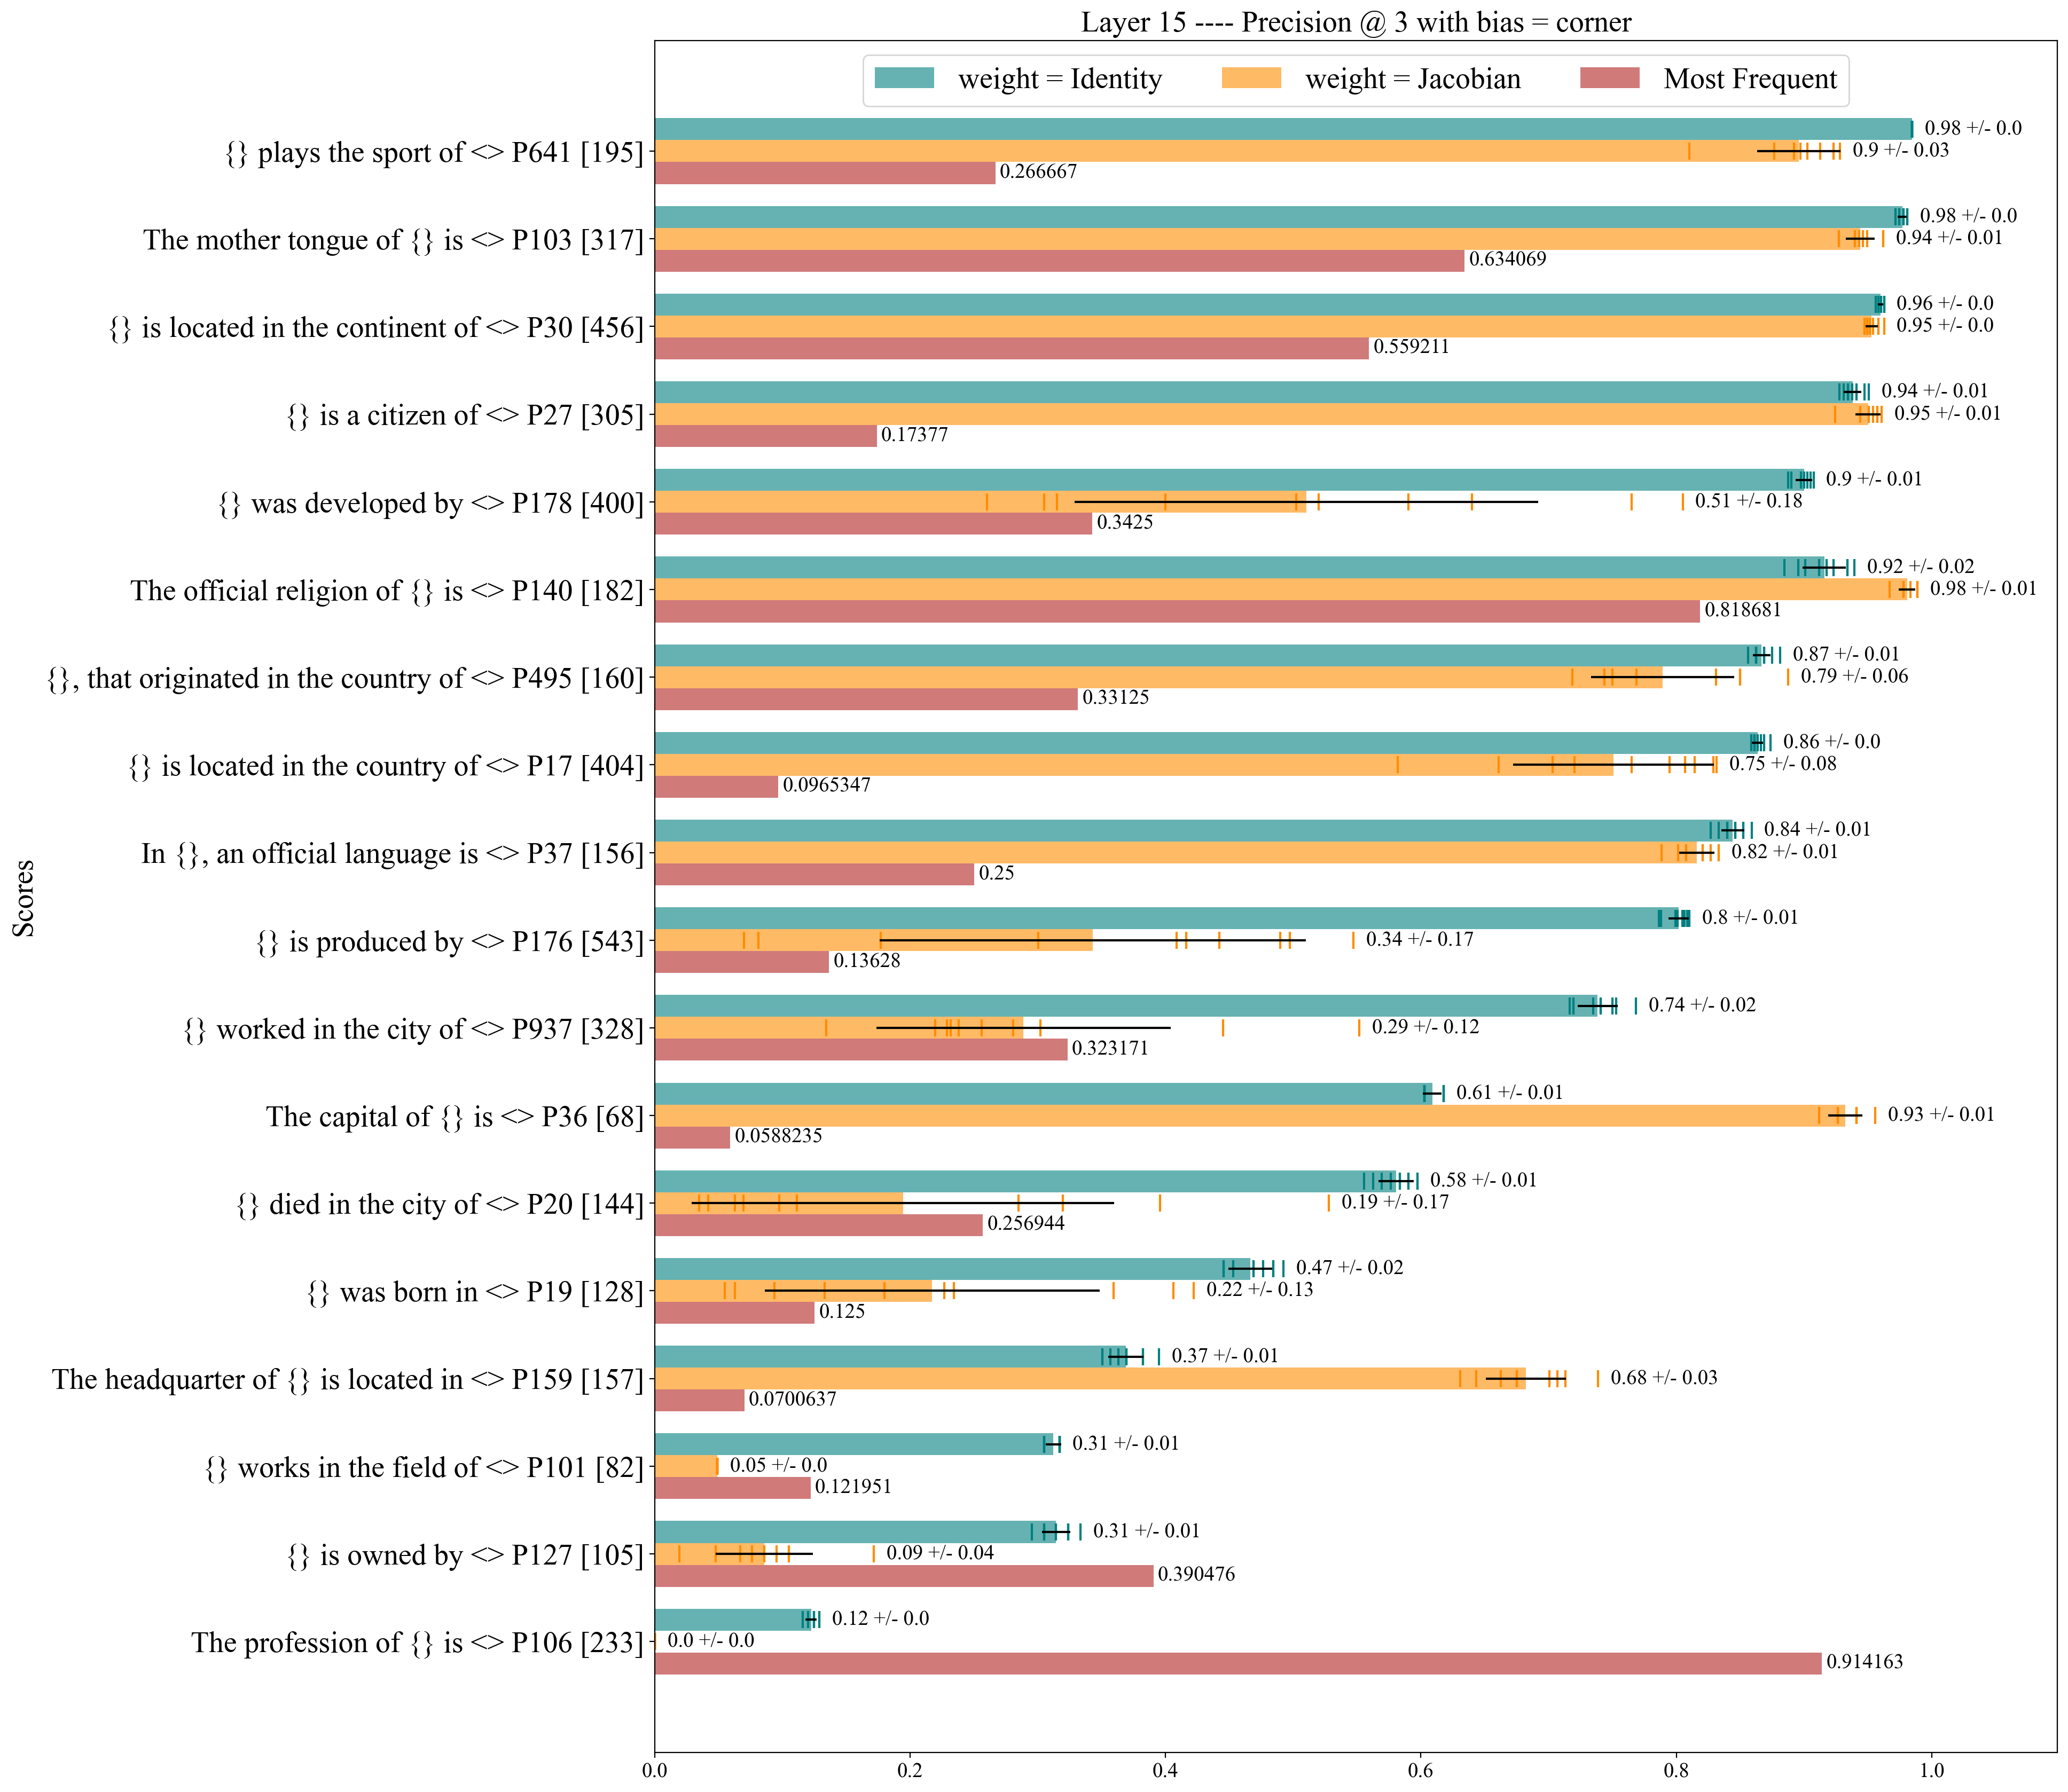

In [120]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,17)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


identity_color = "teal"
jacobian_color = "darkorange"
frequency_color = "firebrick"
bar_alpha = 0.6

y = np.arange(len(relations))  # the label locations
width = 0.75  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(y + width/3, identity_accuracies.mean(axis = 1), width/3, label='weight = Identity', xerr = identity_accuracies.std(axis = 1), color = identity_color, alpha = bar_alpha)
rects2 = ax.barh(y, jacobian_accuracies.mean(axis = 1), width/3, label='weight = Jacobian', xerr = jacobian_accuracies.std(axis = 1), color = jacobian_color, alpha = bar_alpha)
rects3 = ax.barh(y - width/3, freq_accuracies, width/3, label='Most Frequent', color = frequency_color, alpha = bar_alpha)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title(f'Layer {layer} ---- Precision @ 3 with bias = corner')
ax.set_yticks(y, relations)
ax.legend(loc="upper center", ncol=3)


def add_bar_labels(rects, accuracies, color = "black"):
    labels = [f"{round(acc.mean(), 2)} +/- {round(acc.std(), 2)}" for acc in accuracies]
    for rect, acc, label in zip(rects, accuracies, labels):
        # x_pos = acc.mean() + acc.std() + .01
        x_pos = acc.max() + 0.01
        y_pos = rect.get_y() + rect.get_height() / 2
        ax.text(
            x_pos, y_pos, label, ha="left", va="center",
        )
        points = acc
        ax.scatter(points, [y_pos]*len(points), color = color, marker="|", s = 140)

add_bar_labels(rects1, identity_accuracies, color = identity_color)
add_bar_labels(rects2, jacobian_accuracies, color = jacobian_color)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.savefig(f"performance_conparison.png")

plot_margin = 0.06

x0, x1, y0, y1 = plt.axis()
plt.axis((x0, x1 + plot_margin, y0, y1))

fig.show()

/tmp/ipykernel_2004291/2361202350.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


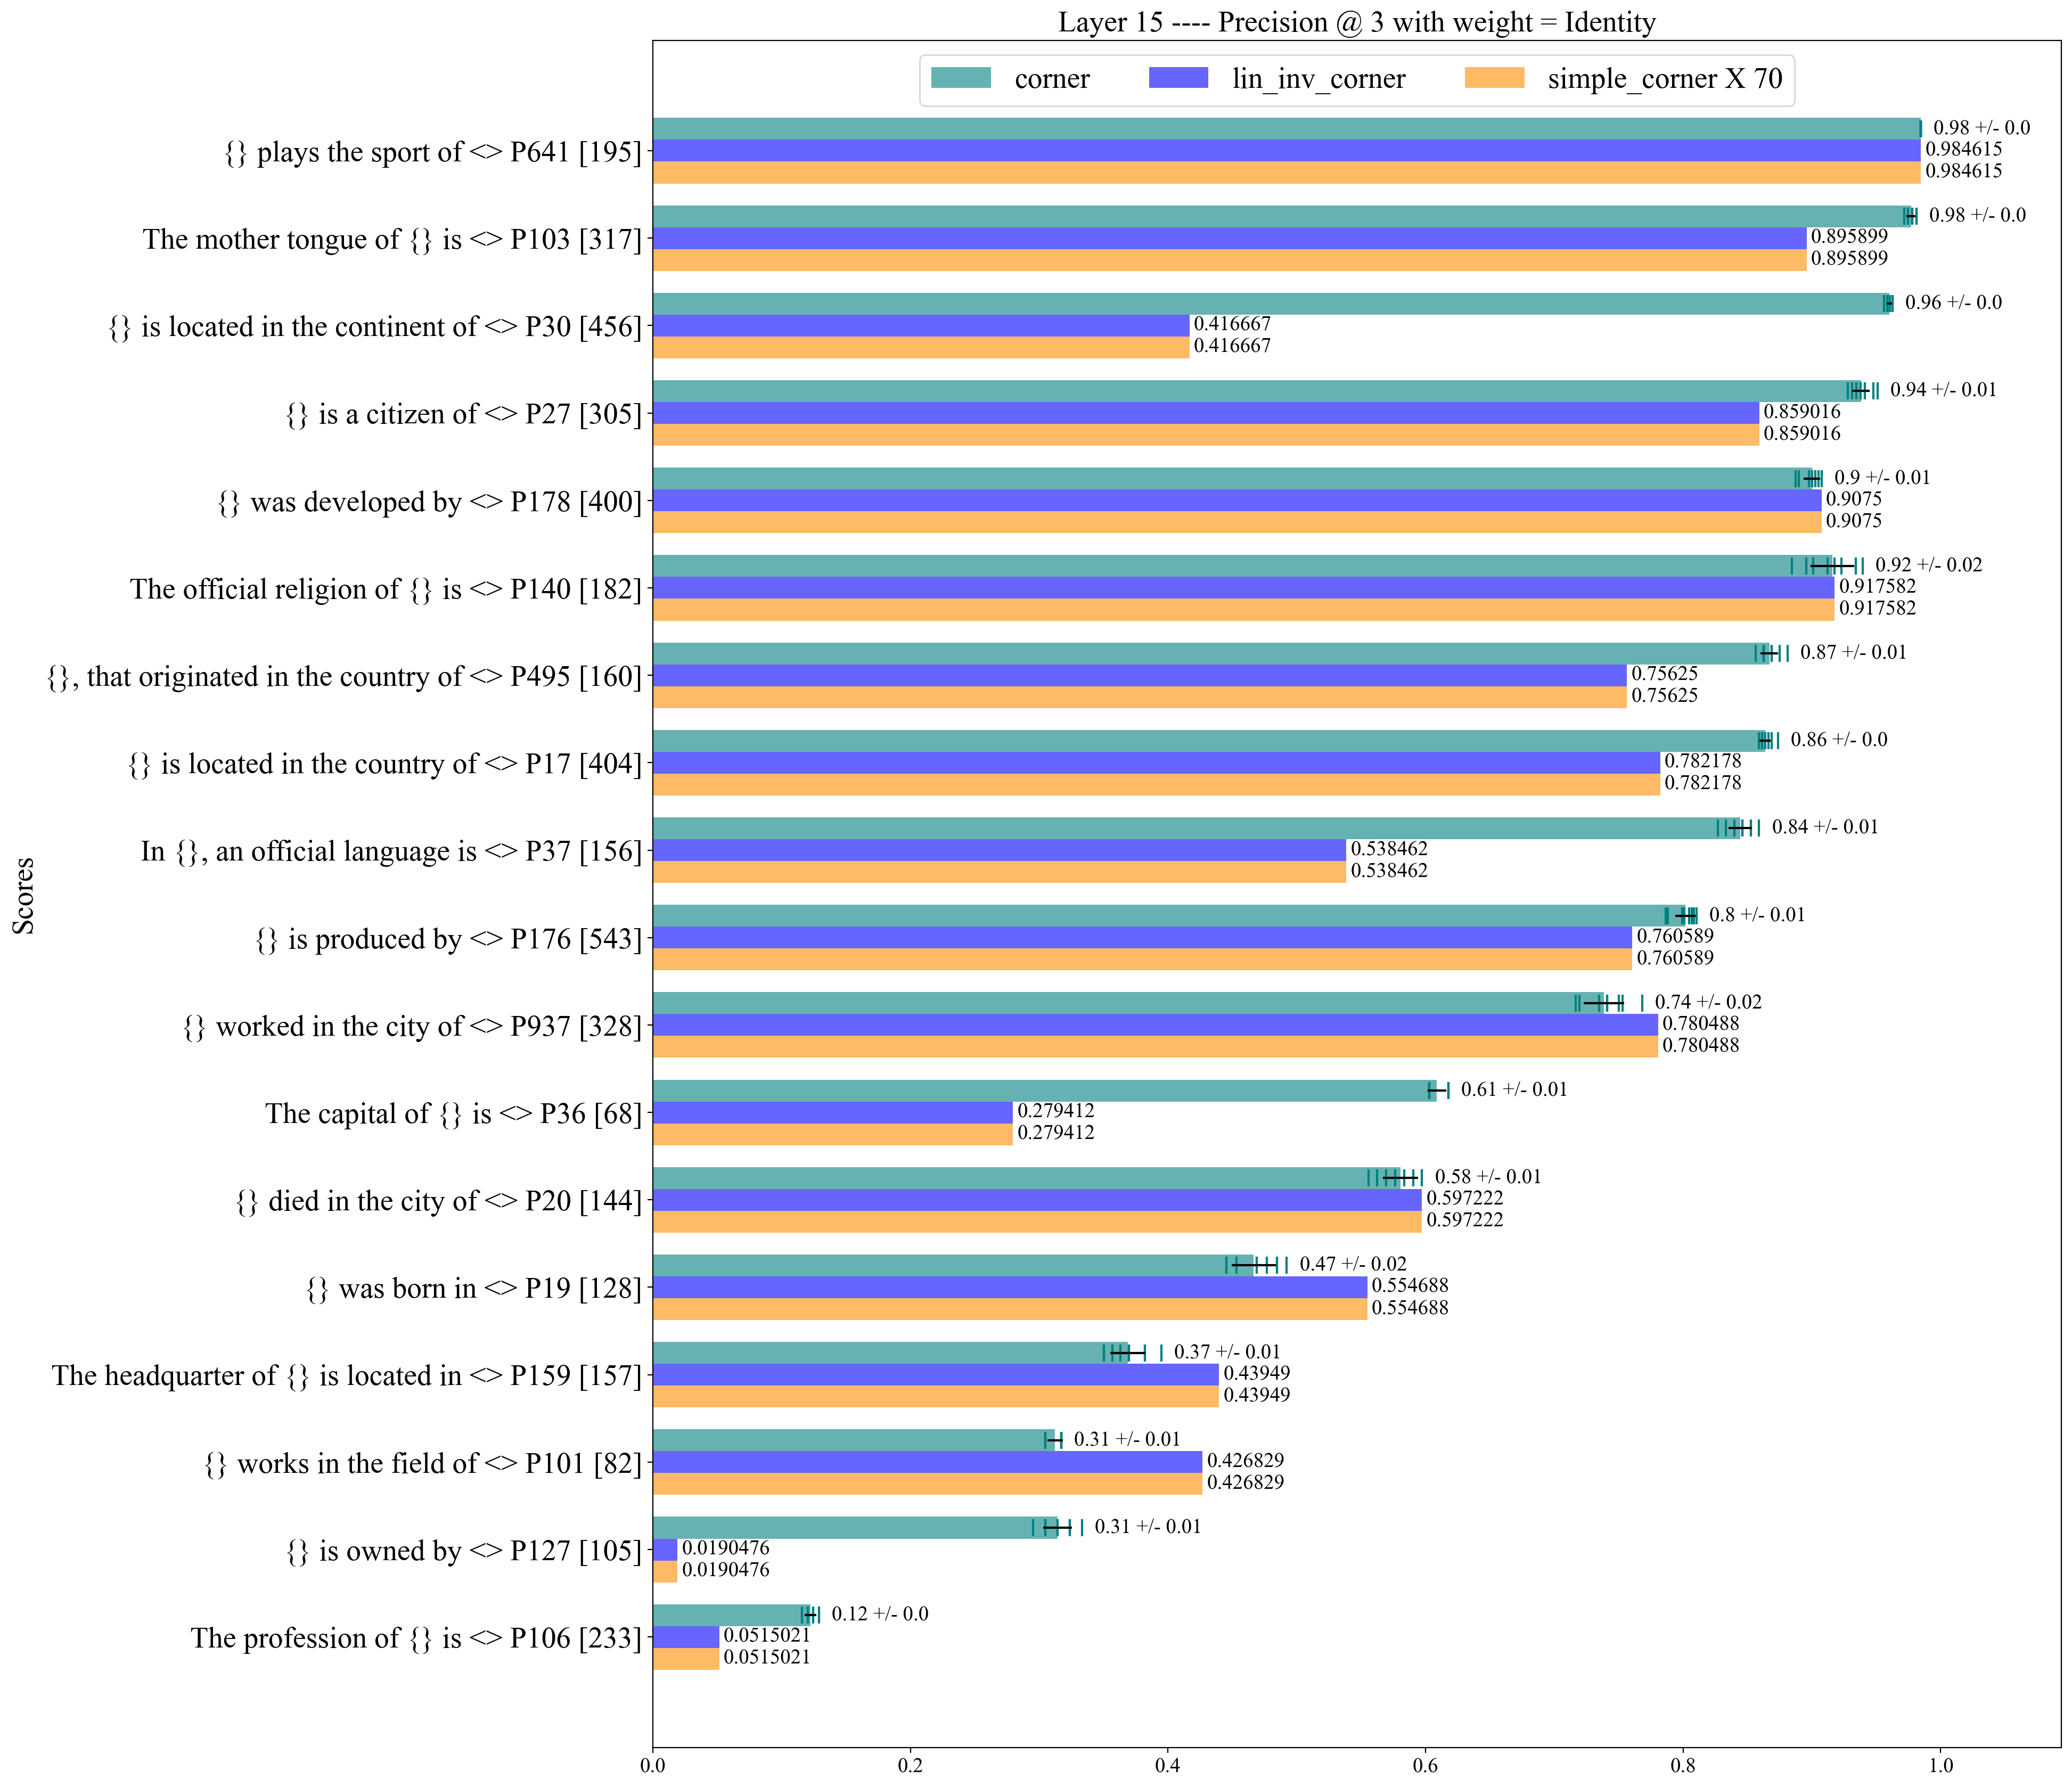

## New Results!

In [158]:
with open("performance_track.json") as f:
    accuracy_tracker = json.load(f)

In [160]:
# accuracy_tracker[relation_id] = {
#     'out_of'        : len(correct_predictions),
#     'identity_acc'  : {"corner":[], "simple_corner": None},
#     'jacobian_acc'  : {
#                         "before__ln_f"   : {"corner":[], "simple_corner": []},
#                         "after__ln_f"    : {"corner":[], "simple_corner": []}
#                     },
#     'jacobian_plus_identity': {
#                         "before__ln_f"   : {"corner":[], "simple_corner": []},
#                         "after__ln_f"    : {"corner":[], "simple_corner": []}
#                     },
#     'freq_acc'      : None
# }

In [235]:
lst = []
for r in accuracy_tracker:
    dct = {"relation": r}
    for k, v in accuracy_tracker[r].items():
        dct[k] = v
    dct["sorting_criteria"] = accuracy_tracker[r]['identity_acc']['simple_corner']
    lst.append(dct)
lst.sort(key = itemgetter("sorting_criteria"))

identity_accuracies = {"corner": [], "simple_corner": []}
jacobian_accuracies = {
                        "before__ln_f"   : {"corner":[], "simple_corner": []},
                        "after__ln_f"    : {"corner":[], "simple_corner": []}
                    }
jacobian_plus_identity = {
                        "before__ln_f"   : {"corner":[], "simple_corner": []},
                        "after__ln_f"    : {"corner":[], "simple_corner": []}
                    }
simple_corner_accuracy = []
freq_accuracies = []
relations = []

ln_f_config = list(jacobian_accuracies.keys())
corner_config = list(jacobian_accuracies[ln_f_config[0]].keys())

for r in lst:
    relations.append(f"{relation_dct[r['relation']]['relation']} <> {r['relation']} [{r['out_of']}]")
    freq_accuracies.append(r["freq_acc"])
    identity_accuracies['simple_corner'].append(r['identity_acc']['simple_corner'])
    identity_accuracies['corner'].append(np.array(r["identity_acc"]['corner']))

    for ln_f in ln_f_config:
        for corner in corner_config:
            jacobian_accuracies[ln_f][corner].append(np.array(r['jacobian_acc'][ln_f][corner]))
            jacobian_plus_identity[ln_f][corner].append(np.array(r['jacobian_plus_identity'][ln_f][corner]))
    # jacobian_accuracies.append(np.array(r["jacobian_acc"]))
    # simple_corner_accuracy.append(r["identity__simple_corner"])
    # lin_env_corner_accuracy.append(r["identity__lin_inv_corner"])

identity_accuracies['simple_corner'] = np.array(identity_accuracies['simple_corner'])
identity_accuracies['corner'] = np.stack(identity_accuracies['corner'])
for ln_f in ln_f_config:
    for corner in corner_config:
        jacobian_accuracies[ln_f][corner] = np.stack(jacobian_accuracies[ln_f][corner])
        jacobian_plus_identity[ln_f][corner] = np.stack(jacobian_plus_identity[ln_f][corner])

identity_accuracies['corner'].shape, identity_accuracies['simple_corner'].shape

((18, 10), (18,))

In [233]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

def add_bar_labels(rects, accuracies, color = "black"):
    labels = [f"{round(acc.mean(), 2)} +/- {round(acc.std(), 2)}" for acc in accuracies]
    for rect, acc, label in zip(rects, accuracies, labels):
        # x_pos = acc.mean() + acc.std() + .01
        x_pos = acc.max() + 0.01
        y_pos = rect.get_y() + rect.get_height() / 2
        ax.text(
            x_pos, y_pos, label, ha="left", va="center",
        )
        points = acc
        ax.scatter(points, [y_pos]*len(points), color = color, marker="|", s = 140)

/tmp/ipykernel_2004291/2686006857.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


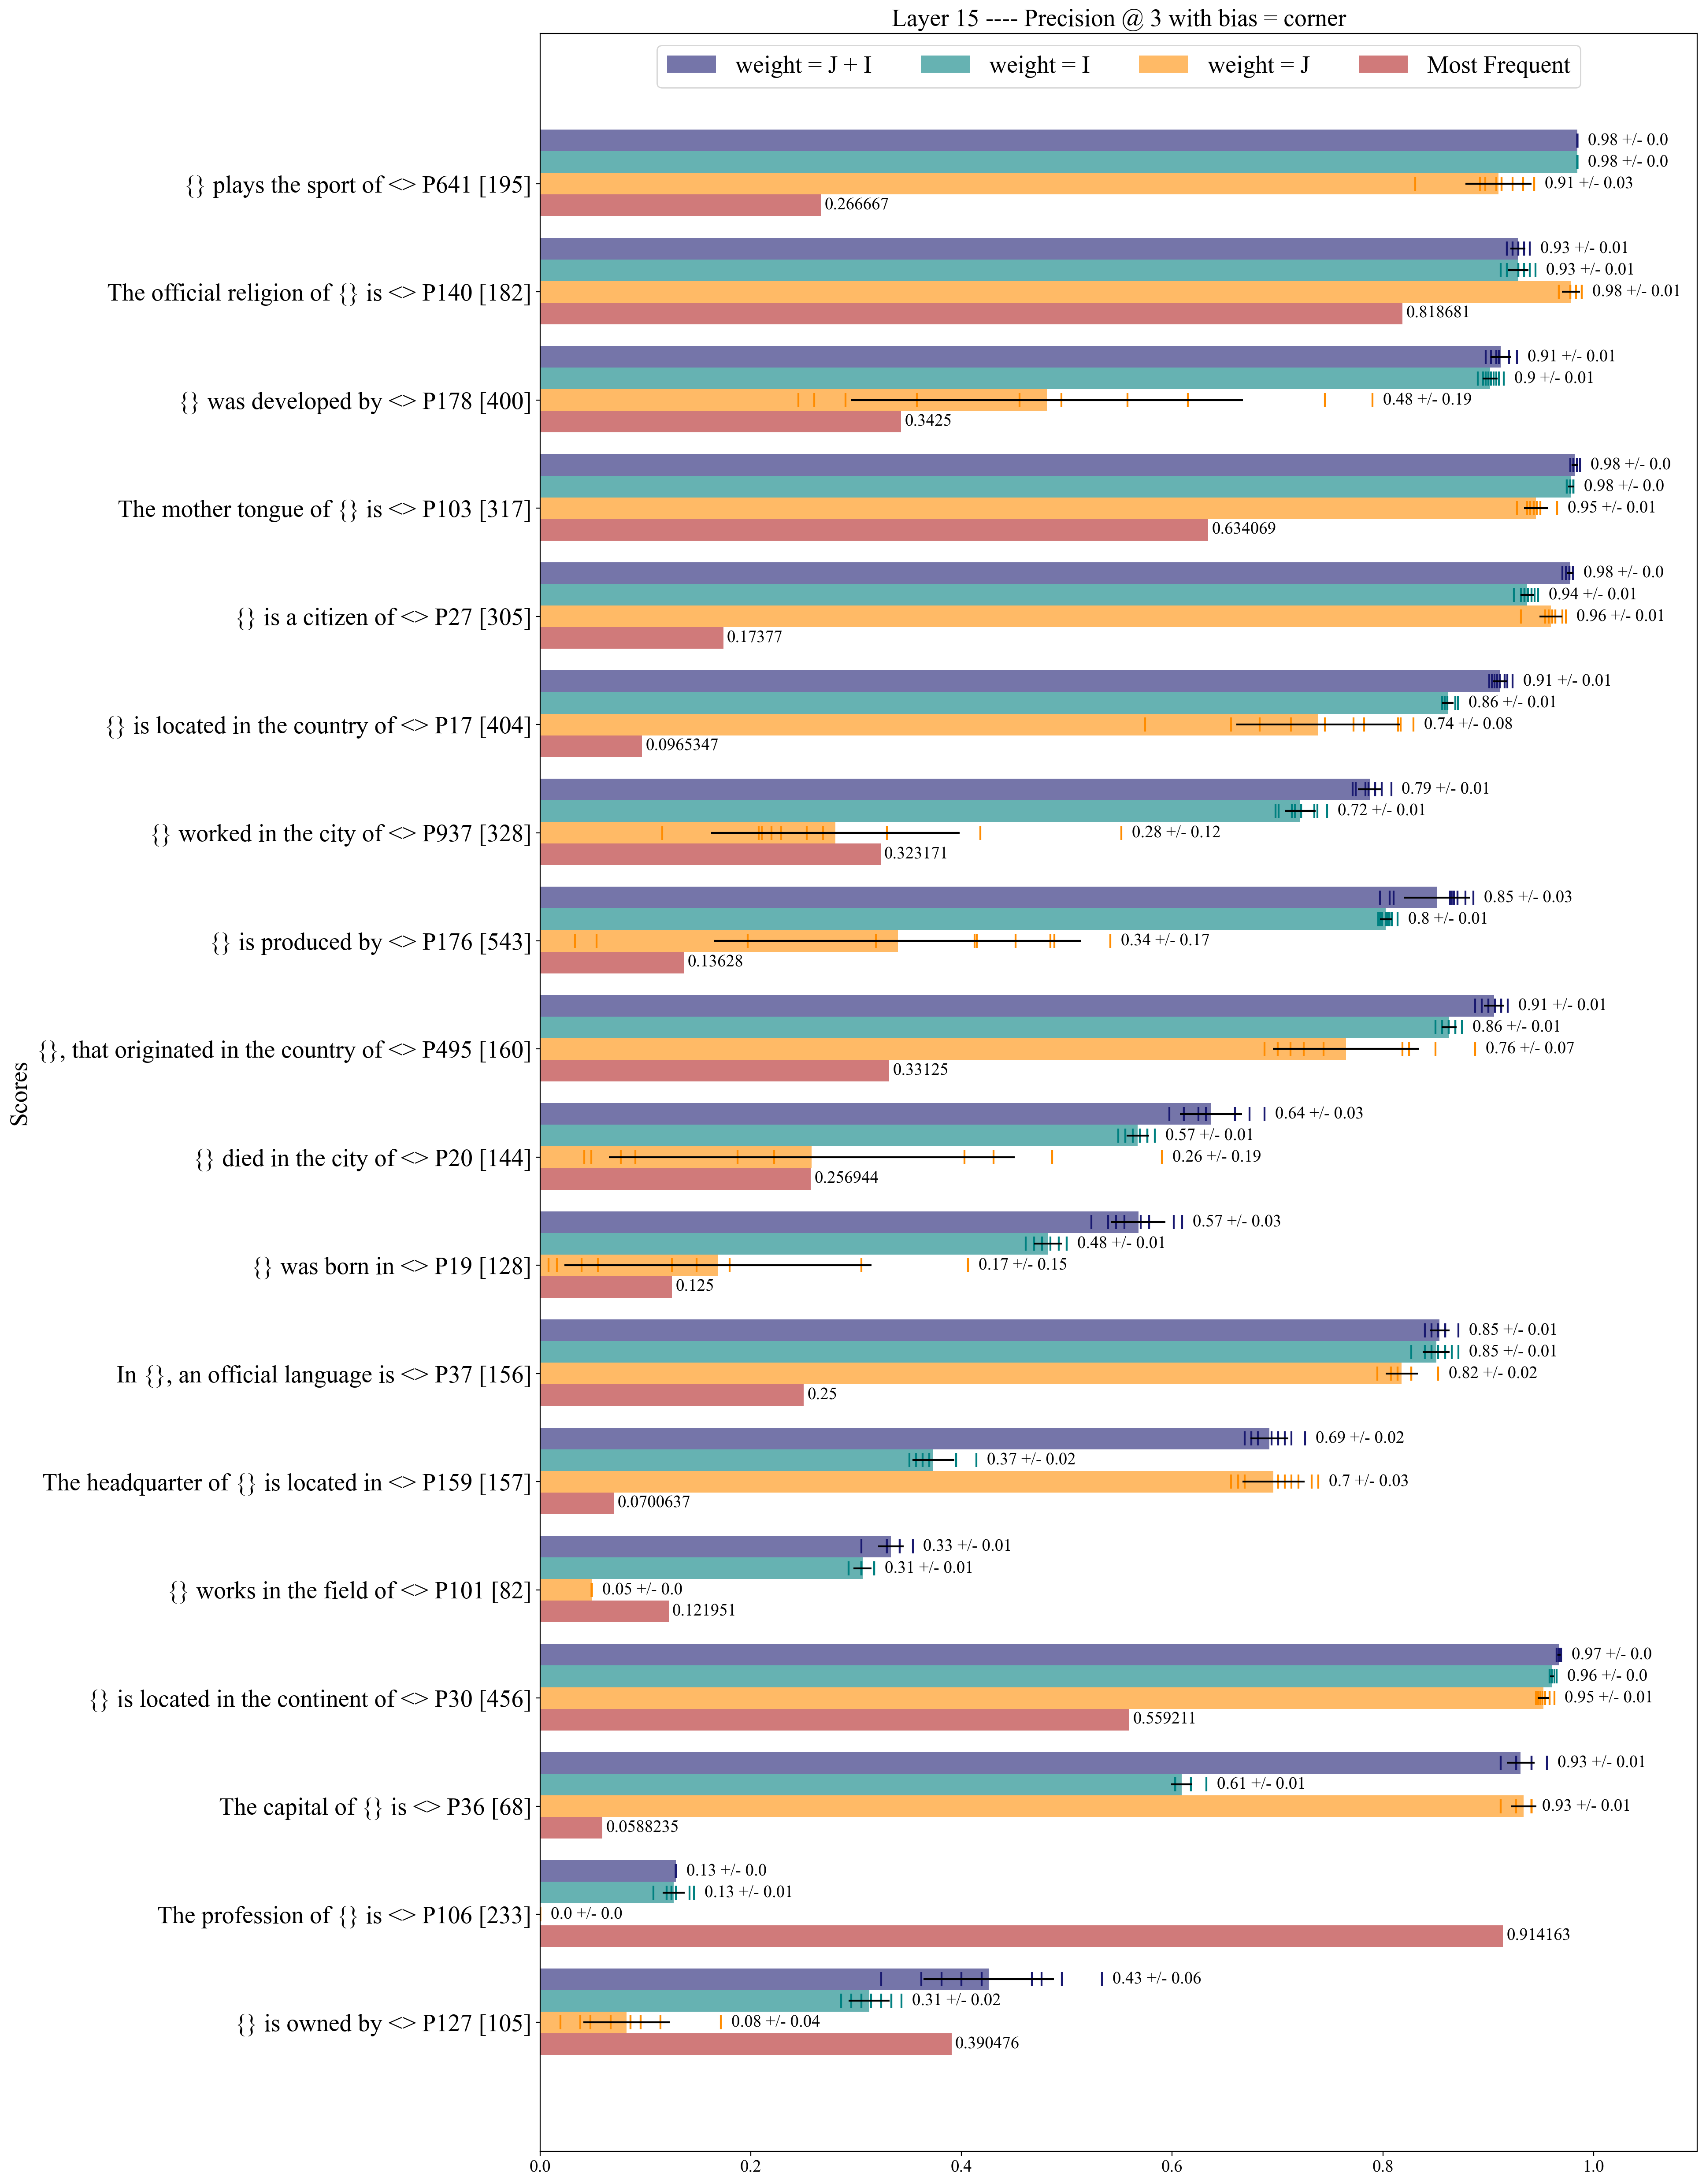

In [234]:
jacobian_plus_identity = jacobian_plus_identity['before__ln_f']['corner']
jacobian_accuracies = jacobian_accuracies['before__ln_f']['corner']
identity_accuracies = identity_accuracies['corner']


y = np.arange(len(relations))  # the label locations
width = 0.8  # the width of the bars
identity_color = "teal"
jacobian_color = "darkorange"
frequency_color = "firebrick"
jacobian_plus_identity_color = "midnightblue"
bar_alpha = 0.6
plt.rcParams["figure.figsize"] = (20,25)


fig, ax = plt.subplots()
rects1 = ax.barh(y + width*.5, jacobian_plus_identity.mean(axis = 1), width/4, label='weight = J + I', xerr = jacobian_plus_identity.std(axis = 1), color = jacobian_plus_identity_color, alpha = bar_alpha)
rects2 = ax.barh(y + width*.25, identity_accuracies.mean(axis = 1), width/4, label='weight = I', xerr = identity_accuracies.std(axis = 1), color = identity_color, alpha = bar_alpha)
rects3 = ax.barh(y, jacobian_accuracies.mean(axis = 1), width/4, label='weight = J', xerr = jacobian_accuracies.std(axis = 1), color = jacobian_color, alpha = bar_alpha)
rects4 = ax.barh(y - width*.25, freq_accuracies, width/4, label='Most Frequent', color = frequency_color, alpha = bar_alpha)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title(f'Layer {layer} ---- Precision @ 3 with bias = corner')
ax.set_yticks(y, relations)
ax.legend(loc="upper center", ncol=4)

add_bar_labels(rects1, jacobian_plus_identity, color = jacobian_plus_identity_color)
add_bar_labels(rects2, identity_accuracies, color = identity_color)
add_bar_labels(rects3, jacobian_accuracies, color = jacobian_color)
ax.bar_label(rects4, padding=3)

fig.tight_layout()
plot_margin = 0.06
x0, x1, y0, y1 = plt.axis()
plt.axis((x0, x1 + plot_margin, y0, y1))

# plt.savefig(f"performance_conparison.png")
fig.show()

Text(0.5, 1.0, 'weight = I VS weight = J (bias = corner)')

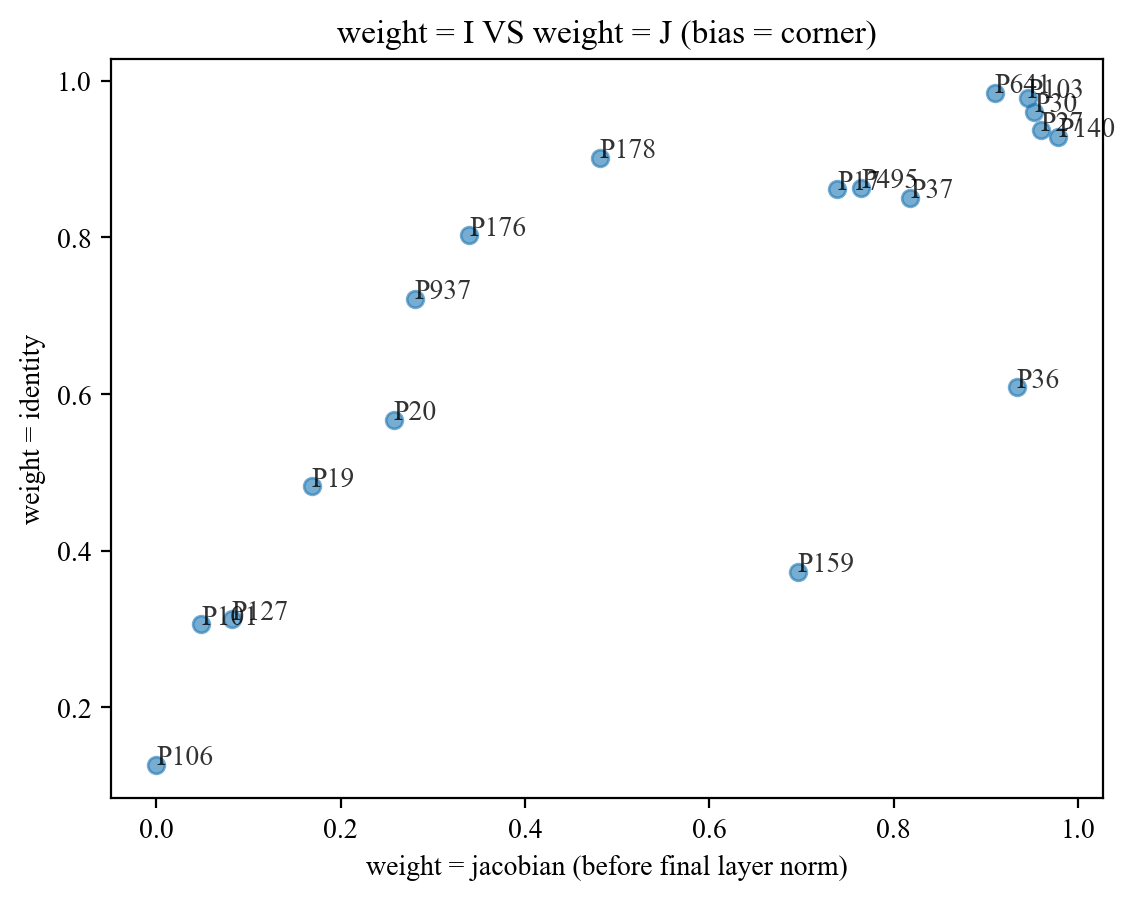

In [196]:
plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"
y = identity_accuracies.mean(axis = 1)
x = jacobian_accuracies.mean(axis = 1)
z = [l['relation'] for l in lst]

plt.scatter(x, y, alpha=0.6)
for i, txt in enumerate(z):
    plt.annotate(txt, (x[i], y[i]), alpha = 0.8)

plt.ylabel("weight = identity")
plt.xlabel("weight = jacobian (before final layer norm)")
plt.title("weight = I VS weight = J (bias = corner)")

/tmp/ipykernel_2004291/1445240532.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


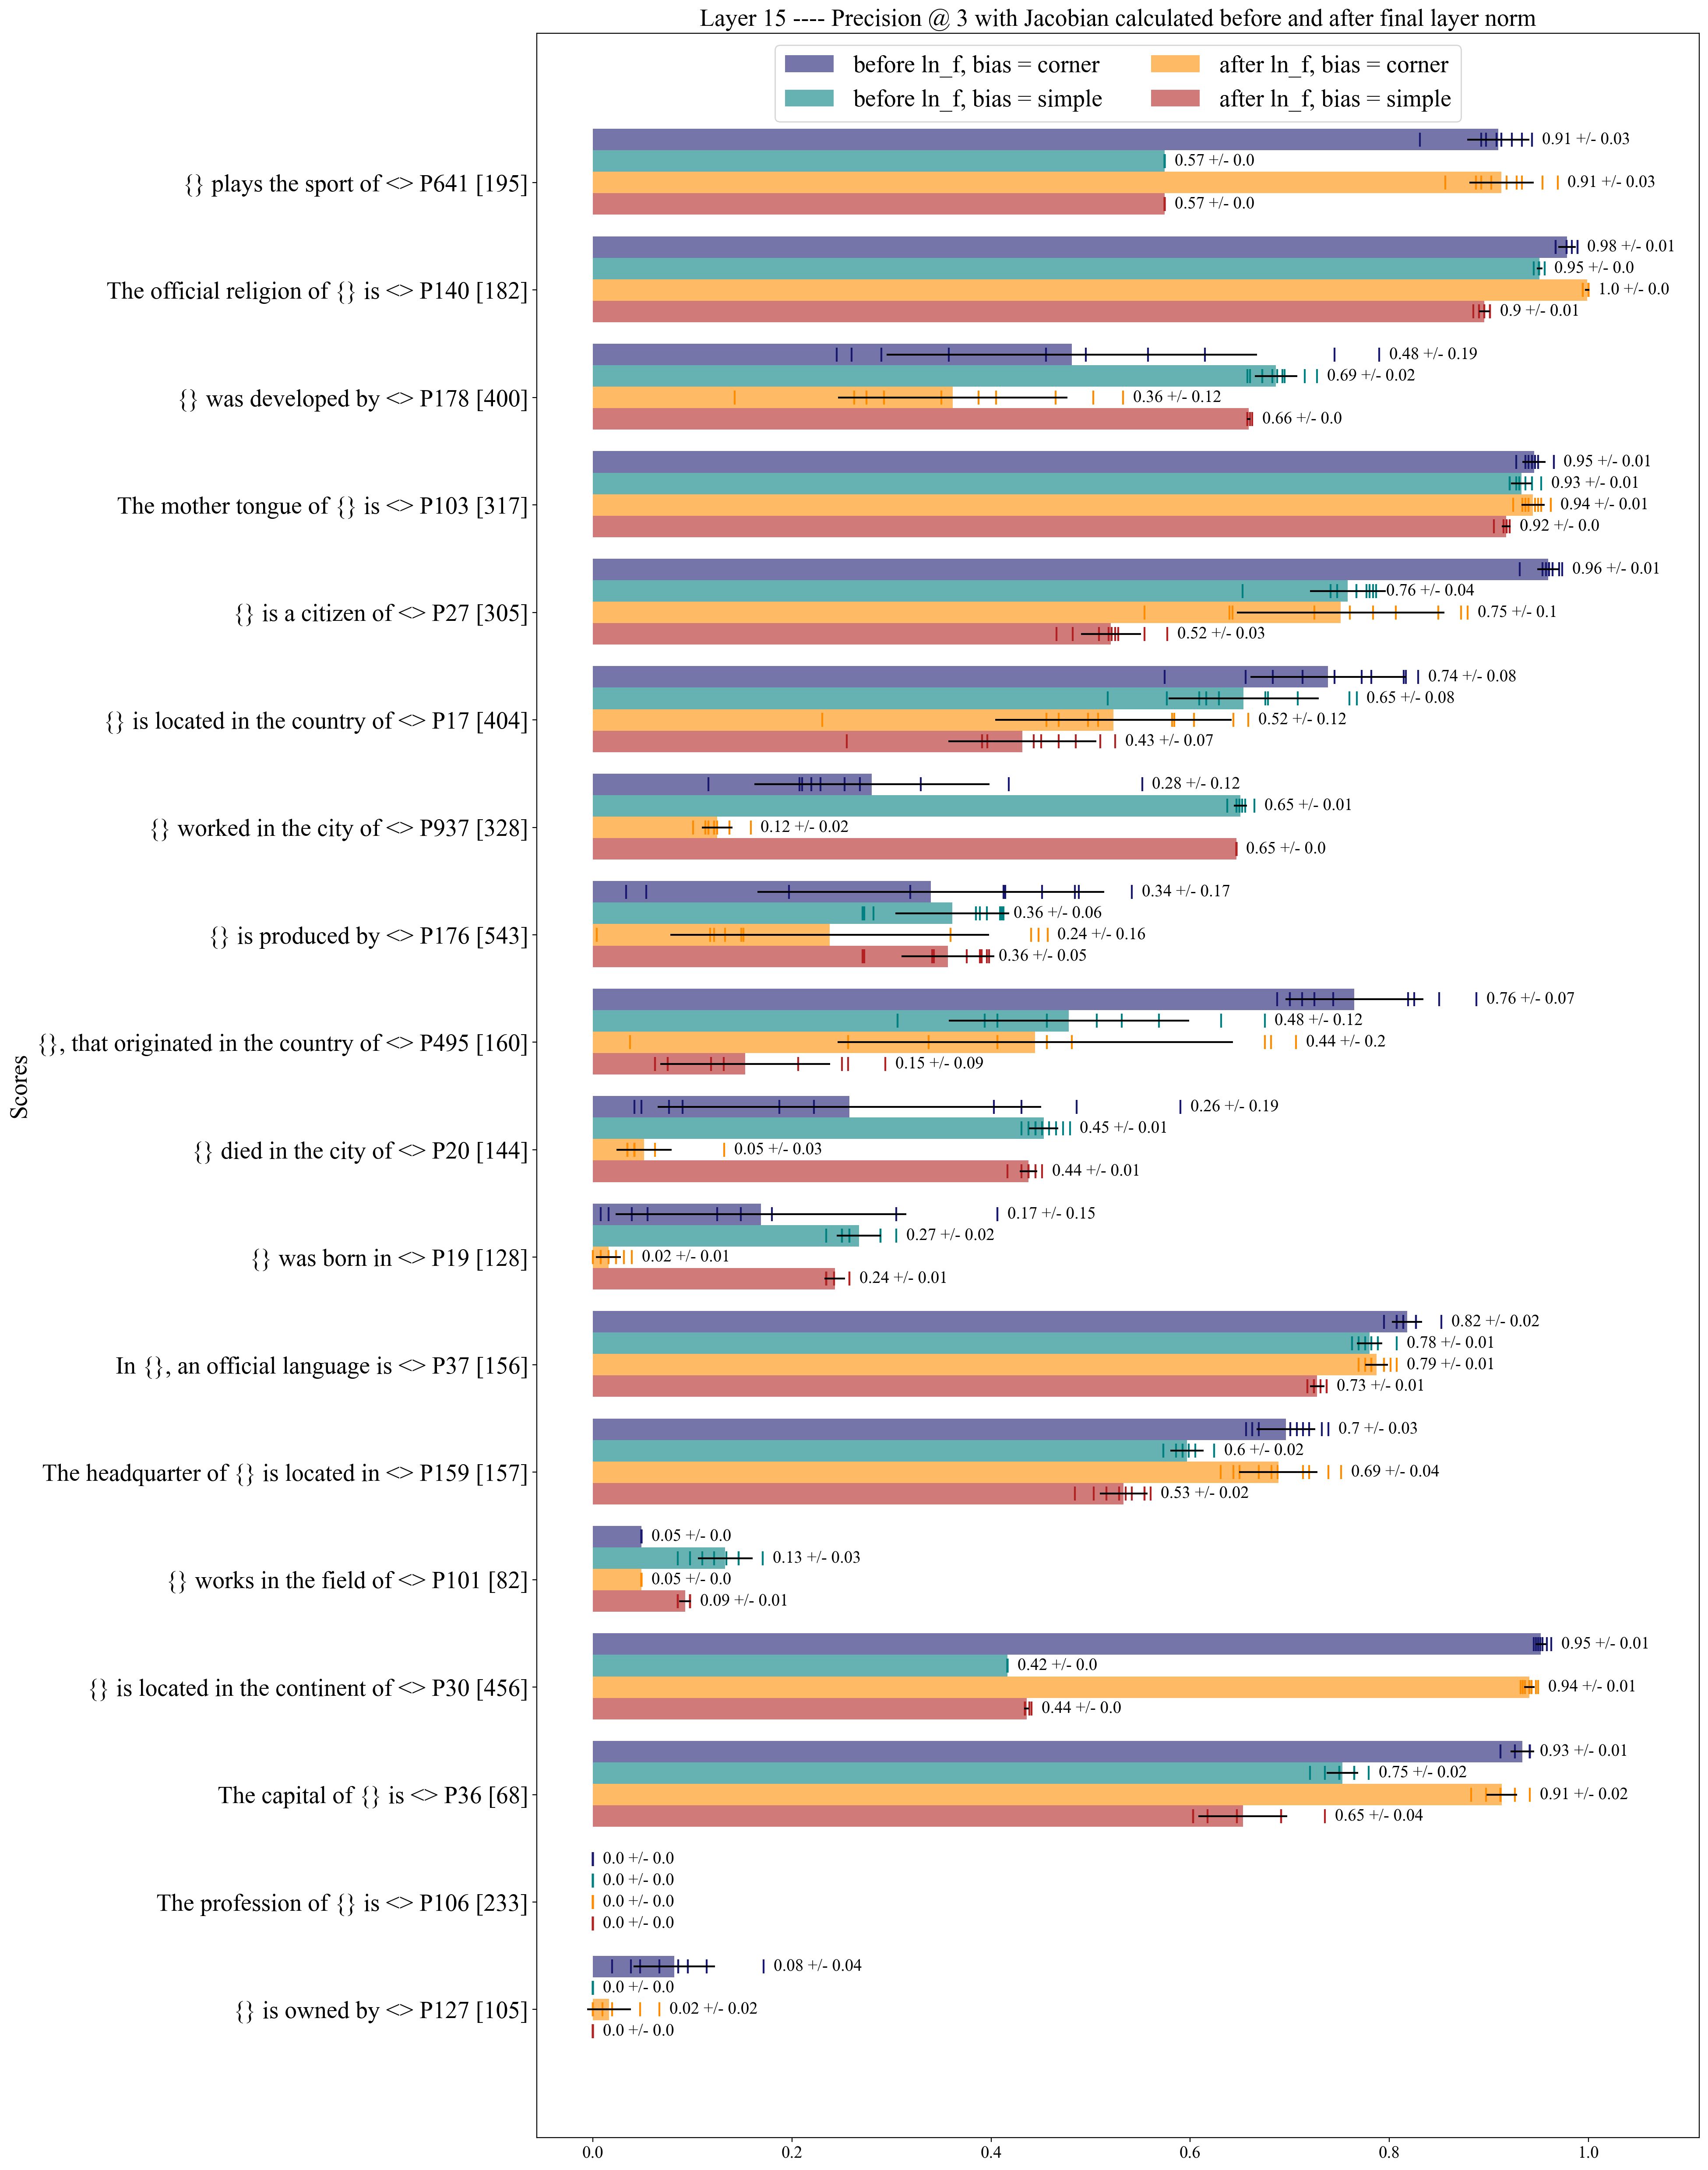

In [236]:
distributions = [
    jacobian_accuracies["before__ln_f"]["corner"],
    jacobian_accuracies["before__ln_f"]["simple_corner"],
    jacobian_accuracies["after__ln_f"]["corner"],
    jacobian_accuracies["after__ln_f"]["simple_corner"],
]

colors = ["midnightblue", "teal", "darkorange", "firebrick"]

y = np.arange(len(relations))  # the label locations
width = 0.8  # the width of the bars
bar_alpha = 0.6
plt.rcParams["figure.figsize"] = (20,25)


fig, ax = plt.subplots()
rects1 = ax.barh(y + width*.5, distributions[0].mean(axis = 1), width/4, label='before ln_f, bias = corner', xerr = distributions[0].std(axis = 1), color = colors[0], alpha = bar_alpha)
rects2 = ax.barh(y + width*.25, distributions[1].mean(axis = 1), width/4, label='before ln_f, bias = simple', xerr = distributions[1].std(axis = 1), color = colors[1], alpha = bar_alpha)
rects3 = ax.barh(y, distributions[2].mean(axis = 1), width/4, label='after ln_f, bias = corner', xerr = distributions[2].std(axis = 1), color = colors[2], alpha = bar_alpha)
rects4 = ax.barh(y - width*.25, distributions[3].mean(axis = 1), width/4, label='after ln_f, bias = simple', xerr = distributions[3].std(axis = 1), color = colors[3], alpha = bar_alpha)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title(f'Layer {layer} ---- Precision @ 3 with Jacobian calculated before and after final layer norm')
ax.set_yticks(y, relations)
ax.legend(loc="upper center", ncol=2)

add_bar_labels(rects1, distributions[0], color = colors[0])
add_bar_labels(rects2, distributions[1], color = colors[1])
add_bar_labels(rects3, distributions[2], color = colors[2])
add_bar_labels(rects4, distributions[3], color = colors[3])


fig.tight_layout()
plot_margin = 0.06
x0, x1, y0, y1 = plt.axis()
plt.axis((x0, x1 + plot_margin, y0, y1))

# plt.savefig(f"performance_conparison.png")
fig.show()